In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.4 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Chain_Snatching159.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


CNN SCORES ARRAY:
[     1.5547      1.5488      1.4727      1.4091      1.4168       1.322      1.3291      1.3857      1.4083      1.4129      1.5265      1.5677      1.5557      1.5834      1.6554      1.6773      1.6904      1.6856      1.6297      1.5799      1.6002      1.5511      1.6541       1.663      1.7017      1.6373
      1.6244      1.5425      1.5471      1.5228      1.5029       1.499      1.5219      1.5782      1.5691      1.5991      1.6967      1.7022      1.6657      1.6364      1.6388       1.654      1.6406      1.6162      1.6007      1.5982       1.612      1.6354      1.5983      1.6187      1.6073      1.5672
      1.5707      1.5748      1.5663      1.4343      1.4343      1.3894      1.4419       1.421       1.458      1.4598      1.4641      1.3423      1.3434      1.3497      1.3354      1.3432      1.3104      1.3383      1.3515      1.3839      1.3806      1.3923      1.3922      1.3791      1.3691      1.4438
      1.4317      1.3973      1.3781      1

Total Frames: 105
✅ Detected Snatching Events:
Event 1: Start = 48, End = 104, Duration = 1.90 sec


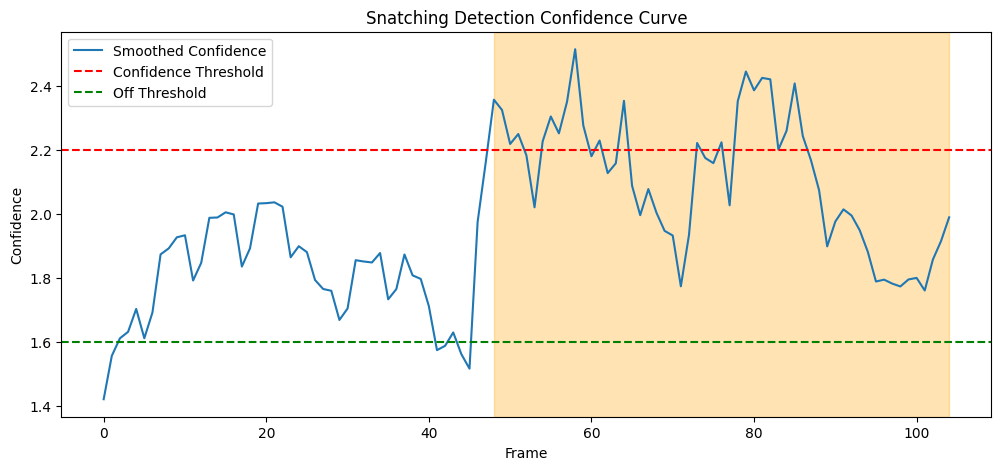

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# INPUT ARRAYS (EXACTLY YOUR DATA — DO NOT CHANGE)
# ============================================================
cnn_score = np.array([
1.4183,1.4384,1.456,1.4199,1.3941,1.3916,1.3882,1.4507,1.4731,1.4588,
1.452,1.4557,1.4657,1.4513,1.3996,1.4124,1.4469,1.4437,1.4486,1.4761,
1.4935,1.4772,1.4918,1.4921,1.5148,1.4868,1.4942,1.4276,1.4452,1.4449,
1.4329,1.413,1.373,1.39,1.3948,1.3933,1.3882,1.3953,1.355,1.261,
1.2511,1.25,1.2894,1.3178,1.2356,1.2454,1.5922,1.5931,1.6065,1.5972,
1.642,1.5899,1.6379,1.6384,1.6859,1.6633,1.6642,1.6887,1.7046,1.7057,
1.6631,1.622,1.6142,1.4752,1.4635,1.4638,1.4814,1.3594,1.3669,1.3525,
1.3965,1.3978,1.4624,1.3505,1.3793,1.5473,1.562,1.5611,1.6319,1.8173,
1.7141,1.7654,1.6804,1.6812,1.5208,1.5859,1.5201,1.5074,1.4835,1.4793,
1.7058,1.6013,1.6182,1.5659,1.5708,1.5705,1.5867,1.6584,1.6229,1.6619,
1.6648,1.6649,1.6987,1.7174,1.8027
])

motion_score = np.array([
0.0021474,0.43398,0.28267,0.25799,0.26598,0.0032698,0.27491,0.47324,0.25865,0.30393,
0.2746,0.0033425,0.28285,0.47871,0.22842,0.24341,0.20682,0.0043605,0.22265,0.35232,
0.21651,0.22539,0.19886,0.0011538,0.17526,0.13189,0.036082,0.10247,0.1135,0.006664,
0.22246,0.49837,0.29382,0.28288,0.29836,0.0010684,0.24403,0.39493,0.1626,0.24699,
0.12705,0.0013755,0.15981,0.19822,0.095484,0.094314,0.2593,0.0013857,0.11776,0.29625,
0.14914,0.33266,0.1769,0.0012934,0.41145,0.33141,0.18698,0.35986,0.48027,0.008172,
0.17095,0.42221,0.16119,0.44128,0.67632,0.0022343,0.15079,0.45653,0.23336,0.2307,
0.25053,0.002592,0.42264,0.76973,0.22211,0.18575,0.26354,0.0018889,0.4792,0.39154,
0.24812,0.348,0.33854,0.0030335,0.45737,0.60924,0.17721,0.25331,0.19361,0.0051654,
0.25975,0.28851,0.19069,0.1587,0.077962,0.0010182,0.11345,0.048504,0.066338,0.086588,
0.068839,0.0017424,0.18056,0.15632,0.16139
])

force_score = np.array([
2.1474e-09,4.3398e-07,2.8267e-07,2.5799e-07,42382,521.03,43805,75407,41214,49480,
44704,544.16,46048,77934,73401,78217,66461,1401.2,71545,107310,65945,68651,60570,
351.43,58605,44102,12065,34264,37953,800.38,26718,59857,35289,33976,51189,183.3,
41867,67756,27897,53095,27312,295.68,34354,42611,14469,14292,39293,209.99,17846,
71976,36234,80824,42979,314.25,123340,99347,56052,107880,143970,1172.1,24519,
60555,23118,63290,135270,446.88,30159,91310,46673,46779,50799,525.58,85698,
156080,93797,78440,111290,797.67,202360,91460,57957,81290,79081,708.59,84650,
112760,32798,46883,35834,770.42,38742,43032,28442,23670,14948,195.23,21752,
9299.9,12719,19659,15629,395.61,40994,35491,40117
])

contact_flag = np.array([
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

# ============================================================
# EVENT DETECTION FUNCTION (ALL FRAMES)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score, motion_score, force_score, contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.2,
    off_threshold=1.2,
    min_duration_seconds=0.3,
    contact_grace_frames=10
):
    T = len(cnn_score)
    force_norm = force_score / np.max(force_score)
    smoothed_confidence = np.zeros(T)
    frame_score = np.zeros(T)

    # Compute smoothed confidence for all frames
    for t in range(T):
        frame_score[t] = cnn_score[t] + motion_score[t] + force_norm[t] + contact_flag[t]
        smoothed_confidence[t] = frame_score[t] if t == 0 else alpha * frame_score[t] + (1-alpha) * smoothed_confidence[t-1]

    min_frames = int(min_duration_seconds * fps)
    events = []
    in_event = False
    start = 0
    last_contact = -999

    # Check all frames
    for t in range(T):
        if contact_flag[t] == 1:
            last_contact = t

        if not in_event and smoothed_confidence[t] >= confidence_threshold:
            in_event = True
            start = t

        elif in_event and smoothed_confidence[t] < off_threshold and (t - last_contact) > contact_grace_frames:
            end = t - 1
            if end - start + 1 >= min_frames:
                events.append((start, end, (end-start+1)/fps))
            in_event = False

    if in_event:
        end = T - 1
        if end - start + 1 >= min_frames:
            events.append((start, end, (end-start+1)/fps))

    return smoothed_confidence, events

# ============================================================
# RUN DETECTION
# ============================================================
smoothed_confidence, events = event_temporal_consistency_engineer(
    cnn_score, motion_score, force_score, contact_flag
)

print("Total Frames:", len(cnn_score))
if not events:
    print("❌ No snatching detected")
else:
    print("✅ Detected Snatching Events:")
    for i, (s, e, d) in enumerate(events,1):
        print(f"Event {i}: Start = {s}, End = {e}, Duration = {d:.2f} sec")

# ============================================================
# OPTIONAL: PLOT SMOOTHED CONFIDENCE
# ============================================================
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(smoothed_confidence, label="Smoothed Confidence")
plt.axhline(y=2.2, color='r', linestyle='--', label="Confidence Threshold")
plt.axhline(y=1.6, color='g', linestyle='--', label="Off Threshold")
for (s,e,_) in events:
    plt.axvspan(s, e, color='orange', alpha=0.3)
plt.xlabel("Frame")
plt.ylabel("Confidence")
plt.title("Snatching Detection Confidence Curve")
plt.legend()
plt.show()


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.2 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Chain_Snatching11.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


CNN SCORES ARRAY:
[     1.3236      1.3168      1.3187      1.3073      1.3059       1.309      1.3065      1.3232      1.3235      1.3125      1.3132      1.3343      1.3371      1.3473      1.3462       1.355      1.3539      1.3505      1.3534      1.3602      1.3592      1.3621      1.3569      1.3438      1.3503      1.3473
      1.3528        1.34      1.3428      1.3469      1.3492      1.3335      1.3341      1.3283      1.3269       1.349      1.3592      1.3647      1.3725      1.3712      1.3658      1.3496       1.355      1.3638      1.3677      1.3597       1.366      1.3549      1.3589      1.3375       1.338      1.3436
       1.345      1.3566      1.3632      1.3612      1.3692       1.344      1.3553      1.3371      1.3459      1.3418      1.3492      1.3477      1.3524      1.3529      1.3555      1.3679      1.3668      1.3447      1.3458      1.3302      1.3309      1.3287      1.3243      1.3234      1.3252      1.3096
      1.3082      1.3263      1.3241      1

CONTACT FLAGS ARRAY:
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER (TUNED THRESHOLDS)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,  # start detection threshold
    off_threshold=1.9,          # end detection threshold
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10
):
    cnn_score = np.array(cnn_score, dtype=float)
    motion_score = np.array(motion_score, dtype=float)
    force_score = np.array(force_score, dtype=float)
    contact_flag = np.array(contact_flag, dtype=int)

    T = len(cnn_score)
    if not all(len(arr) == T for arr in [motion_score, force_score, contact_flag]):
        raise ValueError("All input arrays must have the same length")

    # normalize force internally
    force_norm = force_score / np.max(force_score)

    smoothed_confidence = np.zeros(T)
    frame_score = np.zeros(T)

    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # EVENT DETECTION
    min_frames = int(min_duration_seconds * fps)
    events = []

    in_event = False
    start = 0
    last_contact = -999

    for t in range(warm_up_frames, T):
        if contact_flag[t] == 1:
            last_contact = t

        if not in_event and smoothed_confidence[t] >= confidence_threshold:
            in_event = True
            start = t

        elif in_event:
            if smoothed_confidence[t] < off_threshold and (t - last_contact) > contact_grace_frames:
                end = t - 1
                duration_frames = end - start + 1
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False

    if in_event:
        end = T - 1
        duration_frames = end - start + 1
        if duration_frames >= min_frames:
            events.append((start, end, duration_frames / fps))

    return smoothed_confidence, events


# ============================================================
# YOUR ORIGINAL ARRAYS
# ============================================================
cnn_score = np.array([
1.4183,1.4384,1.456,1.4199,1.3941,1.3916,1.3882,1.4507,1.4731,1.4588,
1.452,1.4557,1.4657,1.4513,1.3996,1.4124,1.4469,1.4437,1.4486,1.4761,
1.4935,1.4772,1.4918,1.4921,1.5148,1.4868,1.4942,1.4276,1.4452,1.4449,
1.4329,1.413,1.373,1.39,1.3948,1.3933,1.3882,1.3953,1.355,1.261,
1.2511,1.25,1.2894,1.3178,1.2356,1.2454,1.5922,1.5931,1.6065,1.5972,
1.642,1.5899,1.6379,1.6384,1.6859,1.6633,1.6642,1.6887,1.7046,1.7057,
1.6631,1.622,1.6142,1.4752,1.4635,1.4638,1.4814,1.3594,1.3669,1.3525,
1.3965,1.3978,1.4624,1.3505,1.3793,1.5473,1.562,1.5611,1.6319,1.8173,
1.7141,1.7654,1.6804,1.6812,1.5208,1.5859,1.5201,1.5074,1.4835,1.4793,
1.7058,1.6013,1.6182,1.5659,1.5708,1.5705,1.5867,1.6584,1.6229,1.6619,
1.6648,1.6649,1.6987,1.7174,1.8027
])

motion_score = np.array([
0.0021474,0.43398,0.28267,0.25799,0.26598,0.0032698,0.27491,0.47324,0.25865,0.30393,
0.2746,0.0033425,0.28285,0.47871,0.22842,0.24341,0.20682,0.0043605,0.22265,0.35232,
0.21651,0.22539,0.19886,0.0011538,0.17526,0.13189,0.036082,0.10247,0.1135,0.006664,
0.22246,0.49837,0.29382,0.28288,0.29836,0.0010684,0.24403,0.39493,0.1626,0.24699,
0.12705,0.0013755,0.15981,0.19822,0.095484,0.094314,0.2593,0.0013857,0.11776,0.29625,
0.14914,0.33266,0.1769,0.0012934,0.41145,0.33141,0.18698,0.35986,0.48027,0.008172,
0.17095,0.42221,0.16119,0.44128,0.67632,0.0022343,0.15079,0.45653,0.23336,0.2307,
0.25053,0.002592,0.42264,0.76973,0.22211,0.18575,0.26354,0.0018889,0.4792,0.39154,
0.24812,0.348,0.33854,0.0030335,0.45737,0.60924,0.17721,0.25331,0.19361,0.0051654,
0.25975,0.28851,0.19069,0.1587,0.077962,0.0010182,0.11345,0.048504,0.066338,0.086588,
0.068839,0.0017424,0.18056,0.15632,0.16139
])

force_score = np.array([
2.1474e-09,4.3398e-07,2.8267e-07,2.5799e-07,42382,521.03,43805,75407,41214,49480,
44704,544.16,46048,77934,73401,78217,66461,1401.2,71545,107310,65945,68651,60570,
351.43,58605,44102,12065,34264,37953,800.38,26718,59857,35289,33976,51189,183.3,
41867,67756,27897,53095,27312,295.68,34354,42611,14469,14292,39293,209.99,17846,
71976,36234,80824,42979,314.25,123340,99347,56052,107880,143970,1172.1,24519,
60555,23118,63290,135270,446.88,30159,91310,46673,46779,50799,525.58,85698,
156080,93797,78440,111290,797.67,202360,91460,57957,81290,79081,708.59,84650,
112760,32798,46883,35834,770.42,38742,43032,28442,23670,14948,195.23,21752,
9299.9,12719,19659,15629,395.61,40994,35491,40117
])

contact_flag = np.array([
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

# ============================================================
# RUN
# ============================================================
smoothed_confidence, events = event_temporal_consistency_engineer(
    cnn_score, motion_score, force_score, contact_flag
)

print("Total Frames:", len(cnn_score))

if not events:
    print("❌ No snatching detected")
else:
    print("✅ Detected Snatching Events:")
    for i, (s, e, d) in enumerate(events, 1):
        print(f"Event {i}: Start = {s}, End = {e}, Duration = {d:.2f} sec")

print("\nSmoothed Confidence Values:")
print(np.round(smoothed_confidence, 3))


Total Frames: 105
✅ Detected Snatching Events:
Event 1: Start = 46, End = 70, Duration = 0.83 sec
Event 2: Start = 72, End = 88, Duration = 0.57 sec

Smoothed Confidence Values:
[       1.42       1.556       1.611       1.631       1.703       1.611       1.692       1.873       1.892       1.926       1.933       1.791       1.847       1.987       1.988       2.005       1.998       1.835       1.892       2.032       2.033       2.036       2.022       1.864       1.899        1.88
       1.793       1.765       1.759       1.668       1.704       1.855       1.851       1.848       1.877       1.733       1.765       1.873       1.808       1.796       1.711       1.574       1.587       1.629       1.561       1.516       1.975       2.161       2.356       2.324       2.218       2.249
       2.183        2.02       2.226       2.304       2.251        2.35       2.514       2.276        2.18       2.229       2.127       2.158       2.353       2.087       1.996       2.077    

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Guyswalking_video.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


CNN SCORES ARRAY:
[     1.4286      1.4268      1.4374      1.4216       1.397      1.3765      1.4631      1.4627      1.4923      1.4875      1.5438      1.5969      1.6661      1.6639      1.6336      1.6086      1.5607      1.5703      1.5417      1.5438      1.4953      1.5542      1.6036      1.6075      1.5714      1.5716
      1.5024      1.5126      1.4881       1.502      1.5125      1.5127      1.4877      1.4454      1.4499       1.439       1.379      1.3792       1.358      1.3486      1.3868      1.4835       1.554      1.5551      1.6518      1.7149      1.6694      1.5963      1.5303      1.5333      1.4984      1.4626
       1.477      1.4874      1.5488      1.5509       1.592      1.5867      1.6089      1.5318      1.5105      1.5116        1.47      1.4923      1.5358      1.5283      1.5372      1.5344      1.4904      1.5441      1.5801      1.5753      1.5878      1.5948      1.5626      1.5984      1.5539      1.6296
      1.6236      1.6248      1.5951      1

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Chain_Snatching22.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


CNN SCORES ARRAY:
[     1.9888      2.0405      2.0214      2.0249       1.989      1.9871      1.9159      1.9167      1.9045      1.9051      1.9091      1.9076      1.9131      1.9126       1.922       1.915      1.9146      1.9138      1.9457      1.9387      1.9354      1.9362      1.9079      1.9112      1.9164      1.9177
      1.9121      1.8479      1.8491      1.8426      1.8941      1.8923      1.8989      1.8955      1.9113       1.908      1.9075      1.8907      1.8946      1.8933      1.9327      1.9298      1.8966      1.8912      1.9064      1.9089      1.9096      1.9169      1.9134      1.9191      1.8888      1.8916
      1.8867      1.8873      1.8903       1.808      1.8089      1.7878      1.7847      1.7774       1.814      1.8165       1.848      1.8445      1.8439      1.8378      1.8418      1.8673      1.8742       1.804      1.8031      1.8063      1.8292      1.8322      1.8317      1.8693      1.8695      1.8706
      1.8692      1.8716      1.8311      1

In [ ]:

import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Chain_Snatching157.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


CNN SCORES ARRAY:
[     1.7514      1.7419      1.7263      1.7053      1.6744      1.6699      1.6857      1.6827      1.7072      1.7101      1.6661      1.6519      1.6579      1.6331      1.5972      1.5985      1.5888      1.5979       1.593      1.6242      1.6206      1.6049       1.624      1.6508      1.6662      1.6743
      1.6687      1.6642      1.6579      1.6126      1.6312      1.6202      1.6586      1.6638       1.658      1.6365      1.6273       1.604      1.6346      1.6392      1.6202      1.6097      1.6386      1.6478      1.6776      1.6893      1.6989      1.7202      1.7205      1.7073      1.6537      1.6705
      1.6493      1.6319      1.6014      1.5698      1.5918      1.5786      1.5776      1.5851      1.6053      1.6019      1.6122      1.6276      1.6453      1.6665      1.6166      1.6186      1.6181      1.6119       1.599      1.6017      1.6146      1.6062      1.6115       1.627      1.6814      1.7683
      1.8032      1.7274      1.7054      1

In [ ]:
import cv2
import numpy as np

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cnn_score = []
    motion_score = []
    force_score = []
    contact_flag = []

    # --- Parameters for motion detection ---
    prev_gray = None
    force_scale = 1e5  # arbitrary scaling for "force"
    contact_threshold = 50  # pixel intensity threshold for contact

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # -------------------------------
        # CNN score (placeholder: mean intensity)
        # In practice, replace with a trained CNN model inference
        cnn_val = np.mean(gray) / 255.0 * 2.0  # normalized to ~0–2
        cnn_score.append(cnn_val)

        # -------------------------------
        # Motion score (optical flow magnitude)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            motion_val = np.mean(mag)
        else:
            motion_val = 0.0
        motion_score.append(motion_val)

        # -------------------------------
        # Force score (proxy: motion * intensity)
        force_val = motion_val * np.mean(gray) * force_scale
        force_score.append(force_val)

        # -------------------------------
        # Contact flag (binary: threshold on intensity)
        contact_val = 1 if np.mean(gray) > contact_threshold else 0
        contact_flag.append(contact_val)

        prev_gray = gray

    cap.release()

    # Convert to numpy arrays
    cnn_score = np.array(cnn_score)
    motion_score = np.array(motion_score)
    force_score = np.array(force_score)
    contact_flag = np.array(contact_flag)

    return cnn_score, motion_score, force_score, contact_flag, fps


# ============================================================
# Example usage
# ============================================================
video_path = "/content/Chain_Snatching157.mp4"
cnn_score, motion_score, force_score, contact_flag, fps = process_video(video_path)

print("Frames:", len(cnn_score))
print("CNN Score sample:", cnn_score[:])
print("Motion Score sample:", motion_score[:])
print("Force Score sample:", force_score[:])
print("Contact Flag sample:", contact_flag[:])


Frames: 168
CNN Score sample: [    0.35267      0.3544      0.3558     0.35673     0.35756     0.35806     0.35895     0.35991     0.35996     0.36091     0.36089      0.3618     0.36141     0.36227     0.36269     0.36267     0.36341     0.36104     0.36183     0.36224     0.36218     0.36247     0.36267     0.36309     0.36331     0.36379
     0.36481     0.36549     0.36594     0.36561     0.36542     0.36482     0.36364     0.36285     0.36233     0.36169     0.36126     0.36023     0.35994     0.35935     0.35926     0.35911     0.35881     0.35904     0.35877     0.35896      0.3588     0.35889     0.35867      0.3587      0.3583     0.35821
     0.35756      0.3568      0.3565     0.35589     0.35513     0.35468     0.35421     0.35406     0.35351     0.35355     0.35336     0.35302     0.35285     0.35252     0.35235     0.35248     0.35283     0.35311     0.35375     0.35394     0.35443     0.35478     0.35542     0.35598     0.35648     0.35691
     0.35753     0.35778     0.

Frames: 168

CNN Score array:
 [    0.35267      0.3544      0.3558     0.35673     0.35756     0.35806     0.35895     0.35991     0.35996     0.36091     0.36089      0.3618     0.36141     0.36227     0.36269     0.36267     0.36341     0.36104     0.36183     0.36224     0.36218     0.36247     0.36267     0.36309     0.36331     0.36379
     0.36481     0.36549     0.36594     0.36561     0.36542     0.36482     0.36364     0.36285     0.36233     0.36169     0.36126     0.36023     0.35994     0.35935     0.35926     0.35911     0.35881     0.35904     0.35877     0.35896      0.3588     0.35889     0.35867      0.3587      0.3583     0.35821
     0.35756      0.3568      0.3565     0.35589     0.35513     0.35468     0.35421     0.35406     0.35351     0.35355     0.35336     0.35302     0.35285     0.35252     0.35235     0.35248     0.35283     0.35311     0.35375     0.35394     0.35443     0.35478     0.35542     0.35598     0.35648     0.35691
     0.35753     0.35778     0

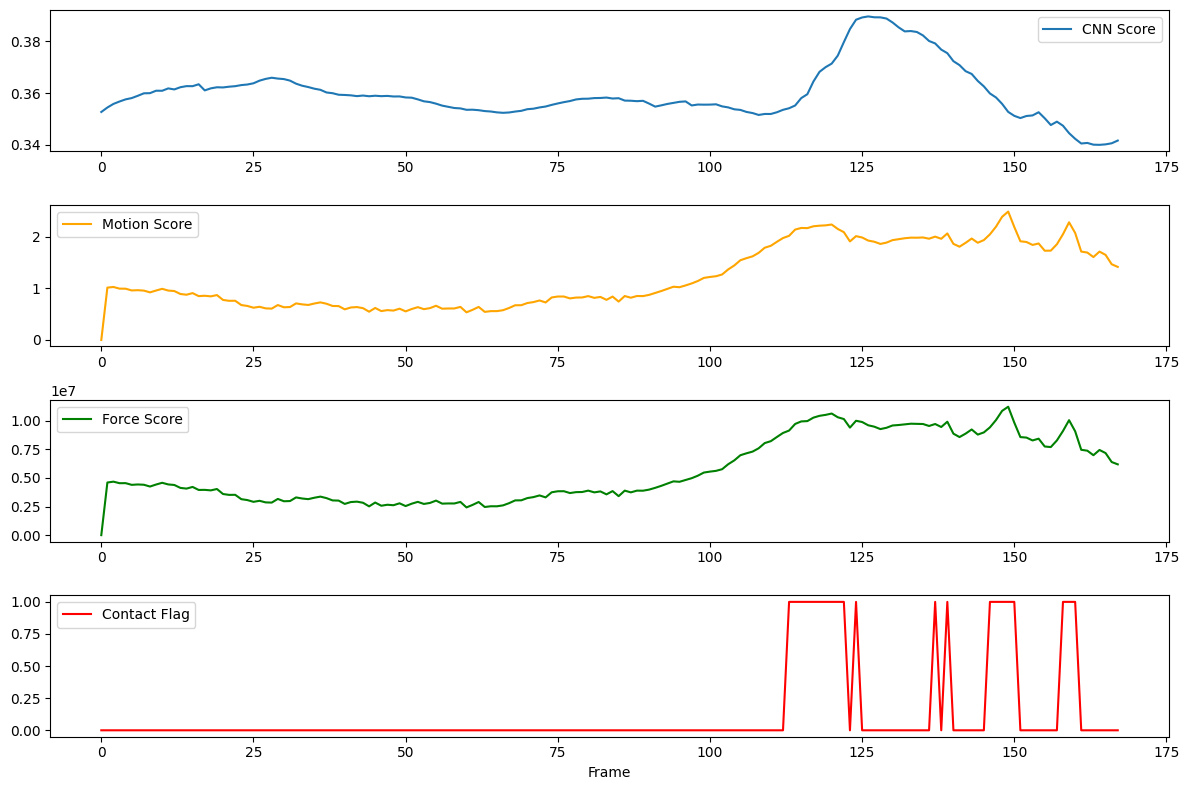

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cnn_score = []
    motion_score = []
    force_score = []
    contact_flag = []

    # --- Parameters ---
    prev_gray = None
    force_scale = 1e5
    contact_threshold = 50       # intensity threshold
    motion_threshold = 2.0       # motion threshold

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # -------------------------------
        # CNN score (placeholder: mean intensity)
        cnn_val = np.mean(gray) / 255.0 * 2.0  # normalized to ~0–2
        cnn_score.append(cnn_val)

        # -------------------------------
        # Motion score (optical flow magnitude)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            motion_val = np.mean(mag)
        else:
            motion_val = 0.0
        motion_score.append(motion_val)

        # -------------------------------
        # Force score (proxy: motion * intensity)
        force_val = motion_val * np.mean(gray) * force_scale
        force_score.append(force_val)

        # -------------------------------
        # Contact flag (motion OR intensity)
        if (motion_val > motion_threshold) or (np.mean(gray) > contact_threshold):
            contact_val = 1
        else:
            contact_val = 0
        contact_flag.append(contact_val)

        prev_gray = gray

    cap.release()

    # Convert to numpy arrays
    cnn_score = np.array(cnn_score)
    motion_score = np.array(motion_score)
    force_score = np.array(force_score)
    contact_flag = np.array(contact_flag)

    return cnn_score, motion_score, force_score, contact_flag, fps


# ============================================================
# Example usage
# ============================================================
video_path = "/content/Chain_Snatching157.mp4"
cnn_score, motion_score, force_score, contact_flag, fps = process_video(video_path)

print("Frames:", len(cnn_score))
print("\nCNN Score array:\n", cnn_score)
print("\nMotion Score array:\n", motion_score)
print("\nForce Score array:\n", force_score)
print("\nContact Flag array:\n", contact_flag)

# ============================================================
# Optional: Plot signals for visualization
# ============================================================
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(cnn_score, label="CNN Score")
plt.legend()

plt.subplot(4,1,2)
plt.plot(motion_score, label="Motion Score", color="orange")
plt.legend()

plt.subplot(4,1,3)
plt.plot(force_score, label="Force Score", color="green")
plt.legend()

plt.subplot(4,1,4)
plt.plot(contact_flag, label="Contact Flag", color="red")
plt.legend()

plt.xlabel("Frame")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER (TUNED THRESHOLDS)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,  # start detection threshold
    off_threshold=1.9,          # end detection threshold
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10
):
    cnn_score = np.array(cnn_score, dtype=float)
    motion_score = np.array(motion_score, dtype=float)
    force_score = np.array(force_score, dtype=float)
    contact_flag = np.array(contact_flag, dtype=int)

    T = len(cnn_score)
    if not all(len(arr) == T for arr in [motion_score, force_score, contact_flag]):
        raise ValueError("All input arrays must have the same length")

    # normalize force internally
    force_norm = force_score / np.max(force_score)

    smoothed_confidence = np.zeros(T)
    frame_score = np.zeros(T)

    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # EVENT DETECTION
    min_frames = int(min_duration_seconds * fps)
    events = []

    in_event = False
    start = 0
    last_contact = -999

    for t in range(warm_up_frames, T):
        if contact_flag[t] == 1:
            last_contact = t

        if not in_event and smoothed_confidence[t] >= confidence_threshold:
            in_event = True
            start = t

        elif in_event:
            if smoothed_confidence[t] < off_threshold and (t - last_contact) > contact_grace_frames:
                end = t - 1
                duration_frames = end - start + 1
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False

    if in_event:
        end = T - 1
        duration_frames = end - start + 1
        if duration_frames >= min_frames:
            events.append((start, end, duration_frames / fps))

    return smoothed_confidence, events


# ============================================================
# YOUR ORIGINAL ARRAYS
# ============================================================
cnn_score = np.array([
1.4183,1.4384,1.456,1.4199,1.3941,1.3916,1.3882,1.4507,1.4731,1.4588,
1.452,1.4557,1.4657,1.4513,1.3996,1.4124,1.4469,1.4437,1.4486,1.4761,
1.4935,1.4772,1.4918,1.4921,1.5148,1.4868,1.4942,1.4276,1.4452,1.4449,
1.4329,1.413,1.373,1.39,1.3948,1.3933,1.3882,1.3953,1.355,1.261,
1.2511,1.25,1.2894,1.3178,1.2356,1.2454,1.5922,1.5931,1.6065,1.5972,
1.642,1.5899,1.6379,1.6384,1.6859,1.6633,1.6642,1.6887,1.7046,1.7057,
1.6631,1.622,1.6142,1.4752,1.4635,1.4638,1.4814,1.3594,1.3669,1.3525,
1.3965,1.3978,1.4624,1.3505,1.3793,1.5473,1.562,1.5611,1.6319,1.8173,
1.7141,1.7654,1.6804,1.6812,1.5208,1.5859,1.5201,1.5074,1.4835,1.4793,
1.7058,1.6013,1.6182,1.5659,1.5708,1.5705,1.5867,1.6584,1.6229,1.6619,
1.6648,1.6649,1.6987,1.7174,1.8027
])

motion_score = np.array([
0.0021474,0.43398,0.28267,0.25799,0.26598,0.0032698,0.27491,0.47324,0.25865,0.30393,
0.2746,0.0033425,0.28285,0.47871,0.22842,0.24341,0.20682,0.0043605,0.22265,0.35232,
0.21651,0.22539,0.19886,0.0011538,0.17526,0.13189,0.036082,0.10247,0.1135,0.006664,
0.22246,0.49837,0.29382,0.28288,0.29836,0.0010684,0.24403,0.39493,0.1626,0.24699,
0.12705,0.0013755,0.15981,0.19822,0.095484,0.094314,0.2593,0.0013857,0.11776,0.29625,
0.14914,0.33266,0.1769,0.0012934,0.41145,0.33141,0.18698,0.35986,0.48027,0.008172,
0.17095,0.42221,0.16119,0.44128,0.67632,0.0022343,0.15079,0.45653,0.23336,0.2307,
0.25053,0.002592,0.42264,0.76973,0.22211,0.18575,0.26354,0.0018889,0.4792,0.39154,
0.24812,0.348,0.33854,0.0030335,0.45737,0.60924,0.17721,0.25331,0.19361,0.0051654,
0.25975,0.28851,0.19069,0.1587,0.077962,0.0010182,0.11345,0.048504,0.066338,0.086588,
0.068839,0.0017424,0.18056,0.15632,0.16139
])

force_score = np.array([
2.1474e-09,4.3398e-07,2.8267e-07,2.5799e-07,42382,521.03,43805,75407,41214,49480,
44704,544.16,46048,77934,73401,78217,66461,1401.2,71545,107310,65945,68651,60570,
351.43,58605,44102,12065,34264,37953,800.38,26718,59857,35289,33976,51189,183.3,
41867,67756,27897,53095,27312,295.68,34354,42611,14469,14292,39293,209.99,17846,
71976,36234,80824,42979,314.25,123340,99347,56052,107880,143970,1172.1,24519,
60555,23118,63290,135270,446.88,30159,91310,46673,46779,50799,525.58,85698,
156080,93797,78440,111290,797.67,202360,91460,57957,81290,79081,708.59,84650,
112760,32798,46883,35834,770.42,38742,43032,28442,23670,14948,195.23,21752,
9299.9,12719,19659,15629,395.61,40994,35491,40117
])

contact_flag = np.array([
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

# ============================================================
# RUN
# ============================================================
smoothed_confidence, events = event_temporal_consistency_engineer(
    cnn_score, motion_score, force_score, contact_flag
)

print("Total Frames:", len(cnn_score))

if not events:
    print("❌ No snatching detected")
else:
    print("✅ Detected Snatching Events:")
    for i, (s, e, d) in enumerate(events, 1):
        print(f"Event {i}: Start = {s}, End = {e}, Duration = {d:.2f} sec")

print("\nSmoothed Confidence Values:")
print(np.round(smoothed_confidence, 3))

Total Frames: 105
✅ Detected Snatching Events:
Event 1: Start = 46, End = 70, Duration = 0.83 sec
Event 2: Start = 72, End = 88, Duration = 0.57 sec

Smoothed Confidence Values:
[       1.42       1.556       1.611       1.631       1.703       1.611       1.692       1.873       1.892       1.926       1.933       1.791       1.847       1.987       1.988       2.005       1.998       1.835       1.892       2.032       2.033       2.036       2.022       1.864       1.899        1.88
       1.793       1.765       1.759       1.668       1.704       1.855       1.851       1.848       1.877       1.733       1.765       1.873       1.808       1.796       1.711       1.574       1.587       1.629       1.561       1.516       1.975       2.161       2.356       2.324       2.218       2.249
       2.183        2.02       2.226       2.304       2.251        2.35       2.514       2.276        2.18       2.229       2.127       2.158       2.353       2.087       1.996       2.077    

In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Grouped Frame Averaging to fix OFF hysteresis)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=3.8,
    off_threshold=3.7,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # --- Normalize force safely ---
    force_norm = force_score / np.max(force_score) if np.max(force_score) != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # --- Frame confidence ---
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING (ANTI-HYSTERESIS CORE)
    # ============================================================
    grouped_confidence = np.zeros(T)

    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i+group_size])
        grouped_confidence[i:i+group_size] = avg

    # ============================================================
    # EVENT DETECTION USING GROUP CONFIDENCE
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    events = []

    in_event = False
    start = 0
    last_contact = -999

    for t in range(warm_up_frames, T):
        if contact_flag[t] == 1:
            last_contact = t

        if not in_event and grouped_confidence[t] >= confidence_threshold:
            in_event = True
            start = t

        elif in_event:
            if (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1

                if duration >= min_frames:
                    events.append((start, end, duration / fps))

                in_event = False

    if in_event:
        end = T - 1
        duration = end - start + 1
        if duration >= min_frames:
            events.append((start, end, duration / fps))

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# YOUR ARRAYS (USED AS-IS, NOT MODIFIED)
# ============================================================

cnn_score = np.array([
1.9888, 2.0405, 2.0214, 2.0249, 1.989, 1.9871, 1.9159, 1.9167, 1.9045, 1.9051, 1.9091, 1.9076, 1.9131, 1.9126, 1.922, 1.915, 1.9146, 1.9138, 1.9457, 1.9387, 1.9354, 1.9362, 1.9079, 1.9112, 1.9164, 1.9177, 1.9121, 1.8479, 1.8491, 1.8426, 1.8941, 1.8923, 1.8989, 1.8955, 1.9113, 1.908, 1.9075, 1.8907, 1.8946, 1.8933, 1.9327, 1.9298, 1.8966, 1.8912, 1.9064, 1.9089, 1.9096, 1.9169, 1.9134, 1.9191, 1.8888, 1.8916, 1.8867, 1.8873, 1.8903, 1.808, 1.8089, 1.7878, 1.7847, 1.7774, 1.814, 1.8165, 1.848, 1.8445, 1.8439, 1.8378, 1.8418, 1.8673, 1.8742, 1.804, 1.8031, 1.8063, 1.8292, 1.8322, 1.8317, 1.8693, 1.8695, 1.8706, 1.8692, 1.8716, 1.8311, 1.8121, 1.8091, 1.8091, 1.7086, 1.7043, 1.7094, 1.836, 1.8369, 1.969, 1.9698, 1.979, 1.9147, 1.9222, 1.9191, 1.9209, 1.8621, 1.86, 1.8595, 1.8658, 1.8334, 1.8341, 1.9092, 1.9173, 1.9229, 1.8782, 1.8796, 1.858, 1.8605, 1.92, 1.9141, 1.8661, 1.8704, 1.8809, 1.8769, 1.7976, 1.948, 1.9538, 1.9546, 1.9667, 1.9673, 1.9735, 1.8682, 1.8657, 1.7035, 1.7056, 1.7104, 1.8718, 1.8683, 1.9326, 1.9344, 1.9416, 1.8235, 1.8227, 1.7646, 1.7667, 1.7778, 1.7584, 1.7587, 1.8194, 1.8207, 1.8262, 1.9341, 1.9322, 1.9427, 1.9133, 1.9124, 1.8792, 1.8814, 1.8852, 1.8139, 1.8121, 1.8457, 1.8488, 1.8457, 1.7588, 1.7532, 1.8477, 1.8489, 1.8493, 1.8746, 1.9489, 1.9485, 1.9499, 2.0379, 2.0381, 2.036, 1.8758, 1.879, 1.8607, 1.8591, 1.8549, 1.7398, 1.7416, 1.7247, 1.7234, 1.7233, 1.6741, 1.6741, 1.6752, 1.7255, 1.7224, 1.8003, 1.8006, 1.801, 1.8316, 1.8478, 1.8511, 1.8402, 1.9175
])

motion_score = np.array([
0.044014, 0.66953, 0.057204, 0.072052, 0.64338, 0.036688, 0.75621, 0.036204, 0.36781, 0.030719, 0.042947, 0.90302, 0.031811, 0.035239, 1.3358, 0.049225, 1.3063, 0.026312, 1.2743, 0.040773, 0.041641, 0.028649, 1.1605, 0.023583, 1.1884, 0.014694, 0.035889, 1.2496, 0.014296, 0.027403, 1.2285, 0.015073, 1.2041, 0.024847, 1.2073, 0.024104, 0.032714, 1.176, 0.018134, 0.029098, 1.1819, 0.019188, 1.1379, 0.023443, 1.185, 0.014197, 0.023162, 1.1793, 0.01992, 0.026882, 1.1569, 0.021427, 1.1848, 0.016596, 0.021813, 1.1643, 0.019183, 1.1634, 0.021395, 0.032793, 1.1889, 0.022149, 1.165, 0.080452, 0.053305, 1.1785, 0.03839, 1.19, 0.041952, 1.1544, 0.040044, 0.045386, 1.1609, 0.044526, 0.078554, 1.1089, 0.011066, 1.1345, 0.01764, 0.02221, 1.1498, 1.2448, 0.020379, 0.022766, 1.0948, 0.017979, 0.023636, 1.1865, 0.015782, 1.2527, 0.014231, 0.029137, 1.2637, 0.01403, 0.026663, 0.018852, 2.6017, 0.0098999, 0.020851, 0.028278, 1.3354, 0.0058758, 1.5144, 0.05108, 0.035854, 1.47, 0.022866, 1.5879, 0.023391, 1.6177, 0.024792, 1.6104, 0.026484, 0.032129, 0.035045, 1.5416, 1.3096, 0.024039, 0.027719, 2.0467, 0.01877, 0.019574, 1.9741, 0.0084725, 1.953, 0.017309, 0.027363, 2.1325, 0.020774, 2.3566, 0.013192, 0.028254, 2.3616, 0.015758, 1.6057, 0.022559, 0.03448, 1.7121, 0.018576, 2.0846, 0.0098056, 0.019617, 1.7565, 0.023021, 0.027654, 1.6616, 0.038295, 1.6207, 0.043242, 0.041247, 4.2225, 0.017164, 6.6541, 0.018464, 0.031267, 6.9355, 0.016098, 6.5613, 0.025544, 0.027623, 6.3425, 6.1945, 0.018268, 0.032251, 6.0501, 0.025169, 0.030605, 6.1742, 0.017223, 5.9774, 0.021174, 0.031216, 6.0698, 0.022927, 5.7498, 0.01767, 0.028798, 5.7917, 0.0035751, 0.03216, 5.8847, 0.014835, 6.0939, 0.022411, 0.030103, 5.9001, 5.7021, 0.012897, 0.043961, 5.4786, 5.7656, 0.025734, 0.030399, 0.040349, 5.642, 0.016028, 0.028073, 5.7628, 0.015987, 3.6657, 0.013238, 1.8037, 0.024608, 1.63, 0.014809, 0.034516, 0.038939, 1.4056, 0.035099, 0.46606, 0.018637, 0.69542, 0.014829, 0.012688, 0.020794, 0.83073, 0.0079859, 0.70178, 0.0070449, 5.4416, 0.0097941, 3.4734, 0.0037445, 0.015873, 1.3059, 0.012944, 0.78494, 0.010012, 0.0098071
])

force_score = np.array([
4.4014e-08, 6.6953e-07, 5.7204e-08, 7.2052e-08, 1.3347e+05, 7610.9, 1.5688e+05, 7510.5, 76303, 6393.5, 8938.6, 1.8795e+05, 6620.7, 7334.3, 2.8001e+05, 10318, 2.7381e+05, 5515.3, 2.671e+05, 8030.5, 8201.4, 5642.6, 2.2857e+05, 4644.8, 2.4031e+05, 2971.3, 7257, 2.5268e+05, 2890.8, 2720.4, 1.2196e+05, 1496.3, 1.1953e+05, 2466.6, 3.6001e+05, 7187.9, 9755.6, 3.5069e+05, 5407.5, 5574.9, 2.2643e+05, 3676.3, 2.1801e+05, 4491.5, 2.1997e+05, 2635.3, 4299.4, 2.1891e+05, 3697.7, 8230.2, 3.5418e+05, 6560.1, 3.6273e+05, 5081, 4505.3, 2.4047e+05, 3962, 2.4028e+05, 4418.8, 6538.3, 2.3704e+05, 4416.1, 2.3228e+05, 16040, 5312.2, 1.1744e+05, 3825.8, 1.186e+05, 4180.9, 1.1547e+05, 4005.2, 4539.5, 1.1611e+05, 4453.5, 8359.9, 1.1802e+05, 1177.7, 1.2074e+05, 1877.3, 2448.1, 1.2674e+05, 1.3721e+05, 2246.3, 2509.4, 1.2075e+05, 1983, 2606.9, 1.3086e+05, 1740.7, 1.4179e+05, 1610.8, 3297.9, 1.4303e+05, 1588, 3108.2, 2197.6, 3.0329e+05, 1154, 2430.6, 6030.9, 2.8479e+05, 1253.1, 3.2298e+05, 10894, 4294.2, 1.7606e+05, 2738.6, 1.9018e+05, 2801.5, 1.8617e+05, 2853.1, 1.8532e+05, 3047.7, 3697.4, 4533.8, 1.9944e+05, 1.6942e+05, 3110, 3586.1, 2.7771e+05, 2546.8, 2655.9, 2.6786e+05, 1149.6, 2.4307e+05, 2154.2, 3405.6, 2.6541e+05, 2585.5, 2.8152e+05, 1575.9, 3375.1, 2.8212e+05, 1882.4, 1.4824e+05, 2082.7, 3183.3, 1.5807e+05, 1715, 1.8515e+05, 870.92, 1742.4, 1.5601e+05, 2044.6, 2406.2, 1.4457e+05, 3332.1, 1.4102e+05, 3762.5, 2932.6, 3.0021e+05, 1220.3, 4.7309e+05, 1312.7, 2619.9, 5.8115e+05, 1348.9, 5.4979e+05, 2140.4, 1581.7, 3.6318e+05, 3.547e+05, 1046, 1846.7, 9.7415e+05, 4052.6, 4927.9, 9.9413e+05, 2773.1, 2.9644e+05, 1050.1, 1548.1, 3.0102e+05, 1137, 2.1392e+06, 6574.2, 10714, 2.1548e+06, 1330.1, 1747, 3.1966e+05, 805.82, 3.3102e+05, 1217.4, 2487.2, 4.8748e+05, 4.7112e+05, 1065.6, 3632.1, 9.6576e+05, 1.0164e+06, 4536.3, 5358.6, 7112.7, 12994, 36.914, 64.652, 13272, 36.818
])

contact_flags = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
])

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

print("Total Frames:", len(cnn_score))
print("\nGrouped Confidence:")
print(np.round(grouped_conf, 3))

if not events:
    print("\n❌ No suspicious event detected")
else:
    print("\n✅ Detected Events:")
    for i, (s, e, d) in enumerate(events, 1):
        print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")


Total Frames: 190

Grouped Confidence:
[      3.188       3.188       3.188       3.188       3.188       2.653       2.653       2.653       2.653       2.653       2.333       2.333       2.333       2.333       2.333        2.54        2.54        2.54        2.54        2.54       3.017       3.017       3.017       3.017       3.017       3.289
       3.289       3.289       3.289       3.289       3.471       3.471       3.471       3.471       3.471       3.379       3.379       3.379       3.379       3.379         3.5         3.5         3.5         3.5         3.5        3.37        3.37        3.37        3.37        3.37        3.43        3.43
        3.43        3.43        3.43       3.363       3.363       3.363       3.363       3.363       3.359       3.359       3.359       3.359       3.359       3.441       3.441       3.441       3.441       3.441       3.285       3.285       3.285       3.285       3.285       3.341       3.341       3.341
       3.341       3.3

In [ ]:
!python --version


Python 3.12.12


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=3.8,
    off_threshold=3.7,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    force_norm = force_score / np.max(force_score) if np.max(force_score) != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 25   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# YOUR ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([
1.9888,2.0405,2.0214,2.0249,1.989,1.9871,1.9159,1.9167,1.9045,1.9051,
1.9091,1.9076,1.9131,1.9126,1.922,1.915,1.9146,1.9138,1.9457,1.9387,
1.9354,1.9362,1.9079,1.9112,1.9164,1.9177,1.9121,1.8479,1.8491,1.8426,
1.8941,1.8923,1.8989,1.8955,1.9113,1.908,1.9075,1.8907,1.8946,1.8933,
1.9327,1.9298,1.8966,1.8912,1.9064,1.9089,1.9096,1.9169,1.9134,1.9191,
1.8888,1.8916,1.8867,1.8873,1.8903,1.808,1.8089,1.7878,1.7847,1.7774,
1.814,1.8165,1.848,1.8445,1.8439,1.8378,1.8418,1.8673,1.8742,1.804,
1.8031,1.8063,1.8292,1.8322,1.8317,1.8693,1.8695,1.8706,1.8692,1.8716,
1.8311,1.8121,1.8091,1.8091,1.7086,1.7043,1.7094,1.836,1.8369,1.969,
1.9698,1.979,1.9147,1.9222,1.9191,1.9209,1.8621,1.86,1.8595,1.8658,
1.8334,1.8341,1.9092,1.9173,1.9229,1.8782,1.8796,1.858,1.8605,1.92,
1.9141,1.8661,1.8704,1.8809,1.8769,1.7976,1.948,1.9538,1.9546,1.9667,
1.9673,1.9735,1.8682,1.8657,1.7035,1.7056,1.7104,1.8718,1.8683,1.9326,
1.9344,1.9416,1.8235,1.8227,1.7646,1.7667,1.7778,1.7584,1.7587,1.8194,
1.8207,1.8262,1.9341,1.9322,1.9427,1.9133,1.9124,1.8792,1.8814,1.8852,
1.8139,1.8121,1.8457,1.8488,1.8457,1.7588,1.7532,1.8477,1.8489,1.8493,
1.8746,1.9489,1.9485,1.9499,2.0379,2.0381,2.036,1.8758,1.879,1.8607,
1.8591,1.8549,1.7398,1.7416,1.7247,1.7234,1.7233,1.6741,1.6741,1.6752,
1.7255,1.7224,1.8003,1.8006,1.801,1.8316,1.8478,1.8511,1.8402,1.9175
])

motion_score = np.array([
0.044014,0.66953,0.057204,0.072052,0.64338,0.036688,0.75621,0.036204,0.36781,0.030719,
0.042947,0.90302,0.031811,0.035239,1.3358,0.049225,1.3063,0.026312,1.2743,0.040773,
0.041641,0.028649,1.1605,0.023583,1.1884,0.014694,0.035889,1.2496,0.014296,0.027403,
1.2285,0.015073,1.2041,0.024847,1.2073,0.024104,0.032714,1.176,0.018134,0.029098,
1.1819,0.019188,1.1379,0.023443,1.185,0.014197,0.023162,1.1793,0.01992,0.026882,
1.1569,0.021427,1.1848,0.016596,0.021813,1.1643,0.019183,1.1634,0.021395,0.032793,
1.1889,0.022149,1.165,0.080452,0.053305,1.1785,0.03839,1.19,0.041952,1.1544,
0.040044,0.045386,1.1609,0.044526,0.078554,1.1089,0.011066,1.1345,0.01764,0.02221,
1.1498,1.2448,0.020379,0.022766,1.0948,0.017979,0.023636,1.1865,0.015782,1.2527,
0.014231,0.029137,1.2637,0.01403,0.026663,0.018852,2.6017,0.0098999,0.020851,0.028278,
1.3354,0.0058758,1.5144,0.05108,0.035854,1.47,0.022866,1.5879,0.023391,1.6177,
0.024792,1.6104,0.026484,0.032129,0.035045,1.5416,1.3096,0.024039,0.027719,2.0467,
0.01877,0.019574,1.9741,0.0084725,1.953,0.017309,0.027363,2.1325,0.020774,2.3566,
0.013192,0.028254,2.3616,0.015758,1.6057,0.022559,0.03448,1.7121,0.018576,2.0846,
0.0098056,0.019617,1.7565,0.023021,0.027654,1.6616,0.038295,1.6207,0.043242,
0.041247,4.2225,0.017164,6.6541,0.018464,0.031267,6.9355,0.016098,6.5613,0.025544,
0.027623,6.3425,6.1945,0.018268,0.032251,6.0501,0.025169,0.030605,6.1742,0.017223,
5.9774,0.021174,0.031216,6.0698,0.022927,5.7498,0.01767,0.028798,5.7917,0.0035751,
0.03216,5.8847,0.014835,6.0939,0.022411,0.030103,5.9001,5.7021,0.012897,0.043961,
5.4786,5.7656,0.025734,0.030399,0.040349,5.642,0.016028,0.028073,5.7628,0.015987,
3.6657,0.013238,1.8037,0.024608,1.63,0.014809,0.034516,0.038939,1.4056,0.035099,
0.46606,0.018637,0.69542,0.014829,0.012688,0.020794,0.83073,0.0079859,0.70178,
0.0070449,5.4416,0.0097941,3.4734,0.0037445,0.015873,1.3059,0.012944,0.78494,
0.010012,0.0098071
])

force_score = np.array([
4.4014e-08,6.6953e-07,5.7204e-08,7.2052e-08,1.3347e+05,7610.9,1.5688e+05,7510.5,76303,
6393.5,8938.6,1.8795e+05,6620.7,7334.3,2.8001e+05,10318,2.7381e+05,5515.3,2.671e+05,
8030.5,8201.4,5642.6,2.2857e+05,4644.8,2.4031e+05,2971.3,7257,2.5268e+05,2890.8,2720.4,
1.2196e+05,1496.3,1.1953e+05,2466.6,3.6001e+05,7187.9,9755.6,3.5069e+05,5407.5,5574.9,
2.2643e+05,3676.3,2.1801e+05,4491.5,2.1997e+05,2635.3,4299.4,2.1891e+05,3697.7,8230.2,
3.5418e+05,6560.1,3.6273e+05,5081,4505.3,2.4047e+05,3962,2.4028e+05,4418.8,6538.3,
2.3704e+05,4416.1,2.3228e+05,16040,5312.2,1.1744e+05,3825.8,1.186e+05,4180.9,1.1547e+05,
4005.2,4539.5,1.1611e+05,4453.5,8359.9,1.1802e+05,1177.7,1.2074e+05,1877.3,2448.1,
1.2674e+05,1.3721e+05,2246.3,2509.4,1.2075e+05,1983,2606.9,1.3086e+05,1740.7,1.4179e+05,
1610.8,3297.9,1.4303e+05,1588,3108.2,2197.6,3.0329e+05,1154,2430.6,6030.9,2.8479e+05,
1253.1,3.2298e+05,10894,4294.2,1.7606e+05,2738.6,1.9018e+05,2801.5,1.8617e+05,2853.1,
1.8532e+05,3047.7,3697.4,4533.8,1.9944e+05,1.6942e+05,3110,3586.1,2.7771e+05,2546.8,
2655.9,2.6786e+05,1149.6,2.4307e+05,2154.2,3405.6,2.6541e+05,2585.5,2.8152e+05,
1575.9,3375.1,2.8212e+05,1882.4,1.4824e+05,2082.7,3183.3,1.5807e+05,1715,1.8515e+05,
870.92,1742.4,1.5601e+05,2044.6,2406.2,1.4457e+05,3332.1,1.4102e+05,3762.5,2932.6,
3.0021e+05,1220.3,4.7309e+05,1312.7,2619.9,5.8115e+05,1348.9,5.4979e+05,2140.4,1581.7,
3.6318e+05,3.547e+05,1046,1846.7,9.7415e+05,4052.6,4927.9,9.9413e+05,2773.1,2.9644e+05,
1050.1,1548.1,3.0102e+05,1137,2.1392e+06,6574.2,10714,2.1548e+06,1330.1,1747,
3.1966e+05,805.82,3.3102e+05,1217.4,2487.2,4.8748e+05,4.7112e+05,1065.6,3632.1,
9.6576e+05,1.0164e+06,4536.3,5358.6,7112.7,12994,36.914,64.652,13272,36.818
])

contact_flags = np.ones(len(cnn_score), dtype=int)

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

print("Total Frames:", len(cnn_score))
print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")


Total Frames: 190

Detected Events:
Event 1: Start=150, End=174, Duration=0.83s


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=3.8,
    off_threshold=3.7,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 25

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([
1.9888,2.0405,2.0214,2.0249,1.989,1.9871,1.9159,1.9167,1.9045,1.9051,
1.9091,1.9076,1.9131,1.9126,1.922,1.915,1.9146,1.9138,1.9457,1.9387,
1.9354,1.9362,1.9079,1.9112,1.9164,1.9177,1.9121,1.8479,1.8491,1.8426,
1.8941,1.8923,1.8989,1.8955,1.9113,1.908,1.9075,1.8907,1.8946,1.8933,
1.9327,1.9298,1.8966,1.8912,1.9064,1.9089,1.9096,1.9169,1.9134,1.9191,
1.8888,1.8916,1.8867,1.8873,1.8903,1.808,1.8089,1.7878,1.7847,1.7774,
1.814,1.8165,1.848,1.8445,1.8439,1.8378,1.8418,1.8673,1.8742,1.804,
1.8031,1.8063,1.8292,1.8322,1.8317,1.8693,1.8695,1.8706,1.8692,1.8716,
1.8311,1.8121,1.8091,1.8091,1.7086,1.7043,1.7094,1.836,1.8369,1.969,
1.9698,1.979,1.9147,1.9222,1.9191,1.9209,1.8621,1.86,1.8595,1.8658,
1.8334,1.8341,1.9092,1.9173,1.9229,1.8782,1.8796,1.858,1.8605,1.92,
1.9141,1.8661,1.8704,1.8809,1.8769,1.7976,1.948,1.9538,1.9546,1.9667,
1.9673,1.9735,1.8682,1.8657,1.7035,1.7056,1.7104,1.8718,1.8683,1.9326,
1.9344,1.9416,1.8235,1.8227,1.7646,1.7667,1.7778,1.7584,1.7587,1.8194,
1.8207,1.8262,1.9341,1.9322,1.9427,1.9133,1.9124,1.8792,1.8814,1.8852,
1.8139,1.8121,1.8457,1.8488,1.8457,1.7588,1.7532,1.8477,1.8489,1.8493,
1.8746,1.9489,1.9485,1.9499,2.0379,2.0381,2.036,1.8758,1.879,1.8607,
1.8591,1.8549,1.7398,1.7416,1.7247,1.7234,1.7233,1.6741,1.6741,1.6752,
1.7255,1.7224,1.8003,1.8006,1.801,1.8316,1.8478,1.8511,1.8402,1.9175
])

motion_score = np.array([
0.044014,0.66953,0.057204,0.072052,0.64338,0.036688,0.75621,0.036204,0.36781,0.030719,
0.042947,0.90302,0.031811,0.035239,1.3358,0.049225,1.3063,0.026312,1.2743,0.040773,
0.041641,0.028649,1.1605,0.023583,1.1884,0.014694,0.035889,1.2496,0.014296,0.027403,
1.2285,0.015073,1.2041,0.024847,1.2073,0.024104,0.032714,1.176,0.018134,0.029098,
1.1819,0.019188,1.1379,0.023443,1.185,0.014197,0.023162,1.1793,0.01992,0.026882,
1.1569,0.021427,1.1848,0.016596,0.021813,1.1643,0.019183,1.1634,0.021395,0.032793,
1.1889,0.022149,1.165,0.080452,0.053305,1.1785,0.03839,1.19,0.041952,1.1544,
0.040044,0.045386,1.1609,0.044526,0.078554,1.1089,0.011066,1.1345,0.01764,0.02221,
1.1498,1.2448,0.020379,0.022766,1.0948,0.017979,0.023636,1.1865,0.015782,1.2527,
0.014231,0.029137,1.2637,0.01403,0.026663,0.018852,2.6017,0.0098999,0.020851,0.028278,
1.3354,0.0058758,1.5144,0.05108,0.035854,1.47,0.022866,1.5879,0.023391,1.6177,
0.024792,1.6104,0.026484,0.032129,0.035045,1.5416,1.3096,0.024039,0.027719,2.0467,
0.01877,0.019574,1.9741,0.0084725,1.953,0.017309,0.027363,2.1325,0.020774,2.3566,
0.013192,0.028254,2.3616,0.015758,1.6057,0.022559,0.03448,1.7121,0.018576,2.0846,
0.0098056,0.019617,1.7565,0.023021,0.027654,1.6616,0.038295,1.6207,0.043242,
0.041247,4.2225,0.017164,6.6541,0.018464,0.031267,6.9355,0.016098,6.5613,0.025544,
0.027623,6.3425,6.1945,0.018268,0.032251,6.0501,0.025169,0.030605,6.1742,0.017223,
5.9774,0.021174,0.031216,6.0698,0.022927,5.7498,0.01767,0.028798,5.7917,0.0035751,
0.03216,5.8847,0.014835,6.0939,0.022411,0.030103,5.9001,5.7021,0.012897,0.043961,
5.4786,5.7656,0.025734,0.030399,0.040349,5.642,0.016028,0.028073,5.7628,0.015987,
3.6657,0.013238,1.8037,0.024608,1.63,0.014809,0.034516,0.038939,1.4056,0.035099,
0.46606,0.018637,0.69542,0.014829,0.012688,0.020794,0.83073,0.0079859,0.70178,
0.0070449,5.4416,0.0097941,3.4734,0.0037445,0.015873,1.3059,0.012944,0.78494,
0.010012,0.0098071
])

force_score = np.array([
4.4014e-08,6.6953e-07,5.7204e-08,7.2052e-08,1.3347e+05,7610.9,1.5688e+05,7510.5,76303,
6393.5,8938.6,1.8795e+05,6620.7,7334.3,2.8001e+05,10318,2.7381e+05,5515.3,2.671e+05,
8030.5,8201.4,5642.6,2.2857e+05,4644.8,2.4031e+05,2971.3,7257,2.5268e+05,2890.8,2720.4,
1.2196e+05,1496.3,1.1953e+05,2466.6,3.6001e+05,7187.9,9755.6,3.5069e+05,5407.5,5574.9,
2.2643e+05,3676.3,2.1801e+05,4491.5,2.1997e+05,2635.3,4299.4,2.1891e+05,3697.7,8230.2,
3.5418e+05,6560.1,3.6273e+05,5081,4505.3,2.4047e+05,3962,2.4028e+05,4418.8,6538.3,
2.3704e+05,4416.1,2.3228e+05,16040,5312.2,1.1744e+05,3825.8,1.186e+05,4180.9,1.1547e+05,
4005.2,4539.5,1.1611e+05,4453.5,8359.9,1.1802e+05,1177.7,1.2074e+05,1877.3,2448.1,
1.2674e+05,1.3721e+05,2246.3,2509.4,1.2075e+05,1983,2606.9,1.3086e+05,1740.7,1.4179e+05,
1610.8,3297.9,1.4303e+05,1588,3108.2,2197.6,3.0329e+05,1154,2430.6,6030.9,2.8479e+05,
1253.1,3.2298e+05,10894,4294.2,1.7606e+05,2738.6,1.9018e+05,2801.5,1.8617e+05,2853.1,
1.8532e+05,3047.7,3697.4,4533.8,1.9944e+05,1.6942e+05,3110,3586.1,2.7771e+05,2546.8,
2655.9,2.6786e+05,1149.6,2.4307e+05,2154.2,3405.6,2.6541e+05,2585.5,2.8152e+05,
1575.9,3375.1,2.8212e+05,1882.4,1.4824e+05,2082.7,3183.3,1.5807e+05,1715,1.8515e+05,
870.92,1742.4,1.5601e+05,2044.6,2406.2,1.4457e+05,3332.1,1.4102e+05,3762.5,2932.6,
3.0021e+05,1220.3,4.7309e+05,1312.7,2619.9,5.8115e+05,1348.9,5.4979e+05,2140.4,1581.7,
3.6318e+05,3.547e+05,1046,1846.7,9.7415e+05,4052.6,4927.9,9.9413e+05,2773.1,2.9644e+05,
1050.1,1548.1,3.0102e+05,1137,2.1392e+06,6574.2,10714,2.1548e+06,1330.1,1747,
3.1966e+05,805.82,3.3102e+05,1217.4,2487.2,4.8748e+05,4.7112e+05,1065.6,3632.1,
9.6576e+05,1.0164e+06,4536.3,5358.6,7112.7,12994,36.914,64.652,13272,36.818
])

contact_flags = np.ones(len(cnn_score), dtype=int)

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 190

Detected Events:
Event 1: Start=150, End=174, Duration=0.83s

Smoothed Confidence Array:
[3.033 3.236 3.189 3.161 3.321 3.233 3.387 3.258 3.273 3.172 3.108 3.345
 3.226 3.143 3.517 3.352 3.651 3.439 3.71  3.492 3.339 3.227 3.511 3.339
 3.602 3.402 3.267 3.551 3.345 3.203 3.496 3.32  3.571 3.376 3.649 3.435
 3.288 3.57  3.374 3.239 3.533 3.359 3.592 3.389 3.63  3.419 3.273 3.551
 3.366 3.241 3.532 3.347 3.615 3.402 3.256 3.504 3.302 3.53  3.314 3.163
 3.448 3.266 3.522 3.345 3.212 3.469 3.293 3.539 3.353 3.55  3.339 3.193
 3.449 3.278 3.169 3.428 3.264 3.503 3.318 3.191 3.446 3.648 3.403 3.232
 3.42  3.211 3.068 3.373 3.217 3.538 3.372 3.263 3.558 3.372 3.244 3.153
 3.889 3.583 3.373 3.23  3.551 3.338 3.709 3.488 3.33  3.66  3.433 3.763
 3.5   3.837 3.568 3.866 3.576 3.378 3.239 3.597 3.818 3.567 3.392 3.917
 3.638 3.445 3.901 3.593 3.946 3.58  3.327 3.867 3.574 4.128 3.774 3.533
 4.068 3.699 3.921 3.582 3.352 3.709 3.43  3.898 3.578 3.358 3.78  3.533
 3.364 3.748 3.5

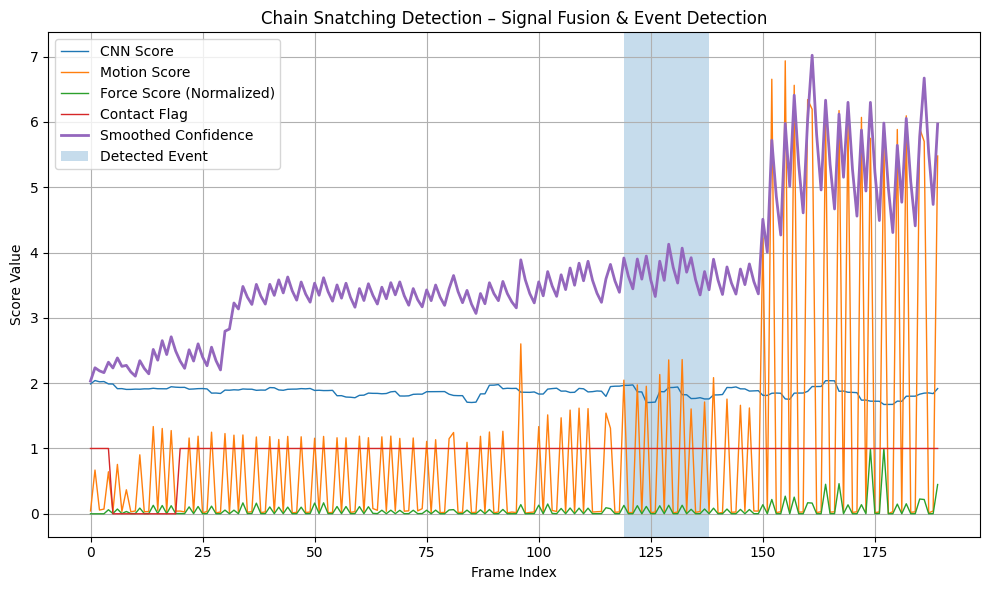

In [ ]:
import matplotlib.pyplot as plt

frames = np.arange(len(smoothed_confidence))

# Normalize force for plotting (same as logic)
force_norm = force_score[:len(smoothed_confidence)] / np.max(force_score)

plt.figure(figsize=(10, 6))

# ---------------- CNN ----------------
plt.plot(frames, cnn_score[:len(frames)], label="CNN Score", linewidth=1)

# ---------------- Motion ----------------
plt.plot(frames, motion_score[:len(frames)], label="Motion Score", linewidth=1)

# ---------------- Force (Normalized) ----------------
plt.plot(frames, force_norm, label="Force Score (Normalized)", linewidth=1)

# ---------------- Contact Flag ----------------
plt.plot(frames, contact_flags[:len(frames)], label="Contact Flag", linewidth=1)

# ---------------- Smoothed Confidence ----------------
plt.plot(frames, smoothed_confidence, label="Smoothed Confidence", linewidth=2)

# ---------------- Events Highlight ----------------
for (start, end, _) in events:
    plt.axvspan(start, end, alpha=0.25, label="Detected Event")

plt.xlabel("Frame Index")
plt.ylabel("Score Value")
plt.title("Chain Snatching Detection – Signal Fusion & Event Detection")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


Frames: 198

CNN Score array:
 [0.603 0.603 0.603 0.603 0.603 0.603 0.6   0.6   0.602 0.602 0.602 0.602
 0.603 0.603 0.603 0.603 0.6   0.6   0.603 0.603 0.603 0.603 0.601 0.601
 0.602 0.602 0.601 0.601 0.601 0.601 0.601 0.601 0.597 0.597 0.601 0.601
 0.601 0.601 0.599 0.599 0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.6
 0.597 0.597 0.601 0.601 0.601 0.601 0.599 0.599 0.598 0.598 0.599 0.599
 0.602 0.602 0.599 0.599 0.599 0.599 0.602 0.602 0.602 0.602 0.601 0.601
 0.598 0.598 0.598 0.598 0.602 0.602 0.602 0.602 0.602 0.602 0.604 0.604
 0.604 0.604 0.604 0.604 0.6   0.6   0.601 0.601 0.605 0.605 0.603 0.603
 0.603 0.603 0.602 0.602 0.602 0.602 0.603 0.603 0.598 0.598 0.598 0.598
 0.602 0.602 0.601 0.601 0.601 0.601 0.6   0.6   0.602 0.602 0.602 0.602
 0.597 0.597 0.598 0.598 0.6   0.6   0.598 0.598 0.598 0.598 0.595 0.595
 0.597 0.597 0.597 0.597 0.594 0.594 0.597 0.597 0.604 0.604 0.606 0.606
 0.606 0.606 0.603 0.603 0.608 0.608 0.608 0.608 0.604 0.604 0.604 0.604
 0.6   0.6   0.599 0.5

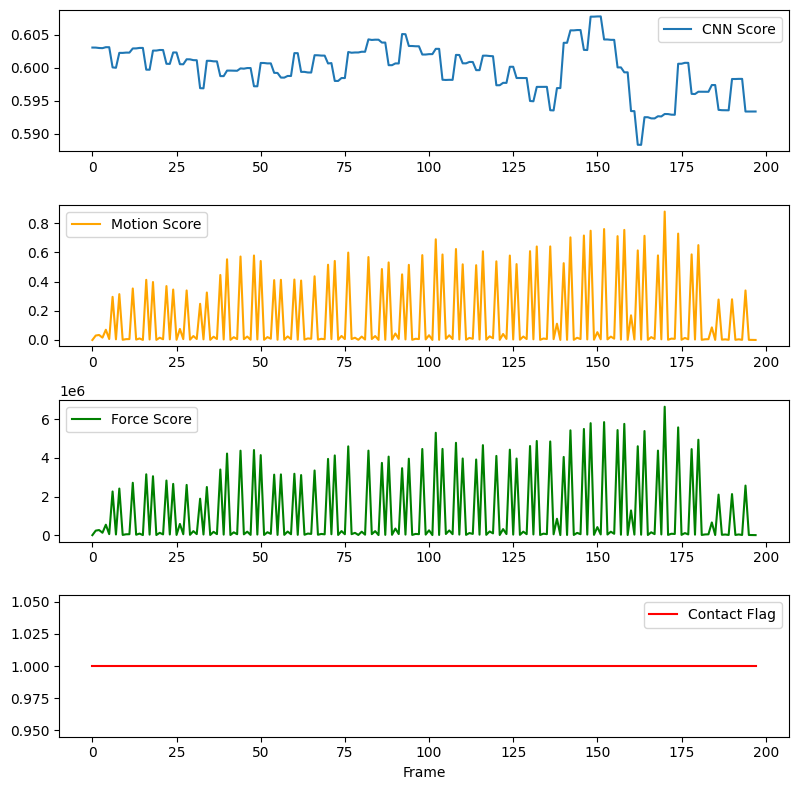

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cnn_score = []
    motion_score = []
    force_score = []
    contact_flag = []

    # --- Parameters ---
    prev_gray = None
    force_scale = 1e5
    contact_threshold = 50       # intensity threshold
    motion_threshold = 2.0       # motion threshold

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # -------------------------------
        # CNN score (placeholder: mean intensity)
        cnn_val = np.mean(gray) / 255.0 * 2.0  # normalized to ~0–2
        cnn_score.append(cnn_val)

        # -------------------------------
        # Motion score (optical flow magnitude)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            motion_val = np.mean(mag)
        else:
            motion_val = 0.0
        motion_score.append(motion_val)

        # -------------------------------
        # Force score (proxy: motion * intensity)
        force_val = motion_val * np.mean(gray) * force_scale
        force_score.append(force_val)

        # -------------------------------
        # Contact flag (motion OR intensity)
        if (motion_val > motion_threshold) or (np.mean(gray) > contact_threshold):
            contact_val = 1
        else:
            contact_val = 0
        contact_flag.append(contact_val)

        prev_gray = gray

    cap.release()

    # Convert to numpy arrays
    cnn_score = np.array(cnn_score)
    motion_score = np.array(motion_score)
    force_score = np.array(force_score)
    contact_flag = np.array(contact_flag)

    return cnn_score, motion_score, force_score, contact_flag, fps


# ============================================================
# Example usage
# ============================================================
video_path = "/content/Chain_Snatching05.mp4"
cnn_score, motion_score, force_score, contact_flag, fps = process_video(video_path)

print("Frames:", len(cnn_score))
print("\nCNN Score array:\n", cnn_score)
print("\nMotion Score array:\n", motion_score)
print("\nForce Score array:\n", force_score)
print("\nContact Flag array:\n", contact_flag)

# ============================================================
# Optional: Plot signals for visualization
# ============================================================
plt.figure(figsize=(8,8))
plt.subplot(4,1,1)
plt.plot(cnn_score, label="CNN Score")
plt.legend()

plt.subplot(4,1,2)
plt.plot(motion_score, label="Motion Score", color="orange")
plt.legend()

plt.subplot(4,1,3)
plt.plot(force_score, label="Force Score", color="green")
plt.legend()

plt.subplot(4,1,4)
plt.plot(contact_flag, label="Contact Flag", color="red")
plt.legend()

plt.xlabel("Frame")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.0,
    off_threshold=1.85,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([
0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.6, 0.6, 0.602, 0.602, 0.602, 0.602,
0.603, 0.603, 0.603, 0.603, 0.6, 0.6, 0.603, 0.603, 0.603, 0.603, 0.601, 0.601,
0.602, 0.602, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.597, 0.597, 0.601, 0.601,
0.601, 0.601, 0.599, 0.599, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
0.597, 0.597, 0.601, 0.601, 0.601, 0.601, 0.599, 0.599, 0.598, 0.598, 0.599, 0.599,
0.602, 0.602, 0.599, 0.599, 0.599, 0.599, 0.602, 0.602, 0.602, 0.602, 0.601, 0.601,
0.598, 0.598, 0.598, 0.598, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.604, 0.604,
0.604, 0.604, 0.604, 0.604, 0.6, 0.6, 0.601, 0.601, 0.605, 0.605, 0.603, 0.603,
0.603, 0.603, 0.602, 0.602, 0.602, 0.602, 0.603, 0.603, 0.598, 0.598, 0.598, 0.598,
0.602, 0.602, 0.601, 0.601, 0.601, 0.601, 0.6, 0.6, 0.602, 0.602, 0.602, 0.602,
0.597, 0.597, 0.598, 0.598, 0.6, 0.6, 0.598, 0.598, 0.598, 0.598, 0.595, 0.595,
0.597, 0.597, 0.597, 0.597, 0.594, 0.594, 0.597, 0.597, 0.604, 0.604, 0.606, 0.606,
0.606, 0.606, 0.603, 0.603, 0.608, 0.608, 0.608, 0.608, 0.604, 0.604, 0.604, 0.604,
0.6, 0.6, 0.599, 0.599, 0.593, 0.593, 0.588, 0.588, 0.593, 0.593, 0.592, 0.592,
0.593, 0.593, 0.593, 0.593, 0.593, 0.593, 0.601, 0.601, 0.601, 0.601, 0.596, 0.596,
0.596, 0.596, 0.596, 0.596, 0.597, 0.597, 0.594, 0.594, 0.594, 0.594, 0.598, 0.598,
0.598, 0.598, 0.593, 0.593, 0.593, 0.593

])

motion_score = np.array([
0, 0.031, 0.034, 0.016, 0.07, 0.007, 0.296, 0.005, 0.314, 0.002, 0.006, 0.006,
0.353, 0.003, 0.011, 0.001, 0.412, 0.004, 0.397, 0.001, 0.016, 0.005, 0.37, 0.004,
0.346, 0.001, 0.076, 0.006, 0.34, 0.002, 0.027, 0.007, 0.248, 0.004, 0.326, 0.001,
0.023, 0.007, 0.446, 0.004, 0.553, 0.001, 0.019, 0.006, 0.572, 0.006, 0.024, 0.002,
0.579, 0.004, 0.541, 0.001, 0.02, 0.009, 0.41, 0.002, 0.412, 0.002, 0.024, 0.006,
0.414, 0.002, 0.407, 0.003, 0.011, 0.008, 0.437, 0.003, 0.008, 0.005, 0.516, 0.006,
0.542, 0.001, 0.028, 0.006, 0.599, 0.007, 0.016, 0.001, 0.023, 0.003, 0.568, 0.007,
0.027, 0.001, 0.486, 0.002, 0.532, 0.002, 0.044, 0.007, 0.45, 0.004, 0.515, 0.001,
0.008, 0.007, 0.582, 0.004, 0.033, 0.001, 0.69, 0.001, 0.586, 0.008, 0.032, 0.007,
0.623, 0.004, 0.519, 0.002, 0.014, 0.008, 0.513, 0.003, 0.608, 0.002, 0.025, 0.012,
0.539, 0.001, 0.041, 0.007, 0.579, 0.004, 0.52, 0.002, 0.024, 0.007, 0.609, 0.005,
0.641, 0.001, 0.01, 0.007, 0.641, 0.006, 0.112, 0.001, 0.526, 0.001, 0.703, 0.001,
0.015, 0.006, 0.716, 0.004, 0.749, 0.002, 0.054, 0.005, 0.76, 0.004, 0.023, 0.009,
0.712, 0.003, 0.755, 0.001, 0.169, 0.004, 0.614, 0.003, 0.714, 0.001, 0.02, 0.007,
0.58, 0.005, 0.88, 0.002, 0.01, 0.008, 0.729, 0.002, 0.014, 0.005, 0.587, 0.003,
0.65, 0.001, 0.005, 0.006, 0.086, 0.001, 0.277, 0.002, 0.004, 0.001, 0.279, 0.001,
0.005, 0.001, 0.34, 0.001, 0.001, 0

])

force_score = np.array([
0, 235381.89, 263867.264, 123563.666, 540476.344, 51480.045,
2262602.983, 35377.855, 2413680.821, 11600.365, 45113.227, 47831.529,
2713943.508, 20551.857, 81104.169, 5068.908, 3152733.209, 27120.442,
3052476.744, 6844.359, 120153.114, 39718.897, 2829748.717, 33790.597,
2655822.765, 11493.806, 579951.314, 45002.63, 2603082.275, 16751.172,
207131.452, 52291.892, 1888071.286, 32806.061, 2494374.123, 9096.755,
172566.821, 52255.564, 3401133.446, 27741.45, 4227469.764, 8943.386,
147648.389, 47925.035, 4375838.93, 42196.573, 179933.432, 13793.342,
4409443.067, 30424.784, 4146554.004, 11209.911, 151544.159, 66536.693,
3134793.939, 12991.001, 3147690.229, 16086.993, 185976.352, 46156.025,
3180823.801, 17214.925, 3113265.466, 19505.438, 82498.867, 63774.215,
3350396.931, 21091.011, 62931.246, 41889.147, 3950593.716, 46501.818,
4130309.609, 9939.384, 210229.567, 46626.086, 4600751.07, 51534.348,
119273.809, 9630.934, 179453.282, 24613.824, 4379579.177, 50908.345,
207273.999, 4367.349, 3743779.317, 14492.041, 4069409.863, 16923.071,
340750.623, 55599.234, 3469530.037, 28252.035, 3961534.385, 10730.703,
63936.107, 50059.597, 4464391.785, 28107.834, 250947.921, 4398.843,
5305015.721, 10244.32, 4469449.529, 58688.611, 244647.836, 50012.752,
4784720.201, 28131.897, 3971863.903, 14676.781, 109635.024, 63801.192,
3919278.356, 23893.991, 4663642.542, 16218.518, 192047.913, 91710.596,
4105306.588, 8798.195, 313288.913, 55317.903, 4428190.899, 27759.374,
3968688.12, 15686.336, 181122.999, 49802.983, 4617887.094, 35334.25,
4879345.948, 10624.025, 77608.437, 50231.646, 4854022.209, 43807.932,
849499.578, 4740.225, 4052573.539, 9831.213, 5430775.777, 10445.999,
118100.192, 49924.866, 5501895.359, 29243.047, 5801835.642, 14946.257,
416093.29, 35762.221, 5856880.779, 31515.235, 178248.713, 70297.806,
5444358.155, 22683.378, 5765371.376, 8665.272, 1279344.346, 27518.086,
4606018.117, 23045.637, 5394608.334, 8076.442, 148288.016, 52819.559,
4380346.399, 35750.237, 6654148.535, 13148.974, 72799.944, 59671.814,
5583603.804, 14375.341, 107249.031, 38321.157, 4458383.562, 24469.374,
4943885.709, 10436.737, 37191.155, 42883.982, 658015.874, 5098.258,
2099044.381, 18319.78, 33943.095, 10088.974, 2128196.388, 10191.223,
36620.13, 9821.209, 2568632.722, 8659.907, 7696.937, 1973.719

])

contact_flags = np.ones(len(cnn_score), dtype=int)

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 198

Detected Events:
Event 1: Start=100, End=149, Duration=1.67s

Smoothed Confidence Array:
[1.603 1.623 1.639 1.639 1.673 1.657 1.83  1.764 1.919 1.825 1.762 1.718
 1.912 1.821 1.762 1.715 1.946 1.845 2.029 1.902 1.822 1.76  1.951 1.849
 1.998 1.88  1.845 1.776 1.943 1.842 1.787 1.736 1.854 1.779 1.936 1.836
 1.78  1.731 1.979 1.867 2.143 1.981 1.879 1.799 2.108 1.96  1.867 1.788
 2.103 1.954 2.197 2.019 1.907 1.821 2.018 1.894 2.071 1.93  1.846 1.776
 1.991 1.876 2.055 1.92  1.831 1.767 1.999 1.882 1.803 1.746 2.036 1.909
 2.165 1.995 1.894 1.809 2.134 1.979 1.876 1.795 1.752 1.709 2.045 1.917
 1.841 1.77  2.035 1.907 2.158 1.992 1.903 1.817 2.045 1.915 2.155 1.99
 1.879 1.801 2.117 1.965 1.877 1.795 2.184 2.01  2.264 2.069 1.948 1.848
 2.177 2.007 2.22  2.035 1.914 1.826 2.088 1.944 2.234 2.046 1.929 1.838
 2.113 1.959 1.877 1.798 2.112 1.961 2.187 2.012 1.903 1.816 2.14  1.98
 2.277 2.074 1.937 1.84  2.177 2.006 1.955 1.848 2.115 1.963 2.311 2.101
 1.962 1.859 2.245

Frames: 353

CNN Score array:
 [0.95829282 0.96017313 0.95931601 0.95682578 0.95630644 0.95672733
 0.95547008 0.95486373 0.95586169 0.9561248  0.95637936 0.95587657
 0.95404436 0.95458177 0.95439941 0.95576389 0.95385526 0.95473754
 0.95434991 0.95189151 0.94880419 0.95001396 0.94789689 0.94872529
 0.94882322 0.94787922 0.94770118 0.94709651 0.94963787 0.95227189
 0.95181424 0.95289985 0.95181791 0.95319496 0.9560239  0.95611928
 0.95657367 0.95639025 0.95475674 0.9547418  0.9548768  0.9563684
 0.95614791 0.95750357 0.9605001  0.96011026 0.96223063 0.96380048
 0.96465135 0.96682125 0.96789784 0.96842062 0.96883759 0.96967487
 0.9703333  0.9696216  0.96773118 0.96671041 0.96519526 0.96600146
 0.96692569 0.96667875 0.96559259 0.9658703  0.96652063 0.96840989
 0.9697292  0.97147546 0.97166857 0.97283929 0.972726   0.97157758
 0.97121038 0.97142695 0.97269124 0.97250497 0.97163977 0.97181247
 0.96987251 0.96938565 0.97036962 0.97242075 0.97176736 0.97167385
 0.97230824 0.97189852 0.9714186

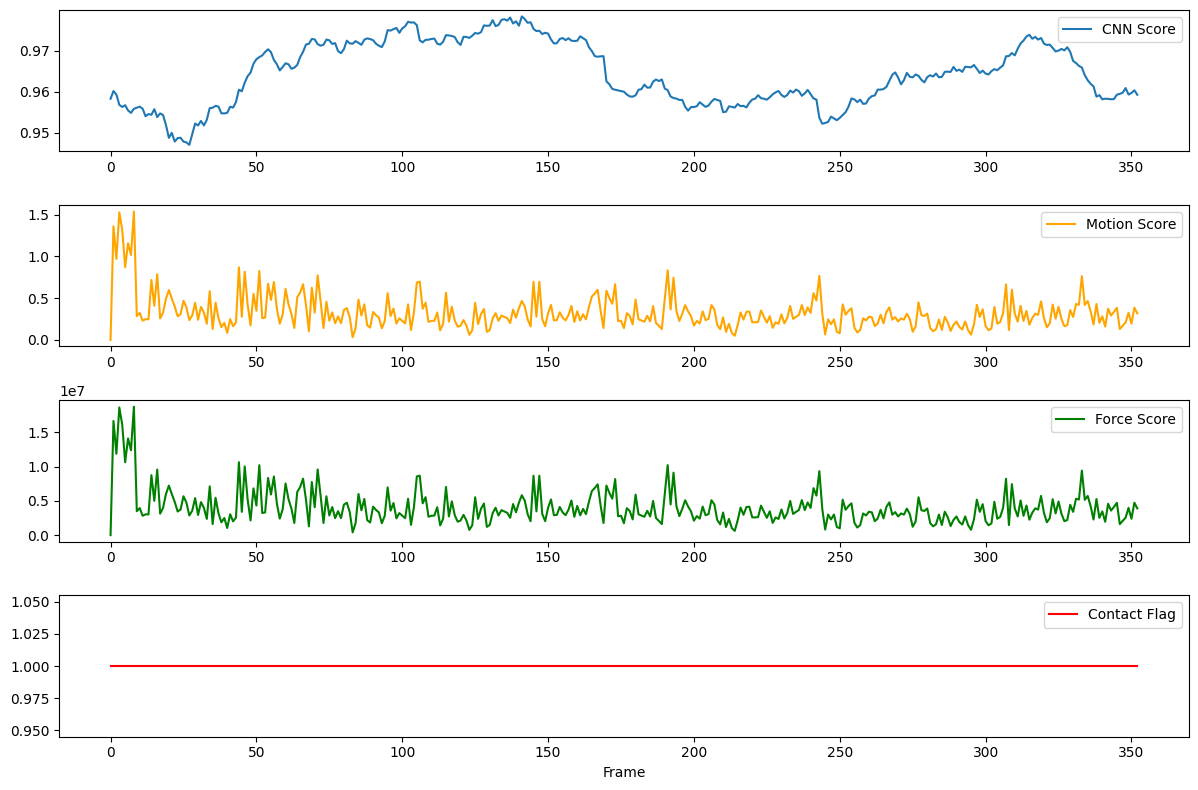

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cnn_score = []
    motion_score = []
    force_score = []
    contact_flag = []

    # --- Parameters ---
    prev_gray = None
    force_scale = 1e5
    contact_threshold = 50       # intensity threshold
    motion_threshold = 2.0       # motion threshold

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # -------------------------------
        # CNN score (placeholder: mean intensity)
        cnn_val = np.mean(gray) / 255.0 * 2.0  # normalized to ~0–2
        cnn_score.append(cnn_val)

        # -------------------------------
        # Motion score (optical flow magnitude)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            motion_val = np.mean(mag)
        else:
            motion_val = 0.0
        motion_score.append(motion_val)

        # -------------------------------
        # Force score (proxy: motion * intensity)
        force_val = motion_val * np.mean(gray) * force_scale
        force_score.append(force_val)

        # -------------------------------
        # Contact flag (motion OR intensity)
        if (motion_val > motion_threshold) or (np.mean(gray) > contact_threshold):
            contact_val = 1
        else:
            contact_val = 0
        contact_flag.append(contact_val)

        prev_gray = gray

    cap.release()

    # Convert to numpy arrays
    cnn_score = np.array(cnn_score)
    motion_score = np.array(motion_score)
    force_score = np.array(force_score)
    contact_flag = np.array(contact_flag)

    return cnn_score, motion_score, force_score, contact_flag, fps


# ============================================================
# Example usage
# ============================================================
video_path = "/content/Chain_Snatching09.mp4"
cnn_score, motion_score, force_score, contact_flag, fps = process_video(video_path)

print("Frames:", len(cnn_score))
print("\nCNN Score array:\n", cnn_score)
print("\nMotion Score array:\n", motion_score)
print("\nForce Score array:\n", force_score)
print("\nContact Flag array:\n", contact_flag)

# ============================================================
# Optional: Plot signals for visualization
# ============================================================
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(cnn_score, label="CNN Score")
plt.legend()

plt.subplot(4,1,2)
plt.plot(motion_score, label="Motion Score", color="orange")
plt.legend()

plt.subplot(4,1,3)
plt.plot(force_score, label="Force Score", color="green")
plt.legend()

plt.subplot(4,1,4)
plt.plot(contact_flag, label="Contact Flag", color="red")
plt.legend()

plt.xlabel("Frame")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.0,
    off_threshold=1.85,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([
0.95829282,0.96017313,0.95931601,0.95682578,0.95630644,0.95672733,0.95547008,0.95486373,0.95586169,0.9561248,0.95637936,0.95587657,0.95404436,0.95458177,0.95439941,0.95576389,0.95385526,0.95473754,0.95434991,0.95189151,0.94880419,0.95001396,0.94789689,0.94872529,0.94882322,0.94787922,0.94770118,0.94709651,0.94963787,0.95227189,0.95181424,0.95289985,0.95181791,0.95319496,0.9560239,0.95611928,0.95657367,0.95639025,0.95475674,0.9547418,0.9548768,0.9563684,0.95614791,0.95750357,0.9605001,0.96011026,0.96223063,0.96380048,0.96465135,0.96682125,0.96789784,0.96842062,0.96883759,0.96967487,0.9703333,0.9696216,0.96773118,0.96671041,0.96519526,0.96600146,0.96692569,0.96667875,0.96559259,0.9658703,0.96652063,0.96840989,0.9697292,0.97147546,0.97166857,0.97283929,0.972726,0.97157758,0.97121038,0.97142695,0.97269124,0.97250497,0.97163977,0.97181247,0.96987251,0.96938565,0.97036962,0.97242075,0.97176736,0.97167385,0.97230824,0.97189852,0.97141864,0.97265839,0.9729761,0.97280811,0.97254221,0.97167164,0.97119659,0.97085675,0.97223291,0.97499942,0.97486646,0.97521984,0.9755146,0.9743335,0.97540295,0.97592606,0.97701535,0.97682465,0.97686925,0.97618103,0.97249272,0.97201685,0.97262343,0.97266486,0.97283051,0.9729358,0.97168873,0.97145718,0.97214914,0.97376518,0.97369298,0.97356093,0.97330161,0.97203312,0.9713943,0.97336087,0.97333177,0.97308364,0.97362793,0.97429875,0.97411867,0.9744918,0.97612915,0.97603663,0.97609991,0.97740782,0.9759601,0.97624306,0.97745244,0.97764308,0.97729262,0.97803796,0.97658905,0.97713698,0.97605787,0.97831808,0.97767974,0.97676702,0.97690193,0.97528036,0.97475848,0.97483568,0.97403431,0.97434395,0.97414073,0.97271817,0.97174677,0.97179415,0.97282976,0.9730674,0.97255433,0.97300817,0.97241629,0.97233943,0.97240359,0.9734842,0.973016,0.97256213,0.97084123,0.96989628,0.9686716,0.96851566,0.9686123,0.96865625,0.9625384,0.96184395,0.96070064,0.96048737,0.96032271,0.96015748,0.96001239,0.95934249,0.95886806,0.95880385,0.95913126,0.96047845,0.96063753,0.96172842,0.96101042,0.96103152,0.96247481,0.9629744,0.962604,0.96299064,0.96080096,0.96037081,0.95884957,0.95846657,0.9583381,0.95801025,0.95802836,0.9563492,0.95539988,0.95628353,0.95627036,0.95649166,0.957463,0.95687432,0.95632928,0.95665315,0.95757629,0.95824901,0.95801103,0.95776917,0.95503799,0.95514852,0.95645347,0.95633381,0.95615703,0.95702056,0.95650575,0.95657527,0.95619138,0.95734225,0.9581154,0.95831839,0.95917347,0.95844111,0.95830256,0.95807996,0.9586649,0.95937425,0.95986836,0.96019431,0.95921715,0.9587452,0.95922389,0.96027686,0.95980709,0.96053499,0.96013872,0.95901787,0.9596089,0.96046048,0.95943784,0.9583815,0.95809385,0.9536683,0.95223785,0.95240642,0.95267194,0.95396221,0.95351198,0.95308708,0.95365965,0.9543653,0.9550383,0.9563816,0.95835955,0.95815121,0.95749653,0.95807755,0.95706039,0.95714556,0.95835318,0.95893566,0.95910349,0.96052134,0.96052073,0.9606636,0.96120721,0.96265741,0.96411789,0.96470391,0.96345854,0.96181454,0.96282101,0.96460281,0.9636475,0.96350466,0.96420197,0.9638797,0.96287963,0.9622837,0.96357653,0.96401307,0.96372491,0.96443069,0.9635192,0.96361754,0.96484069,0.96489897,0.96482547,0.96603653,0.96509075,0.96537442,0.96483895,0.96608408,0.96602352,0.96593168,0.96651351,0.96557166,0.96456999,0.96513201,0.96441558,0.96420401,0.96502665,0.96550572,0.96523165,0.96587565,0.96643713,0.96862068,0.96869499,0.96940588,0.9688573,0.97046167,0.97174847,0.97245622,0.97343638,0.97385127,0.97289321,0.97333742,0.97268658,0.97308286,0.97171201,0.97136986,0.971463,0.97065601,0.96979337,0.97002686,0.97040679,0.97006328,0.97081665,0.96969073,0.96748996,0.96698536,0.96627968,0.96590213,0.96400851,0.96280944,0.9619312,0.96129262,0.95882145,0.9591748,0.95816813,0.95832047,0.95826494,0.95817351,0.95822086,0.95928721,0.95948809,0.95977049,0.96089682,0.95932506,0.95970421,0.96035703,0.95927805
])

motion_score = np.array([
0., 1.35957789, 0.97054744, 1.52645981, 1.32162559, 0.87146783,
1.15780401, 1.01710045, 1.53631234, 0.2864958, 0.32354781, 0.23169279,
0.2498454, 0.24750412, 0.71856916, 0.40999705, 0.78635889, 0.25727287,
0.32658461, 0.49555355, 0.59668791, 0.49364045, 0.40132579, 0.28479218,
0.30868161, 0.46910614, 0.39318523, 0.23748903, 0.29391187, 0.4450267,
0.24185517, 0.39628804, 0.32780114, 0.19464923, 0.58359867, 0.13214141,
0.44659477, 0.26194042, 0.15339971, 0.20509657, 0.08584639, 0.24996969,
0.16506426, 0.20910828, 0.86893517, 0.27735019, 0.8166188, 0.4202942,
0.17414366, 0.55282497, 0.34978065, 0.82626444, 0.26111707, 0.26813185,
0.67400527, 0.47967136, 0.69322777, 0.37936491, 0.19575539, 0.30394089,
0.61130589, 0.42685696, 0.31523597, 0.14433149, 0.51133639, 0.56783533,
0.66655427, 0.41769877, 0.1040471, 0.6246981, 0.32815248, 0.77319151,
0.4682807, 0.14294116, 0.45710436, 0.23159115, 0.33066261, 0.20024998,
0.28263062, 0.20062383, 0.35937235, 0.38158315, 0.2722877, 0.03263285,
0.14037541, 0.48410964, 0.29259691, 0.42593548, 0.17494972, 0.1487747,
0.3348015, 0.29718432, 0.2676408, 0.14029211, 0.22716933, 0.55968118,
0.28738824, 0.37653527, 0.19661568, 0.25884065, 0.2288969, 0.19875395,
0.42592135, 0.120268, 0.32696283, 0.68734872, 0.69939417, 0.37446216,
0.44631246, 0.21673445, 0.22775343, 0.230215, 0.32840165, 0.11507355,
0.19127695, 0.56593323, 0.21929847, 0.39759359, 0.23521931, 0.1583713,
0.17215204, 0.2381946, 0.17252266, 0.0620963, 0.11621699, 0.44426113,
0.19106264, 0.30930337, 0.3707689, 0.09698568, 0.11994301, 0.25799838,
0.32139421, 0.22990979, 0.29221648, 0.27727875, 0.26158199, 0.20289914,
0.36378115, 0.26779738, 0.38067847, 0.46654126, 0.40283331, 0.24493672,
0.16265404, 0.6973573, 0.27948371, 0.69704467, 0.24855715, 0.16414231,
0.32097256, 0.4201107, 0.23474592, 0.2382874, 0.33124611, 0.26671201,
0.23488379, 0.29951668, 0.40738693, 0.21511598, 0.34341255, 0.23281541,
0.30825558, 0.2471256, 0.39398396, 0.5190357, 0.55632615, 0.59999889,
0.35260728, 0.14315635, 0.58858353, 0.50407231, 0.43341944, 0.6676538,
0.22534569, 0.23082228, 0.14243457, 0.32108697, 0.28754786, 0.18743567,
0.48323196, 0.24844332, 0.23382041, 0.21837737, 0.28988743, 0.22235742,
0.40610194, 0.20254833, 0.1686656, 0.13135603, 0.49005759, 0.83384991,
0.36549127, 0.74540615, 0.34666741, 0.22681007, 0.31473503, 0.41735718,
0.34304243, 0.28345022, 0.17286558, 0.22773576, 0.19776146, 0.34128642,
0.23842654, 0.25158647, 0.41722122, 0.36658862, 0.18055488, 0.12892172,
0.27093172, 0.09684442, 0.19401994, 0.08395148, 0.05093303, 0.17828466,
0.32986361, 0.24336252, 0.33649561, 0.33999136, 0.21232356, 0.2115353,
0.21508393, 0.35251954, 0.27792731, 0.20690602, 0.28479993, 0.14577402,
0.21126726, 0.19289581, 0.30630085, 0.19897152, 0.26461688, 0.40710595,
0.25304666, 0.27620354, 0.30043671, 0.41790771, 0.2984364, 0.38939726,
0.32464966, 0.56067061, 0.47160083, 0.7671625, 0.31648913, 0.06719032,
0.24744244, 0.18854225, 0.24672112, 0.09772498, 0.08180198, 0.4251307,
0.30362526, 0.3476814, 0.37956843, 0.14926675, 0.09046573, 0.11978326,
0.25865412, 0.23550189, 0.2789135, 0.27163529, 0.16626486, 0.19783008,
0.30229709, 0.20000041, 0.33778602, 0.38994309, 0.24284957, 0.27321097,
0.22153082, 0.25796208, 0.24385487, 0.31410071, 0.25093958, 0.09932212,
0.16064675, 0.44965982, 0.29584193, 0.28741118, 0.31615198, 0.14269884,
0.10499488, 0.12882124, 0.24380359, 0.12056261, 0.27756387, 0.21313861,
0.10817486, 0.18078443, 0.22126798, 0.15478496, 0.12568548, 0.22130583,
0.11853549, 0.06387558, 0.18540123, 0.42075047, 0.27594581, 0.36681652,
0.16707298, 0.11701385, 0.13817032, 0.39524946, 0.19462527, 0.21547914,
0.32305399, 0.66522509, 0.11890414, 0.60170829, 0.31519902, 0.22013634,
0.40867144, 0.22758941, 0.34810334, 0.18190961, 0.26379421, 0.31463084,
0.30088606, 0.46173781, 0.26262212, 0.1515187, 0.20001513, 0.42380562,
0.25559583, 0.39668036, 0.25191286, 0.16475691, 0.17825814, 0.35801789,
0.27520993, 0.4304949, 0.42154852, 0.76417017, 0.41942286, 0.46572214,
0.34497586, 0.18544167, 0.43055966, 0.2059861, 0.28299496, 0.15961833,
0.37448263, 0.2931321, 0.3365334, 0.38547263, 0.13137536, 0.17093423,
0.20878601, 0.32559633, 0.19534732, 0.38642195, 0.31889662



])

force_score = np.array([
0., 16644234.64613429, 11871036.57035954, 18622090.21684621,
16114458.06767077, 10630402.86708437, 14104650.39103789, 12382702.27168112,
18723401.91539305, 3492553.22115092, 3945289.19778919, 2823738.79474277,
3039135.82552203, 3012352.1744434, 8743975.24769185, 4996219.73167794,
9563425.1795884, 3131757.84926668, 3973868.88692547, 6014343.55484956,
7218284.92665829, 5979307.82640469, 4850297.23776609, 3444916.72410009,
3734274.53787578, 5669363.49613954, 4750931.85739553, 2867794.1404712,
3558650.53115739, 5403276.7533312, 2935065.27422947, 4814690.84517668,
3978089.187115, 2365618.0201984, 7113662.04460664, 1610872.62745326,
5446810.20872761, 3194095.11089635, 1867357.39002936, 2496631.94400886,
1045152.31567522, 3048054.6838539, 2012279.5561217, 2552829.52792913,
10641307.04686364, 3395156.19589523, 10018639.19217476, 5164766.79598497,
2141845.89792427, 6814657.37916488, 4316537.1739331, 10202186.86094891,
3225495.42459834, 3315009.16787097, 8338624.40663835, 5930021.28544677,
8553441.06175916, 4675884.06947118, 2409012.75753323, 3743493.67152998,
7536363.97298475, 5261077.8615495, 3880966.37837423, 1777420.06225054,
6301268.86226314, 7011191.23513769, 8241308.55520424, 5173747.32422481,
1289016.0051732, 7748568.45015932, 4069831.20347567, 9577998.10960327,
5798688.23663006, 1770425.43186316, 5668922.90163612, 2871600.19305311,
4096383.00843899, 2481219.25284107, 3494974.82493947, 2479643.69184662,
4446231.1134393, 4731007.06464859, 3373653.77894657, 404283.21031872,
1740224.09338451, 5998944.41115494, 3623984.6375365, 5282193.8953608,
2170329.19012348, 1845297.72003952, 4151509.47630302, 3681761.05538184,
3314130.84978684, 1736595.1428492, 2815984.17343122, 6957532.50372068,
3572105.66709947, 4681859.44343977, 2445468.71947716, 3215513.2504836,
2846650.57839727, 2473106.82387588, 5305679.15817628, 1497879.55539617,
4072349.13565493, 8554954.02477195, 8671985.58177856, 4640789.96860131,
5534697.92524697, 2687827.34607947, 2824959.94102796, 2855801.26444016,
4068578.36583536, 1425310.13255352, 2370858.98234953, 7026347.42534161,
2722499.56984923, 4935290.20327198, 2918976.54587783, 1962762.39639788,
2132150.79027973, 2956078.61977433, 2141002.81664739, 770417.36557963,
1442689.33316188, 5518749.09148965, 2373000.52781531, 3843023.39447803,
4614458.79558256, 1206935.13098553, 1492723.58137939, 3215162.78572831,
3999266.00119927, 2861709.93926586, 3641753.33292992, 3456265.5523346,
3259437.35530057, 2530149.05609134, 4529624.83035711, 3336352.7374221,
4737443.82424953, 5819428.33156718, 5021485.09064068, 3050387.89996632,
2025937.35257324, 8671515.70782955, 3473471.16752431, 8663676.21628094,
3086815.71554765, 2039121.11685115, 3986573.67086938, 5210278.75722365,
2908448.2510843, 2952470.39898483, 4108637.4082166, 3308991.72253441,
2912574.84066238, 3715760.22597154, 5050908.5066479, 2666863.28711821,
4257678.85486471, 2889687.14233757, 3824204.58139435, 3064398.68287824,
4876822.37874841, 6418487.5667432, 6870941.13846382, 7409131.10146392,
4354631.80479432, 1768033.48351037, 7223311.65557789, 6181696.00653773,
5308925.70433861, 8176231.28493741, 2759158.40119977, 2825728.15566289,
1743421.6053712, 3927412.79768001, 3515435.78987398, 2291354.06475262,
5909406.74640859, 3042461.81057038, 2863862.40374825, 2677751.42124827,
3551956.68757707, 2724579.27140995, 4983501.83819938, 2486872.86266726,
2070066.83737683, 1612806.50562841, 6003309.45800726, 10210265.19016052,
4468252.14273063, 9109197.68988672, 4235863.46788435, 2770401.20527054,
3844444.75582639, 5089024.80626145, 4178719.43818868, 3455999.36094542,
2107654.48545425, 2777298.75092571, 2414203.33624152, 4163744.69747767,
2907182.04943881, 3068682.5809504, 5093894.59906484, 4478860.61452354,
2205412.99295635, 1574334.88227951, 3299063.59713525, 1179385.25775368,
2366030.85303386, 1023641.90200452, 620924.71861334, 2175431.58775089,
4022834.59271638, 2968130.68486265, 4102366.05136089, 4149973.21339146,
2593738.54278699, 2584656.69978393, 2630360.66920962, 4307832.56191758,
3395815.26233204, 2527464.53627734, 3481103.1585818, 1783110.99748025,
2585556.70752124, 2361522.65884895, 3746065.09642796, 2432228.17865606,
3236292.08286951, 4984413.92142477, 3096668.73564117, 3382615.39991723,
3677876.64483773, 5109957.33269056, 3651373.40948431, 4768508.69340962,
3971384.92245654, 6851038.40324459, 5760932.66924494, 9328136.63270945,
3842504.83284972, 815904.26632906, 3005576.23424277, 2293242.78502197,
2999457.17354119, 1187540.31873137, 994643.42034595, 5173057.27825946,
3697165.2757359, 4239580.2500843, 4637978.57949083, 1823506.49227608,
1104412.958488, 1463211.05993244, 3156232.03392285, 2873972.19895509,
3408044.87853663, 3321129.82225232, 2033181.40896286, 2422755.19460673,
3702123.37477649, 2449697.15194311, 4139700.04847653, 4786115.48928772,
2985229.11998697, 3360488.08462786, 2721305.99848561, 3163423.89311362,
2993554.49589648, 3863025.96171557, 3083170.53875155, 1220140.87805084,
1974922.90229962, 5526079.18875292, 3631967.17003485, 3526281.48668283,
3884116.94308743, 1753935.21706015, 1290123.7908474, 1584049.2455913,
2995095.36447702, 1481247.08525116, 3414512.66332529, 2622129.61034694,
1330715.7223643, 2226715.67579306, 2722681.98291977, 1905174.4063144,
1546144.68339578, 2725950.53372425, 1459977.89870323, 786667.91905518,
2284708.14138719, 5179875.27642941, 3393655.37885835, 4513836.17724395,
2054379.271553, 1438521.59002298, 1700059.99183579, 4865599.03187336,
2395195.54417506, 2653607.12963208, 3980694.90968225, 8215472.38765763,
1468568.47077049, 7437069.32064586, 3893631.5746622, 2723832.02497408,
5063354.51765987, 2821839.45306627, 4320419.84340525, 2258699.49113296,
3272205.89681289, 3904585.06486534, 3731514.92907072, 5728691.64655373,
3253711.59273759, 1876553.9352467, 2477418.01586129, 5244960.83138752,
3160408.0857612, 4906080.1337144, 3116838.90085499, 2037764.00758633,
2206463.57781894, 4426374.55941029, 3394851.29878682, 5307598.95742902,
5193505.5221699, 9410948.34235828, 5155171.94295074, 5717121.35100039,
4230998.79514425, 2272862.32127653, 5263580.50482703, 2519102.59804551,
3457248.53322279, 1950310.31874183, 4575383.12132926, 3581110.47148064,
4111534.85168279, 4714681.71933427, 1607176.90080781, 2091734.78593607,
2557928.12714974, 3982497.20134772, 2390314.53894068, 4731563.67664939,
3900359.24763057

])

contact_flags = np.ones(len(cnn_score), dtype=int)

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 353

Detected Events:
Event 1: Start=20, End=69, Duration=1.67s
Event 2: Start=120, End=169, Duration=1.67s
Event 3: Start=220, End=269, Duration=1.67s

Smoothed Confidence Array:
[1.958 2.633 2.913 3.382 3.609 3.545 3.642 3.639 3.895 3.455 3.166 2.918
 2.752 2.635 2.787 2.741 2.894 2.739 2.666 2.696 2.767 2.766 2.718 2.628
 2.577 2.62  2.612 2.53  2.501 2.556 2.495 2.528 2.517 2.444 2.587 2.463
 2.532 2.489 2.405 2.371 2.289 2.313 2.288 2.292 2.624 2.562 2.788 2.749
 2.601 2.685 2.644 2.853 2.718 2.627 2.766 2.766 2.871 2.789 2.639 2.588
 2.706 2.697 2.634 2.505 2.598 2.692 2.807 2.765 2.579 2.708 2.651 2.833
 2.808 2.628 2.659 2.569 2.555 2.48  2.467 2.418 2.463 2.506 2.481 2.345
 2.303 2.445 2.449 2.518 2.442 2.375 2.422 2.435 2.429 2.362 2.358 2.522
 2.502 2.532 2.463 2.446 2.419 2.385 2.476 2.386 2.427 2.635 2.785 2.728
 2.724 2.607 2.53  2.478 2.49  2.392 2.361 2.527 2.471 2.52  2.473 2.402
 2.359 2.362 2.331 2.255 2.228 2.374 2.349 2.391 2.452 2.358 2.303 2.334
 2.

In [ ]:
!pip install ultralytics
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# -------------------------
# VIDEO PATH
# -------------------------
video_path = "/content/Chain_Snatching173.mp4"  # replace with your video path
cap = cv2.VideoCapture(video_path)

# -------------------------
# DEVICE AND MODELS
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# CNN model (ResNet18)
cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

# YOLOv8 object detection
yolo = YOLO("yolov8n.pt")  # will download automatically if first run

# Image transform for CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# -------------------------
# INIT VARIABLES
# -------------------------
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

# -------------------------
# PROCESS VIDEO FRAME BY FRAME
# -------------------------
frame_count = 0
YOLO_INTERVAL = 5   # run YOLO every 5 frames for speed
last_area = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ----- Motion score -----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ----- CNN score -----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ----- YOLO object area (run every YOLO_INTERVAL frames) -----
    frame_count += 1
    if frame_count % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)
    total_area = last_area

    # ----- Force score -----
    force_score = motion_score * (total_area + 1e-6)
    force_scores.append(force_score)

    # ----- Adaptive thresholds -----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ----- Contact flag -----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

cap.release()

# -------------------------
# Convert to numpy arrays
# -------------------------
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# -------------------------
# Smooth contact flags (remove isolated spikes)
# -------------------------
for i in range(1, len(contact_flags)-1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# -------------------------
# PRINT ARRAYS
# -------------------------
print("CNN SCORES ARRAY:")
print(cnn_scores)

print("\nMOTION SCORES ARRAY:")
print(motion_scores)

print("\nFORCE SCORES ARRAY:")
print(force_scores)

print("\nCONTACT FLAGS ARRAY:")
print(contact_flags)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


CNN SCORES ARRAY:
[     2.1224      2.1334        2.12      2.1278      2.1369      2.1264      2.1048      2.0986      2.1726      2.1664      2.1512      2.1678       2.171      2.1486      2.1218      2.0973      2.0784        2.03      1.9644      1.9586      1.9698      1.9035      1.8971      1.8998      1.9206      1.9433
      1.9426      1.9049      1.9805      2.1007      2.0261      2.0751      2.1841      2.0445      2.0836      1.9369      1.9157      1.8251      1.8656      1.9268      2.0012      1.9576      1.9585      1.9931      1.9837      1.9833      2.0692      2.2111      2.1033       2.137      2.1864      2.1283
      2.2719      2.1424      2.1255      1.9648      2.0523      2.0279      2.0137      1.9902      1.8294      1.8456      1.9131      1.8938      1.9419       1.845      1.9433      1.9303      1.9218      1.8871      1.9732      2.0468      2.0754      2.0745      2.0655      2.1764      2.1809      2.0719
      2.0967      2.1333      2.3124      2

In [ ]:
cnn_score = np.array([
2.1224, 2.1334, 2.12, 2.1278, 2.1369, 2.1264, 2.1048, 2.0986, 2.1726, 2.1664,
2.1512, 2.1678, 2.171, 2.1486, 2.1218, 2.0973, 2.0784, 2.03, 1.9644, 1.9586,
1.9698, 1.9035, 1.8971, 1.8998, 1.9206, 1.9433, 1.9426, 1.9049, 1.9805, 2.1007,
2.0261, 2.0751, 2.1841, 2.0445, 2.0836, 1.9369, 1.9157, 1.8251, 1.8656, 1.9268,
2.0012, 1.9576, 1.9585, 1.9931, 1.9837, 1.9833, 2.0692, 2.2111, 2.1033, 2.137,
2.1864, 2.1283, 2.2719, 2.1424, 2.1255, 1.9648, 2.0523, 2.0279, 2.0137, 1.9902,
1.8294, 1.8456, 1.9131, 1.8938, 1.9419, 1.845, 1.9433, 1.9303, 1.9218, 1.8871,
1.9732, 2.0468, 2.0754, 2.0745, 2.0655, 2.1764, 2.1809, 2.0719, 2.0967, 2.1333,
2.3124, 2.3004, 2.3779, 2.1748, 2.1348, 1.9714, 1.9332, 1.9077, 1.9718, 2.0238,
2.0898, 2.1356, 2.1576, 2.2024, 2.1079, 2.1293, 2.1572, 2.0856, 1.9189, 1.8756,
1.772, 1.747, 1.756, 1.7437, 1.6944, 1.7093, 1.7081, 1.7735, 1.7343, 1.7171,
1.7276, 1.738, 1.7508, 1.8534, 1.8762, 2.0373, 2.008, 2.0318, 1.9688, 1.91,
1.9976, 2.0042, 1.9798, 1.9753, 1.9655, 2.0007, 2.0266, 1.9978, 1.9754, 1.9935,
1.9442, 1.947, 1.9138, 1.9658, 1.9606, 1.9807, 2.0077, 2.0119, 2.0322, 1.9972,
1.9788, 1.9597, 1.949, 1.9723, 1.9665, 2.0148, 1.9605, 2.0135, 2.1279, 2.1216,
2.1092, 1.9912, 1.9762, 1.9706, 1.9701, 1.9687, 1.9575, 1.9412, 1.9179, 1.8759,
1.9097, 2.0136, 2.1159, 2.0678, 1.98, 2.0043, 2.0798, 2.0701, 2.0186, 2.0683,
2.0865, 2.0677, 2.0813, 2.1135, 2.1394, 2.0609, 2.0766, 2.0301, 2.0057, 1.9825,
1.9662, 1.9986, 2.0135, 2.0692, 2.0607, 2.0837, 2.1284, 2.1475, 2.1116, 2.1562,
2.1771
])
motion_score = np.array([
0.29895, 0.31249, 0.37041, 0.43721, 0.44356, 0.34006, 0.25438, 0.26561, 0.21164, 0.23273,
0.21671, 0.22267, 0.23637, 0.24779, 0.25148, 0.26349, 0.25687, 0.24667, 0.23525, 0.21244,
0.20507, 0.19187, 0.18872, 0.18173, 0.17679, 0.18573, 0.21634, 0.26965, 0.41824, 0.60447,
0.66848, 0.7147, 0.82822, 1.0409, 1.1073, 1.3358, 1.4296, 1.5083, 1.4431, 1.6924,
1.9352, 1.9815, 2.0782, 1.9802, 2.1035, 2.0582, 1.9316, 2.0356, 1.9922, 2.0211,
2.134, 2.1916, 2.0575, 2.0043, 2.0305, 1.9082, 1.8055, 1.7096, 1.6564, 1.7218,
1.5882, 1.5099, 1.4375, 1.3819, 1.3555, 1.3325, 1.4073, 1.3926, 1.4255, 1.4443,
1.42, 1.5075, 1.6087, 1.5991, 1.6072, 1.6789, 1.6027, 1.5175, 1.549, 1.5793,
1.5666, 1.4564, 1.4709, 1.5135, 1.5614, 1.4942, 1.3771, 1.2649, 1.1812, 1.1018,
1.0146, 0.88758, 0.76226, 0.65618, 0.60462, 0.58176, 0.56333, 0.55956, 0.56559, 0.59727,
0.58378, 0.54156, 0.50283, 0.48023, 0.50275, 0.46488, 0.45791, 0.41276, 0.37994, 0.35666,
0.35232, 0.37149, 0.39424, 0.44384, 0.51966, 0.58496, 0.65834, 0.66079, 0.66333, 0.6389,
0.66046, 0.62682, 0.5807, 0.52562, 0.4739, 0.40459, 0.35399, 0.37453, 0.4063, 0.49049,
0.56556, 0.58909, 0.56953, 0.53335, 0.45593, 0.48113, 0.44327, 0.40287, 0.34017, 0.34204,
0.39265, 0.45116, 0.56975, 0.71924, 0.83834, 0.91681, 0.94571, 0.96291, 0.94443, 0.80322,
0.69027, 0.64842, 0.53855, 0.45908, 0.35554, 0.25864, 0.2081, 0.27608, 0.36625, 0.45838,
0.54672, 0.5991, 0.60302, 0.70683, 0.73056, 0.70615, 0.7168, 0.72043, 0.74083, 0.70878,
0.68798, 0.66801, 0.62052, 0.57833, 0.54019, 0.51059, 0.50415, 0.44853, 0.42245, 0.4128,
0.40082, 0.37855, 0.36338, 0.33927, 0.37874, 0.29851, 0.30306, 0.32743, 0.33894, 0.34385,
0.35261
])
force_score = np.array([
2.9895e-07, 3.1249e-07, 3.7041e-07, 4.3721e-07, 36155, 27719, 20735, 21651, 17252, 20227,
18835, 19352, 20543, 21535, 24486, 25655, 25011, 24018, 22906, 20443, 19733, 18463, 18160,
17487, 17856, 18759, 21851, 27235, 42244, 83739, 92607, 99009, 114740, 144200, 332230,
400790, 428920, 452550, 433000, 522180, 597060, 611380, 641210, 610960, 910930, 891330,
836470, 881510, 862740, 722360, 762710, 783290, 735360, 716350, 639920, 601370, 568990,
538760, 522000, 495440, 457010, 434480, 413630, 397650, 338180, 332450, 351100, 347440,
355630, 429680, 422460, 448500, 478590, 475740, 516370, 539430, 514920, 487550, 497690,
484340, 480470, 446650, 451110, 464180, 373180, 357110, 329130, 302310, 282310, 278900,
256830, 224670, 192940, 166090, 102580, 98697, 95570, 94931, 95954, 96675, 94492, 87659,
81390, 77731, 78071, 72191, 71109, 64098, 59001, 56828, 56135, 59189, 62814, 70717,
85416, 96149, 108210, 108610, 109030, 97995, 101300, 96142, 89069, 80620, 78093, 66670,
58333, 61717, 66953, 82336, 94936, 98887, 95604, 89530, 66782, 70473, 64927, 59010,
49827, 49515, 56840, 65311, 82478, 104120, 111920, 122400, 126260, 128550, 126090,
83289, 71577, 67237, 55844, 47604, 30952, 22517, 18117, 24035, 31885, 43611, 52016,
56999, 57373, 67250, 82901, 80132, 81340, 81752, 84067,
])
contact_flag = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0
])


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.0,
    off_threshold=1.85,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================
cnn_score = np.array([
2.1224, 2.1334, 2.12, 2.1278, 2.1369, 2.1264, 2.1048, 2.0986, 2.1726, 2.1664,
2.1512, 2.1678, 2.171, 2.1486, 2.1218, 2.0973, 2.0784, 2.03, 1.9644, 1.9586,
1.9698, 1.9035, 1.8971, 1.8998, 1.9206, 1.9433, 1.9426, 1.9049, 1.9805, 2.1007,
2.0261, 2.0751, 2.1841, 2.0445, 2.0836, 1.9369, 1.9157, 1.8251, 1.8656, 1.9268,
2.0012, 1.9576, 1.9585, 1.9931, 1.9837, 1.9833, 2.0692, 2.2111, 2.1033, 2.137,
2.1864, 2.1283, 2.2719, 2.1424, 2.1255, 1.9648, 2.0523, 2.0279, 2.0137, 1.9902,
1.8294, 1.8456, 1.9131, 1.8938, 1.9419, 1.845, 1.9433, 1.9303, 1.9218, 1.8871,
1.9732, 2.0468, 2.0754, 2.0745, 2.0655, 2.1764, 2.1809, 2.0719, 2.0967, 2.1333,
2.3124, 2.3004, 2.3779, 2.1748, 2.1348, 1.9714, 1.9332, 1.9077, 1.9718, 2.0238,
2.0898, 2.1356, 2.1576, 2.2024, 2.1079, 2.1293, 2.1572, 2.0856, 1.9189, 1.8756,
1.772, 1.747, 1.756, 1.7437, 1.6944, 1.7093, 1.7081, 1.7735, 1.7343, 1.7171,
1.7276, 1.738, 1.7508, 1.8534, 1.8762, 2.0373, 2.008, 2.0318, 1.9688, 1.91,
1.9976, 2.0042, 1.9798, 1.9753, 1.9655, 2.0007, 2.0266, 1.9978, 1.9754, 1.9935,
1.9442, 1.947, 1.9138, 1.9658, 1.9606, 1.9807, 2.0077, 2.0119, 2.0322, 1.9972,
1.9788, 1.9597, 1.949, 1.9723, 1.9665, 2.0148, 1.9605, 2.0135, 2.1279, 2.1216,
2.1092, 1.9912, 1.9762, 1.9706, 1.9701, 1.9687, 1.9575, 1.9412, 1.9179, 1.8759,
1.9097, 2.0136, 2.1159, 2.0678, 1.98, 2.0043, 2.0798, 2.0701, 2.0186, 2.0683,
2.0865, 2.0677, 2.0813, 2.1135, 2.1394, 2.0609, 2.0766, 2.0301, 2.0057, 1.9825,
1.9662, 1.9986, 2.0135, 2.0692, 2.0607, 2.0837, 2.1284, 2.1475, 2.1116, 2.1562,
2.1771
])
motion_score = np.array([
0.29895, 0.31249, 0.37041, 0.43721, 0.44356, 0.34006, 0.25438, 0.26561, 0.21164, 0.23273,
0.21671, 0.22267, 0.23637, 0.24779, 0.25148, 0.26349, 0.25687, 0.24667, 0.23525, 0.21244,
0.20507, 0.19187, 0.18872, 0.18173, 0.17679, 0.18573, 0.21634, 0.26965, 0.41824, 0.60447,
0.66848, 0.7147, 0.82822, 1.0409, 1.1073, 1.3358, 1.4296, 1.5083, 1.4431, 1.6924,
1.9352, 1.9815, 2.0782, 1.9802, 2.1035, 2.0582, 1.9316, 2.0356, 1.9922, 2.0211,
2.134, 2.1916, 2.0575, 2.0043, 2.0305, 1.9082, 1.8055, 1.7096, 1.6564, 1.7218,
1.5882, 1.5099, 1.4375, 1.3819, 1.3555, 1.3325, 1.4073, 1.3926, 1.4255, 1.4443,
1.42, 1.5075, 1.6087, 1.5991, 1.6072, 1.6789, 1.6027, 1.5175, 1.549, 1.5793,
1.5666, 1.4564, 1.4709, 1.5135, 1.5614, 1.4942, 1.3771, 1.2649, 1.1812, 1.1018,
1.0146, 0.88758, 0.76226, 0.65618, 0.60462, 0.58176, 0.56333, 0.55956, 0.56559, 0.59727,
0.58378, 0.54156, 0.50283, 0.48023, 0.50275, 0.46488, 0.45791, 0.41276, 0.37994, 0.35666,
0.35232, 0.37149, 0.39424, 0.44384, 0.51966, 0.58496, 0.65834, 0.66079, 0.66333, 0.6389,
0.66046, 0.62682, 0.5807, 0.52562, 0.4739, 0.40459, 0.35399, 0.37453, 0.4063, 0.49049,
0.56556, 0.58909, 0.56953, 0.53335, 0.45593, 0.48113, 0.44327, 0.40287, 0.34017, 0.34204,
0.39265, 0.45116, 0.56975, 0.71924, 0.83834, 0.91681, 0.94571, 0.96291, 0.94443, 0.80322,
0.69027, 0.64842, 0.53855, 0.45908, 0.35554, 0.25864, 0.2081, 0.27608, 0.36625, 0.45838,
0.54672, 0.5991, 0.60302, 0.70683, 0.73056, 0.70615, 0.7168, 0.72043, 0.74083, 0.70878,
0.68798, 0.66801, 0.62052, 0.57833, 0.54019, 0.51059, 0.50415, 0.44853, 0.42245, 0.4128,
0.40082, 0.37855, 0.36338, 0.33927, 0.37874, 0.29851, 0.30306, 0.32743, 0.33894, 0.34385,
0.35261
])
force_score = np.array([
2.9895e-07, 3.1249e-07, 3.7041e-07, 4.3721e-07, 36155, 27719, 20735, 21651, 17252, 20227,
18835, 19352, 20543, 21535, 24486, 25655, 25011, 24018, 22906, 20443, 19733, 18463, 18160,
17487, 17856, 18759, 21851, 27235, 42244, 83739, 92607, 99009, 114740, 144200, 332230,
400790, 428920, 452550, 433000, 522180, 597060, 611380, 641210, 610960, 910930, 891330,
836470, 881510, 862740, 722360, 762710, 783290, 735360, 716350, 639920, 601370, 568990,
538760, 522000, 495440, 457010, 434480, 413630, 397650, 338180, 332450, 351100, 347440,
355630, 429680, 422460, 448500, 478590, 475740, 516370, 539430, 514920, 487550, 497690,
484340, 480470, 446650, 451110, 464180, 373180, 357110, 329130, 302310, 282310, 278900,
256830, 224670, 192940, 166090, 102580, 98697, 95570, 94931, 95954, 96675, 94492, 87659,
81390, 77731, 78071, 72191, 71109, 64098, 59001, 56828, 56135, 59189, 62814, 70717,
85416, 96149, 108210, 108610, 109030, 97995, 101300, 96142, 89069, 80620, 78093, 66670,
58333, 61717, 66953, 82336, 94936, 98887, 95604, 89530, 66782, 70473, 64927, 59010,
49827, 49515, 56840, 65311, 82478, 104120, 111920, 122400, 126260, 128550, 126090,
83289, 71577, 67237, 55844, 47604, 30952, 22517, 18117, 24035, 31885, 43611, 52016,
56999, 57373, 67250, 82901, 80132, 81340, 81752, 84067, 97121, 94271, 91535, 85028,
79247, 95583, 90344, 89206, 79364, 74750, 62010, 60211, 56865, 54586, 50964, 53755,
42368, 43014, 46473, 48107, 47854, 49074
])

contact_flag = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0
])



# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 191

Detected Events:
Event 1: Start=20, End=69, Duration=1.67s
Event 2: Start=120, End=169, Duration=1.67s

Smoothed Confidence Array:
[3.421 3.429 3.447 3.483 3.524 3.216 2.966 2.792 2.676 2.599 2.536 2.499 2.478 2.461 2.443 2.426 2.407 2.376 2.331 2.29  2.262 2.218 2.184 2.159 2.147 2.147 2.158 2.172 2.254 2.717 3.041 3.298 3.55  3.758 3.997 4.212 4.393 4.224 4.092 4.122 4.263 4.367 4.479 4.529 4.696 4.793 4.831 4.946 4.975 4.968 5.025 5.071 5.091
 5.044 4.988 4.852 4.741 4.617 4.505 4.43  4.277 4.144 4.042 3.943 3.861 3.765 3.756 3.741 3.74  3.759 3.788 3.866 3.969 4.037 4.098 4.203 4.247 4.21  4.205 4.217 4.273 4.266 4.289 4.262 4.215 4.108 3.977 3.835 3.724 3.636 3.561 3.474 3.371 3.272 3.138 3.042 2.977 2.909 2.813 2.743 2.658 2.576 2.508 2.448 2.399 2.355
 2.322 2.302 2.265 2.227 2.201 2.193 2.199 2.252 2.623 2.955 3.204 3.086 2.986 2.887 2.852 2.817 2.77  2.715 2.658 2.604 2.556 2.522 2.502 2.523 2.851 3.089 2.939 2.836 2.732 2.674 2.629 2.584 2.537 2.494 2.476 2

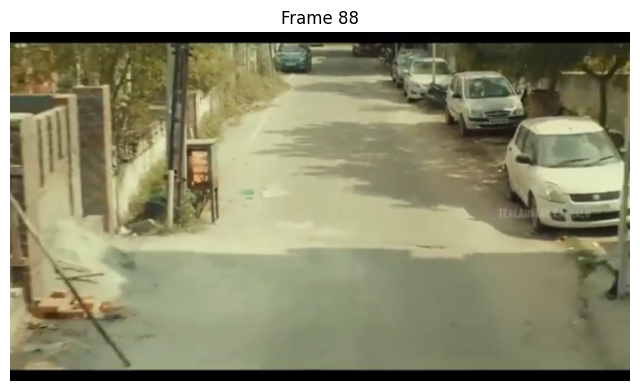

In [ ]:
import cv2
import matplotlib.pyplot as plt

frame_idx = 1
 # frame you want to check
video_path = "/content/Chain_Snatching139.mp4"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()

if ret:

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("Could not read frame")

cap.release()


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# ============================================================
# LOAD NPZ
# ============================================================
npz_path = "/content/Chain_Snatching09.npz"
data = np.load(npz_path)

print("NPZ keys:", data.files)

# USE FAST STREAM
frames = data["fast"]   # (3, T, H, W)
print("Original shape:", frames.shape)

# ============================================================
# FIX SHAPE: (C,T,H,W) → (T,H,W,C)
# ============================================================
frames = np.transpose(frames, (1, 2, 3, 0))  # (T,H,W,3)

# Normalize to uint8 if needed
if frames.dtype != np.uint8:
    frames = np.clip(frames * 255, 0, 255).astype(np.uint8)

T = len(frames)
print("Fixed shape:", frames.shape)
print("Fixed dtype:", frames.dtype)

# ============================================================
# DEVICE & MODELS
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

yolo = YOLO("yolov8n.pt")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ============================================================
# INIT ARRAYS
# ============================================================
cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

YOLO_INTERVAL = 5
last_area = 0.0

# ============================================================
# INITIAL FRAME
# ============================================================
prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

# ============================================================
# FRAME PROCESSING
# ============================================================
for t in range(1, T):

    frame = frames[t]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ---- Motion ----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ---- CNN ----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ---- YOLO ----
    if t % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)

    # ---- Force ----
    force_score = motion_score * (last_area + 1e-6)
    force_scores.append(force_score)

    # ---- Adaptive thresholds ----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ---- Contact flag ----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

# ============================================================
# TO NUMPY
# ============================================================
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# ============================================================
# SMOOTH CONTACT FLAGS
# ============================================================
for i in range(1, len(contact_flags) - 1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# ============================================================
# OUTPUT
# ============================================================
print("\nCNN SCORES:")
print(cnn_scores)

print("\nMOTION SCORES:")
print(motion_scores)

print("\nFORCE SCORES:")
print(force_scores)

print("\nCONTACT FLAGS:")
print(contact_flags)

print("\nTotal Frames:", len(contact_flags))


NPZ keys: ['slow', 'fast']
Original shape: (3, 64, 224, 224)
Fixed shape: (64, 224, 224, 3)
Fixed dtype: uint8

CNN SCORES:
[     1.6667      1.7587      1.6951      1.8085      1.6059      1.6395      1.5531      1.7309      1.7194      1.7276      1.7238       1.728      1.6018      1.6904      1.7836      1.8389      1.7633        1.61      1.6487      1.6901       1.714      1.6828      1.7503      1.7699      1.7444       1.935
      1.8236      1.8393      1.8632      1.9086      1.9551         1.8      1.9738      1.9271      1.7881      1.8225      1.8539       1.873      1.7673      1.8184      1.8621      1.8291      1.7724      1.7362      1.7174      1.7319      1.7589       1.743      1.7656      1.7407      1.7093      1.6655
      1.7983      1.7238      1.7787      1.7877      1.6582      1.5841      1.6772      1.6745      1.7115      1.6159      1.6218]

MOTION SCORES:
[     3.2118      2.3223      1.3492      1.3536     0.97337     0.88945     0.88046     0.85133    

In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching09.npz
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.0,
    off_threshold=1.85,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================



cnn_scores = np.array([
1.6667, 1.7587, 1.6951, 1.8085, 1.6059, 1.6395, 1.5531, 1.7309, 1.7194,
1.7276, 1.7238, 1.7280, 1.6018, 1.6904, 1.7836, 1.8389, 1.7633, 1.6100,
1.6487, 1.6901, 1.7140, 1.6828, 1.7503, 1.7699, 1.7444, 1.9350,
1.8236, 1.8393, 1.8632, 1.9086, 1.9551, 1.8000, 1.9738, 1.9271,
1.7881, 1.8225, 1.8539, 1.8730, 1.7673, 1.8184, 1.8621, 1.8291,
1.7724, 1.7362, 1.7174, 1.7319, 1.7589, 1.7430, 1.7656, 1.7407,
1.7093, 1.6655, 1.7983, 1.7238, 1.7787, 1.7877, 1.6582, 1.5841,
1.6772, 1.6745, 1.7115, 1.6159, 1.6218
])

motion_scores = np.array([
3.2118, 2.3223, 1.3492, 1.3536, 0.97337, 0.88945, 0.88046, 0.85133,
1.0732, 0.81278, 0.8758, 1.1428, 1.2154, 0.59525, 0.70438, 0.60306,
0.64146, 0.64348, 1.1492, 0.70732, 0.61063, 0.31422, 0.59319,
0.45962, 0.59505, 1.1102, 0.95938, 0.47804, 0.50123, 0.96184,
1.2187, 0.50604, 0.56582, 0.54059, 1.3147, 0.40859, 0.40867,
0.28911, 0.45731, 0.35291, 0.52612, 0.46939, 1.0126, 1.1530,
0.41042, 0.67502, 0.40851, 0.61141, 0.34553, 1.0428, 0.45338,
0.55782, 0.60428, 0.70932, 1.1527, 0.90782, 0.78279, 0.9258,
0.54541, 1.7587, 0.91879, 0.99328, 0.87831
])

force_scores = np.array([
3.2118e-06, 2.3223e-06, 1.3492e-06, 1.3536e-06,
11246, 10277, 10173, 9836.2, 12400, 2843.1, 3063.6, 3997.6,
4251.6, 2082.2, 1424.3, 1219.4, 1297, 1301.1, 2323.7,
7.0732e-07, 6.1063e-07, 3.1422e-07, 5.9319e-07, 4.5962e-07,
550.42, 1027, 887.43, 442.19, 463.64,
40319, 51087, 21213, 23719, 22661,
1080.7, 335.86, 335.93, 237.65, 375.91, 598.54, 892.3, 796.09,
1717.3, 1955.5, 7977.7, 13121, 7940.5, 11885, 6716.5,
375.39, 163.22, 200.82, 217.54, 255.35,
44600, 35125, 30287, 35820, 21102,
763.29, 398.76, 431.08, 381.19
])

contact_flags = np.array([
1,1,1,1,1,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
1,1,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])


# ============================================================
# RUN
# ============================================================

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_scores))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 63

Detected Events:
Event 1: Start=20, End=44, Duration=0.83s

Smoothed Confidence Array:
[5.879 5.639 5.161 4.861 4.543 3.999 3.589 3.345 3.252 3.055 2.936 2.94  2.928 2.748 2.678 2.614 2.559 2.475 2.586 2.529 2.468 2.327 2.332 2.301 2.316 2.541 2.619 2.531 2.484 2.836 3.238 3.083 3.059 3.015 3.048 2.805 2.644 2.501 2.42  2.349 2.366 2.35  2.791 3.132 2.877 2.813 2.666 2.642 2.523 2.603 2.472 2.398 2.401
 2.412 2.83  2.996 3.007 3.068 2.939 3.091 2.955 2.854 2.75 ]


NPZ keys: ['slow', 'fast']
slow shape: (3, 16, 224, 224)


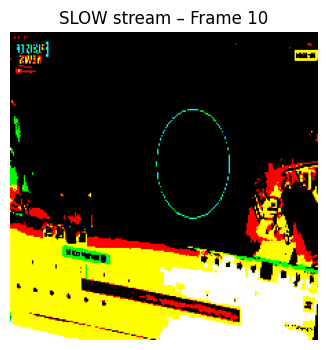

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
npz_path = "/content/Chain_Snatching09.npz"   # change if needed
frame_idx = 10                          # <-- frame you want to inspect
stream = "slow"                              # "slow" or "fast"

# ============================================================
# LOAD NPZ
# ============================================================
data = np.load(npz_path)
print("NPZ keys:", data.files)

video = data[stream]
print(f"{stream} shape:", video.shape)

# Expected shape: (C, T, H, W)
C, T, H, W = video.shape
assert frame_idx < T, "Frame index out of range"

# ============================================================
# EXTRACT FRAME
# ============================================================
frame = video[:, frame_idx, :, :]   # (C, H, W)

# Convert to (H, W, C)
frame = np.transpose(frame, (1, 2, 0))

# ============================================================
# NORMALIZE FOR DISPLAY
# ============================================================
if frame.max() <= 1.0:
    frame = (frame * 255).astype(np.uint8)
else:
    frame = frame.astype(np.uint8)

# ============================================================
# DISPLAY
# ============================================================
plt.figure(figsize=(4,4))
plt.imshow(frame)
plt.title(f"{stream.upper()} stream – Frame {frame_idx}")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# ============================================================
# LOAD NPZ
# ============================================================
npz_path = "/content/Chain_Snatching100.npz"
data = np.load(npz_path)

print("NPZ keys:", data.files)

# USE FAST STREAM
frames = data["fast"]   # (3, T, H, W)
print("Original shape:", frames.shape)

# ============================================================
# FIX SHAPE: (C,T,H,W) → (T,H,W,C)
# ============================================================
frames = np.transpose(frames, (1, 2, 3, 0))  # (T,H,W,3)

# Normalize to uint8 if needed
if frames.dtype != np.uint8:
    frames = np.clip(frames * 255, 0, 255).astype(np.uint8)

T = len(frames)
print("Fixed shape:", frames.shape)
print("Fixed dtype:", frames.dtype)

# ============================================================
# DEVICE & MODELS
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
cnn.eval()

yolo = YOLO("yolov8n.pt")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ============================================================
# INIT ARRAYS
# ============================================================
cnn_scores = []
motion_scores = []
force_scores = []
contact_flags = []

YOLO_INTERVAL = 5
last_area = 0.0

# ============================================================
# INITIAL FRAME
# ============================================================
prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

# ============================================================
# FRAME PROCESSING
# ============================================================
for t in range(1, T):

    frame = frames[t]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # ---- Motion ----
    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, gray, None,
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_score = float(np.mean(mag))
    motion_scores.append(motion_score)

    # ---- CNN ----
    img = transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = cnn(img)
    cnn_score = float(torch.mean(torch.abs(feat)).item())
    cnn_scores.append(cnn_score)

    # ---- YOLO ----
    if t % YOLO_INTERVAL == 0:
        results = yolo(frame, verbose=False)
        last_area = 0.0
        if results[0].boxes is not None:
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                last_area += (x2 - x1) * (y2 - y1)

    # ---- Force ----
    force_score = motion_score * (last_area + 1e-6)
    force_scores.append(force_score)

    # ---- Adaptive thresholds ----
    if len(force_scores) > 5:
        motion_thresh = max(0.5, np.mean(motion_scores[-5:]) * 1.2)
        force_thresh  = max(1000, np.mean(force_scores[-5:]) * 0.3)
        cnn_thresh    = np.mean(cnn_scores[-5:]) * 1.1
    else:
        motion_thresh = 0.5
        force_thresh  = 1000
        cnn_thresh    = 1.5

    # ---- Contact flag ----
    if (motion_score > motion_thresh and force_score > force_thresh) or cnn_score > cnn_thresh:
        contact_flags.append(1)
    else:
        contact_flags.append(0)

    prev_gray = gray

# ============================================================
# TO NUMPY
# ============================================================
cnn_scores = np.array(cnn_scores)
motion_scores = np.array(motion_scores)
force_scores = np.array(force_scores)
contact_flags = np.array(contact_flags)

# ============================================================
# SMOOTH CONTACT FLAGS
# ============================================================
for i in range(1, len(contact_flags) - 1):
    if contact_flags[i-1] + contact_flags[i] + contact_flags[i+1] < 2:
        contact_flags[i] = 0

# ============================================================
# OUTPUT
# ============================================================
print("\nCNN SCORES:")
print(cnn_scores)

print("\nMOTION SCORES:")
print(motion_scores)

print("\nFORCE SCORES:")
print(force_scores)

print("\nCONTACT FLAGS:")
print(contact_flags)

print("\nTotal Frames:", len(contact_flags))


NPZ keys: ['slow', 'fast']
Original shape: (3, 64, 224, 224)
Fixed shape: (64, 224, 224, 3)
Fixed dtype: uint8

CNN SCORES:
[1.386 1.377 1.92  1.912 1.821 1.832 1.818 1.818 1.744 1.747 1.703 1.698 1.777 1.768 1.676 1.65  1.692 1.504 1.488 1.53  1.48  1.502 1.76  1.821 1.819 2.001 1.951 1.828 1.825 1.78  1.599 1.679 1.626 1.821 1.761 1.805 1.675 1.804 1.825 1.636 1.764 1.556 1.693 1.728 1.607 1.603 1.657 1.689 1.773 1.762 1.822 1.548 1.636
 1.585 1.518 1.622 1.652 1.623 1.598 1.68  1.706 1.774 1.634]

MOTION SCORES:
[ 0.008  0.788  9.869  0.007  3.5    1.293  3.901  0.034  2.835  4.938  1.479  3.116  1.555  4.767  3.33   1.627  3.207  1.635  4.379  2.903  1.466  2.828  8.363  4.598  0.024  5.499  3.067  8.995  0.018  4.11   8.638  5.174  6.049  6.376  6.917  7.638 10.268 10.15   8.142  9.003  5.042 12.646  8.871  0.737  3.041
  0.033  4.918  3.486  4.485  0.024  2.564  5.14   1.863  1.126  1.97   1.803  1.814  0.861  0.954  2.079  2.211  1.281  1.434]

FORCE SCORES:
[     0.         0. 

In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching09.npz
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.0,
    off_threshold=1.85,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================




# =======================
# CNN SCORES
# =======================
cnn_scores = np.array([
    1.386, 1.377, 1.920, 1.912, 1.821, 1.832, 1.818, 1.818, 1.744, 1.747,
    1.703, 1.698, 1.777, 1.768, 1.676, 1.650, 1.692, 1.504, 1.488, 1.530,
    1.480, 1.502, 1.760, 1.821, 1.819, 2.001, 1.951, 1.828, 1.825, 1.780,
    1.599, 1.679, 1.626, 1.821, 1.761, 1.805, 1.675, 1.804, 1.825, 1.636,
    1.764, 1.556, 1.693, 1.728, 1.607, 1.603, 1.657, 1.689, 1.773, 1.762,
    1.822, 1.548, 1.636, 1.585, 1.518, 1.622, 1.652, 1.623, 1.598, 1.680,
    1.706, 1.774, 1.634
])

# =======================
# MOTION SCORES
# =======================
motion_scores = np.array([
    0.008, 0.788, 9.869, 0.007, 3.500, 1.293, 3.901, 0.034, 2.835, 4.938,
    1.479, 3.116, 1.555, 4.767, 3.330, 1.627, 3.207, 1.635, 4.379, 2.903,
    1.466, 2.828, 8.363, 4.598, 0.024, 5.499, 3.067, 8.995, 0.018, 4.110,
    8.638, 5.174, 6.049, 6.376, 6.917, 7.638, 10.268, 10.150, 8.142, 9.003,
    5.042, 12.646, 8.871, 0.737, 3.041, 0.033, 4.918, 3.486, 4.485, 0.024,
    2.564, 5.140, 1.863, 1.126, 1.970, 1.803, 1.814, 0.861, 0.954, 2.079,
    2.211, 1.281, 1.434
])

# =======================
# FORCE SCORES
# =======================
force_scores = np.array([
        0.000,     0.000,     0.000,     0.000, 15504.625,  5726.740,
    17281.988,   149.006, 12559.500,     0.000,     0.000,     0.000,
        0.000,     0.000,     0.000,     0.000,     0.000,     0.000,
        0.000,  3806.100,  1922.165,  3708.092, 10964.344,  6028.490,
      199.816, 45274.832, 25253.332, 74060.911,   145.992, 88750.659,
   186518.316,111723.253,130609.118,137680.001,  1106.744,  1222.008,
     1642.812,  1624.028,  1302.729,     0.000,     0.000,     0.000,
        0.000,     0.000, 10609.056,   115.969, 17160.502, 12161.698,
    15647.096,    13.090,  1400.189,  2806.267,  1017.188,   615.002,
        0.000,     0.000,     0.000,     0.000,     0.000,  2342.642,
     2491.874,  1443.685,  1615.851
])

# =======================
# CONTACT FLAGS
# =======================
contact_flags = np.array([
    0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 0, 0
])




# ============================================================
# RUN
# ============================================================

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_scores))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 63

Detected Events:
Event 1: Start=20, End=44, Duration=0.83s

Smoothed Confidence Array:
[5.879 5.639 5.161 4.861 4.543 3.999 3.589 3.345 3.252 3.055 2.936 2.94  2.928 2.748 2.678 2.614 2.559 2.475 2.586 2.529 2.468 2.327 2.332 2.301 2.316 2.541 2.619 2.531 2.484 2.836 3.238 3.083 3.059 3.015 3.048 2.805 2.644 2.501 2.42  2.349 2.366 2.35  2.791 3.132 2.877 2.813 2.666 2.642 2.523 2.603 2.472 2.398 2.401
 2.412 2.83  2.996 3.007 3.068 2.939 3.091 2.955 2.854 2.75 ]


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG 3 VIDEO
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.75,
    off_threshold=2.0,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 30

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.648,1.667,1.668,1.67,1.764,1.764,1.769,1.888,2.134,2.135,2.199,2.178,
2.259,2.256,2.374,2.377,2.356,2.347,2.347,2.142,2.143,2.18,2.176,2.076,
2.075,2.067,2.02,2.033,1.967,1.932,1.93,1.906,1.909,1.906,1.91,1.909,
1.902,1.925,1.919,1.919,2.008,2.007,2.039,2.033,2.03,2.029,2.041,2.023,
2.025,2.114,2.112,2.107,2.122,2.035,2.036,2.021,2.039,2.037,2.111,2.095,
2.093,2.065,2.016,2.01,1.983,1.983,1.988,1.934,1.925,1.924,1.981,2.011,
1.929,1.939,1.998,1.998,1.96,1.943,1.944,1.976,1.977,1.949,1.942,1.914,
1.914,1.905,1.89,1.932,1.874,1.871,1.868,1.858,1.793,1.792,1.849,1.847,
1.848,1.842,1.842,1.84,1.837,1.838,1.888,1.883,1.862,1.861,1.86,1.861,
1.861,1.826,1.826,1.865,1.861,1.778,1.78,1.774,1.726,1.737,1.813,1.813,
1.811,1.824,1.842,1.846,1.793,1.792,1.793,1.817,1.82,1.818,1.79,1.794,
1.794,1.8,1.8,1.769
])

motion_scores = np.array([
0.013,0.742,0.012,0.011,0.678,0.005,0.005,0.454,0.138,0.002,0.375,0.109,
0.422,0.007,0.549,0.013,0.141,0.129,0.003,0.86,0.009,0.497,0.067,0.478,
0.003,0.13,0.511,0.105,0.538,0.064,0.015,0.469,0.565,0.008,0.604,0.006,
0.067,0.703,0.061,0.004,0.567,0.039,0.539,0.058,0.548,0.007,0.056,0.049,
0.003,0.733,0.004,0.649,0.05,0.674,0.006,0.047,0.615,0.039,0.596,0.042,
0.003,0.576,0.418,0.024,0.43,0.007,0.072,0.512,0.085,0.004,0.413,0.058,
0.492,0.035,0.498,0.004,0.041,0.049,0.003,0.433,0.006,0.574,0.024,0.492,
0.004,0.024,0.406,0.032,0.445,0.011,0.003,0.398,0.427,0.005,0.405,0.005,
0.006,0.494,0.022,0.005,0.462,0.008,0.416,0.01,0.363,0.005,0.005,0.004,
0.002,0.306,0.003,0.362,0.014,0.362,0.003,0.007,0.353,0.103,0.356,0.015,
0.004,0.247,0.196,0.023,0.232,0.005,0.022,0.253,0.016,0.002,0.173,0.007,
0.002,0.169,0.002,0.148
])

force_scores = np.array([
0,0,0,0,158059.098,1110.293,1187.621,105873.994,32110.367,507.264,
92735.103,26883.287,104440.933,1692.43,94993.996,2295.937,24346.603,
22331.728,471.353,104676.094,1089.853,60525.742,8162.291,58167.693,
486.138,20621.112,80774.087,16528.33,85028.71,9396.546,2215.49,69113.501,
83324.086,1106.558,150128.482,1467.748,16751.207,174899.08,15118.862,
771.931,100740.693,6870.786,95725.363,10299.017,151427.025,1961.309,
15521.341,13529.081,949.214,223531.786,1210.165,197742.091,15245.917,
205521.632,843.475,6703.022,87770.407,5576.349,85034.858,15242.625,
1175.072,210188.357,152400.88,8836.424,79353.395,1232.165,13344.316,
94541.062,15696.116,1745.822,175343.1,24663.685,209146.249,15076.75,
284919.238,2165.649,23237.323,27764.522,1479.831,186777.639,2684.592,
247372.268,10352.456,212065.48,1706.006,10064.007,169631.358,13254.815,
186101.98,4109.614,1008.446,143152.449,153543.542,1783.099,153013.91,
1955.699,2149.656,186774.323,8378.046,2321.764,220377.944,3857.495,
198573.601,4648.378,92923.507,1152.932,1202.235,1087.664,425.448,
75171.461,848.245,88910.064,3443.734,88886.722,1812.249,3829.986,
184227.487,53551.186,185854.332,3721.391,861.036,59470.403,47169.04,
5590.22,64781.137,1270.693,6135.703,70663.618,4551.094,829.789,80981.954,
3345.575,733.747,79094.751,1163.252,72065.393
])

contact_flags = np.array([
1,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 128

Detected Events:
Event 1: Start=10, End=39, Duration=1.00s

Smoothed Confidence Array:
[2.661 2.885 2.824 2.781 3.146 2.734 2.447 2.527 2.784 2.891 2.893 2.74  2.832 2.663 2.841 2.708 2.67  2.636 2.55  2.796 2.604 2.69  2.564 2.622 2.46  2.403 2.526 2.427 2.54  2.387 2.257 2.365 2.485 2.315 2.533 2.349 2.253 2.549 2.395 2.254 2.456 2.34  2.512 2.397 2.611 2.44  2.354 2.283 2.208 2.635 2.481 2.771 2.608
 2.854 2.612 2.456 2.608 2.454 2.619 2.491 2.374 2.675 2.763 2.554 2.595 2.415 2.322 2.459 2.341 2.219 2.456 2.366 2.603 2.43  2.75  2.528 2.394 2.303 2.198 2.458 2.318 2.64  2.449 2.659 2.439 2.296 2.475 2.336 2.527 2.338 2.199 2.367 2.484 2.28  2.433 2.261 2.141 2.396 2.245 2.128 2.411 2.246 2.472 2.303 2.378 2.225
 2.119 2.044 1.99  2.112 2.028 2.181 2.093 2.201 2.077 1.992 2.212 2.157 2.356 2.202 2.087 2.145 2.162 2.08  2.132 2.033 1.974 2.077]


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG 5
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.75,
    off_threshold=2.0,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 30

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
    1.629, 1.569, 1.593, 1.642, 1.648, 1.646, 1.651, 1.656, 1.661, 1.675,
    1.665, 1.665, 1.659, 1.711, 1.710, 1.690, 1.695, 1.698, 1.708, 1.714,
    1.736, 1.753, 1.754, 1.754, 1.753, 1.748, 1.719, 1.743, 1.741, 1.742,
    1.782, 1.782, 1.769, 1.783, 1.785, 1.782, 1.793, 1.748, 1.771, 1.746,
    1.746, 1.743, 1.746, 1.709, 1.675, 1.676, 1.701, 1.705, 1.686, 1.785,
    1.713, 1.723, 1.737, 1.736, 1.732, 1.713, 1.700, 1.727, 1.741, 1.743,
    1.751, 1.764, 1.761, 1.748, 1.727, 1.729, 1.732, 1.780, 1.761
])

# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
    0.475, 0.680, 0.382, 0.365, 0.318, 0.014, 0.310, 0.503, 0.281, 0.285,
    0.285, 0.010, 0.026, 0.623, 0.257, 0.090, 0.238, 0.019, 0.217, 0.575,
    0.262, 0.337, 0.029, 0.015, 0.318, 0.514, 0.245, 0.267, 0.025, 0.017,
    0.286, 0.465, 0.232, 0.220, 0.020, 0.019, 0.190, 0.432, 0.189, 0.177,
    0.018, 0.015, 0.193, 0.424, 0.184, 0.043, 0.191, 0.015, 0.207, 0.582,
    0.272, 0.260, 0.278, 0.020, 0.026, 0.544, 0.196, 0.192, 0.172, 0.011,
    0.175, 0.329, 0.177, 0.166, 0.435, 0.015, 0.220, 0.565, 0.036
])

# =========================
# FORCE SCORES (RAW)
# =========================
force_scores = np.array([
        0.000,      0.000,      0.000,      0.000,  49701.366,   2110.355,
    48473.637,  78545.654,  43966.454,  80937.451,  80862.973,   2727.435,
     7459.984, 176710.861,  75868.893,  26608.518,  70394.513,   5728.023,
    64172.811, 149031.018,  68026.177,  87339.083,   7628.664,   3903.728,
   104920.393, 169256.343,  80878.103,  88043.543,   8117.674,   5054.908,
    86434.936, 140603.862,  70236.540,  66445.171,   4708.144,   4520.102,
    45174.969, 102687.178,  45037.012,  39686.723,   3939.686,   3348.618,
    43134.160,  94778.327,  45913.195,  10714.026,  47605.154,   3640.696,
    51830.025, 180336.890,  84327.623,  80577.733,  86048.745,   6210.080,
     6987.153, 148446.062,  53503.316,  52489.416,  47029.771,   5003.888,
    79963.219, 150297.007,  80780.287,  75687.528,  93640.007,   3210.260,
    47425.408, 121440.960,   7770.578
])

# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
    1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0
])

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 69

Detected Events:
Event 1: Start=10, End=39, Duration=1.00s

Smoothed Confidence Array:
[3.104 3.147 3.096 3.069 3.121 2.686 2.549 2.563 2.45  2.437 2.726 2.715 2.718 3.197 3.254 2.856 2.696 2.712 2.883 3.253 3.289 3.375 3.21  3.084 3.255 3.538 3.201 2.99  2.636 2.381 2.431 2.61  2.544 2.492 2.294 2.154 2.178 2.349 2.307 2.258 2.116 2.014 2.064 2.242 2.204 2.076 2.1   1.992 2.049 2.444 2.447 2.442 2.457
 2.257 2.119 2.407 2.343 2.303 2.264 2.12  2.194 2.414 2.406 2.384 2.473 2.26  2.246 2.478 2.287]


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG 6
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,
    off_threshold=1.6,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 30

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.52,1.515,1.504,1.503,1.502,1.509,1.5,1.495,1.493,1.493,1.504,1.51,
1.532,1.547,1.544,1.544,1.53,1.537,1.562,1.545,1.548,1.544,1.509,1.501,
1.507,1.52,1.517,1.516,1.512,1.543,1.546,1.545,1.549,1.549,1.552,1.639,
1.646,1.564,1.562,1.563,1.561,1.626,1.623,1.581,1.575,1.574,1.577,1.611,
1.615,1.602,1.603,1.603,1.603,1.597,1.598,1.591,1.59,1.59,1.59,1.588,
1.588,1.595,1.596,1.596,1.597,1.59,1.573,1.572,1.573,1.573,1.574,1.576,
1.59,1.594,1.588,1.588,1.59,1.59,1.582,1.581,1.574,1.574,1.575,1.585,
1.59,1.593,1.581,1.581,1.588,1.58,1.568,1.569,1.572,1.572,1.572,1.572,
1.585,1.584,1.571,1.571,1.583,1.584,1.583,1.583,1.591,1.591,1.582,1.58,
1.612,1.611,1.611,1.613,1.614,1.613,1.604,1.571,1.571,1.57,1.584,1.583,
1.605,1.596,1.594,1.594,1.595,1.596,1.564,1.606,1.608,1.608,1.562,1.561,
1.556,1.577,1.577,1.576,1.545,1.543,1.543,1.542,1.545,1.545,1.573,1.556,
1.559,1.531,1.531,1.531,1.565,1.547,1.547,1.549,1.551,1.55,1.554,1.565
])

# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
0.436,0.187,0.032,0.004,0.4,0.031,0.284,0.117,0.006,0.0,0.246,0.088,
0.32,0.156,0.021,0.004,0.242,0.216,0.323,0.195,0.016,0.009,0.266,0.254,
0.015,0.144,0.018,0.014,0.174,0.149,0.015,0.157,0.009,0.001,0.199,0.25,
0.018,0.176,0.017,0.02,0.204,0.266,0.03,0.154,0.175,0.007,0.024,0.179,
0.041,0.193,0.007,0.001,0.0,0.334,0.022,0.078,0.003,0.0,0.0,0.421,0.013,
0.11,0.003,0.0,0.008,0.728,0.133,0.02,0.027,0.001,0.022,0.215,0.316,
0.036,0.081,0.002,0.005,0.0,0.181,0.062,0.196,0.002,0.003,0.115,0.198,
0.017,0.187,0.004,0.326,0.118,0.258,0.009,0.712,0.029,0.099,0.003,0.173,
0.01,0.217,0.004,0.299,0.007,0.013,0.003,0.159,0.003,0.1,0.008,0.162,
0.021,0.214,0.009,0.093,0.002,0.215,0.243,0.006,0.008,0.115,0.004,0.292,
0.328,0.009,0.001,0.238,0.015,0.494,0.526,0.027,0.023,0.292,0.005,0.48,
0.428,0.012,0.001,0.368,0.686,0.016,0.655,0.01,0.001,0.315,0.536,0.009,
0.291,0.013,0.001,0.189,0.379,0.017,0.454,0.016,0.001,0.305,0.476
])

# =========================
# FORCE SCORES
# =========================
force_scores = np.array([
0,0,0,0,14721.492,1157.057,10474.407,4294.661,220.714,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,9544.895,966.05,10036.167,552.428,36.726,20981.021,
26381.135,1917.653,18596.179,1766.763,2372.685,23820.134,31049.462,3451.225,
17969.568,0,0,0,0,0,0,0,0,0,0,801.79,2855.027,125.199,9.94,17.848,15161.24,
455.077,3974.889,112.403,7.761,284.467,25176.346,4602.71,705.717,922.725,
0,0,0,0,0,5573.838,141.004,370.584,19.071,12411.854,2273.033,7226.845,
75.13,111.851,4229.906,15101.102,1261.947,14241.502,275.112,24891.844,
4394.617,9582.37,335.036,26447.417,1073.63,3547.073,111.701,6207.604,
345.679,7797.082,283.124,20411.63,449.017,912.364,215.331,19576.946,
361.439,12245.103,938.085,19869.377,4063.618,42297.77,1764.391,18487.032,
476.101,8176.45,9215.106,236.05,313.936,4354.581,441.759,33337.61,
37495.236,1056.313,83.666,8780.237,560.838,18199.103,19388.752,981.581,
921.224,11436.749,209.988,18819.292,16789.844,1615.887,99.573,50415.145,
93874.634,2135.306,0,0,0,0,0,0,0,0,0,0,23569.116,1032.819,28237.39,
990.805,59.064,0,0
])

# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
1,1,1,1,1,
*([0] * (len(cnn_scores) - 5))
])

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 156

Detected Events:
Event 1: Start=35, End=64, Duration=1.00s
Event 2: Start=110, End=139, Duration=1.00s

Smoothed Confidence Array:
[2.956 2.88  2.777 2.696 2.805 2.429 2.269 2.086 1.91  1.785 1.775 1.722 1.761 1.743 1.69  1.647 1.685 1.705 1.759 1.753 1.697 1.654 1.69  1.709 1.653 1.656 1.62  1.593 1.621 1.673 1.642 1.692 1.654 1.623 1.728 1.861 1.808 1.847 1.772 1.723 1.812 1.935 1.861 1.881 1.842 1.763 1.715 1.737 1.713 1.738 1.699 1.671 1.65
 1.735 1.703 1.702 1.67  1.646 1.629 1.791 1.736 1.739 1.698 1.667 1.649 1.93  1.878 1.794 1.739 1.689 1.661 1.7   1.762 1.722 1.724 1.684 1.659 1.638 1.715 1.701 1.745 1.694 1.66  1.685 1.764 1.722 1.781 1.723 1.86  1.826 1.856 1.774 2.011 1.892 1.837 1.759 1.778 1.724 1.768 1.711 1.828 1.758 1.712 1.675 1.76  1.711
 1.742 1.699 1.785 1.752 1.909 1.829 1.851 1.782 1.819 1.847 1.767 1.711 1.721 1.683 1.853 1.994 1.88  1.795 1.834 1.769 1.914 2.041 1.923 1.838 1.879 1.786 1.921 2.    1.882 1.791 1.989 2.361 2.127 2.148 1.97  1.

In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG 1
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,
    off_threshold=1.6,
    min_duration_seconds=0.3,
    warm_up_frames=10,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 58

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.965,1.98,1.958,1.945,1.94,1.939,1.895,1.884,1.904,1.91,
1.954,1.941,1.942,1.892,1.855,1.872,1.859,1.838,1.858,1.866,
1.862,1.806,1.774,1.765,1.788,1.763,1.764,1.747,1.811,1.858,
1.887,1.914,1.913,1.912,1.938,1.879,1.85,1.851,1.825,1.868,
1.848,1.844,1.865,1.818,1.833,1.779,1.821,1.838,1.85,1.845,
1.895,1.911,1.894,1.887,1.894,1.892,1.886,1.885,1.889,1.818,
1.775,1.745,1.793,1.807,1.803,1.873,1.918,1.941,1.918,1.919,
1.927,1.874,1.866,1.837,1.801,1.841,1.845,1.833,1.892,1.862,
1.746,1.765,1.799,1.825,1.906,1.95,1.824,1.788,1.868,1.875,
1.827,1.833,1.901,1.926,1.924,1.952,1.986,1.987,1.994,2.001,
1.957,1.913,1.89,1.833,1.819,1.816,1.783,1.797,1.802,1.866,
1.862,1.867,1.885,1.898,1.91,1.892,1.893,1.889,1.858,1.879,
1.878,1.947,1.914,1.922,1.951,1.981,1.98,1.948,1.92,1.94,
2.003,1.973,1.931,1.951,1.875,1.824,1.817,1.846,1.849,1.881,
1.905,1.869,1.917,1.907,1.961,1.961,1.969,1.929,1.891,1.904,
2.024,2.087,2.046,2.022,2.061,2.09,2.016,1.939,1.992,
2.026,2.002,2.002,2.007,1.952,1.911,1.852,1.853,1.861,1.878,
1.925,1.94,1.927,1.912,1.894,1.905,1.911,1.943,1.938,1.954,
1.979,1.938,1.918,1.901,1.915,1.914,1.928,1.936,1.912,1.948,
1.901,1.881,1.838,1.841,1.832,1.761,1.77,1.777,1.781,1.825,
1.811,1.824,1.808,1.827,1.834,1.804,1.787,1.803,1.791,1.774,
1.774,1.772,1.844,1.88,1.837,1.821,1.85,1.82,1.835,1.82,
1.753,1.77,1.806,1.78,1.753,1.719,1.713,1.776,1.785,1.77,
1.8,1.782,1.755,1.787,1.855,1.87,1.905,1.891,1.901,1.872,
1.787,1.78,1.767,1.813,1.832,1.916,1.889,1.917,1.991,2.022,
1.988,1.981,2.026,2.071,2.08,2.027,1.981,1.996,1.994
])

# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
0.656,0.802,0.945,0.961,0.88,0.96,1.257,1.283,1.18,1.232,
1.382,1.309,1.184,1.192,1.333,1.21,1.18,0.999,1.062,1.268,
1.244,1.209,1.072,0.938,1.005,1.321,1.251,1.22,1.549,1.499,
1.395,1.727,1.427,1.55,1.576,1.509,1.435,1.478,1.404,1.248,
1.196,1.224,1.267,1.117,0.849,0.893,0.842,0.836,0.604,0.606,
0.586,0.702,0.596,0.783,0.884,0.898,0.742,0.869,0.987,0.935,
0.779,1.122,0.896,0.943,0.704,0.887,0.875,0.843,0.685,0.806,
0.923,0.959,0.883,0.98,0.946,0.935,0.648,0.754,0.904,1.211,
0.832,0.839,0.58,0.608,0.663,0.784,0.814,0.859,0.733,0.595,
0.567,0.493,0.632,0.681,0.809,0.661,0.586,0.455,0.476,0.293,
0.272,0.237,0.495,0.621,0.64,0.499
])


# =========================
# FORCE SCORES
# =========================


force_scores = np.array([
0.,0.,0.,0.,348816.059,380538.57,498395.946,508625.263,467745.71,
615881.294,690904.879,654731.648,591849.361,596105.456,649586.021,
589356.421,575083.309,486595.252,517475.146,589690.228,578667.511,
562322.373,498669.179,435935.344,430206.305,565354.004,535407.89,
522159.169,663114.218,589247.587,548249.431,678815.064,560883.131,
609524.81,524176.269,501940.385,477040.864,491478.364,466733.437,
302856.813,290432.112,297048.445,307466.982,271126.031,287821.608,
302759.386,285493.068,283501.541,204817.444,291015.586,281756.908,
337328.687,286241.489,376463.955,232301.219,236028.912,194850.614,
228191.709,259214.737,524350.604,437147.401,629168.855,502405.159,
529059.301,241094.675,303803.073,299623.686,288635.751,234406.154,
280517.301,321455.578,333974.245,307427.354,341031.763,408400.462,
403514.674,279824.467,325558.604,390245.226,626484.23,430385.237,
433951.637,299916.185,314429.455,282354.145,334036.647,346831.309,
365811.676,312224.939,384183.966,366156.781,318186.821,408342.318,
439844.213,229518.631,187578.193,166152.562,129069.479,135091.228,
78911.84,73238.113,63993.413,133401.442,167362.713,193138.13,
150626.722,117238.348,131192.912,150676.822,181200.803,219939.217,
224014.171,248847.458,240160.991,263290.402,270091.569,319189.249,
249928.045,362261.58,411300.329,434184.176,347849.277,453870.747,
509829.547,432063.656,421030.047,361516.809,373569.967,326394.386,
321472.174,382766.688,305910.205,302863.804,270536.15,214054.254,
227035.024,214110.714,173095.85,165256.815,229488.862,229631.818,
260365.56,294470.751,303596.228,214291.509,192017.689,223190.917,
314240.699,343907.27,408561.648,396245.531,375181.533,315509.276,
242179.682,196958.222,305494.778,273112.146,358378.771,313716.731,
254565.637,303411.424,220171.404,244367.402,319413.285,192857.533,
137396.128,166424.352,156055.339,127694.838,160497.236,189759.559,
137456.911,126229.317,117468.419,166176.656,256600.033,287621.438,
170415.79,453139.975,289050.754,281712.907,275345.711,230606.698,
190621.209,165836.302,162869.989,202228.237,215818.089,187456.766,
238909.785,248611.543,259156.54,244674.898,222561.105,0.,0.,0.,0.,0.,
120708.18,125623.387,100666.826,126649.529,68569.894,36487.665,
63800.643,62208.751,78369.097,69481.638,75635.03,108178.553,
119775.615,114553.008,143358.275,275068.176,359415.203,347300.415,
490006.657,450831.868,298336.018,207199.16,236046.54,274128.802,
252207.489,0.,0.,0.,0.,0.,135341.893,128591.178,126707.35,
125343.477,116471.254,552439.166,575002.325,647625.357,711057.216,
749872.551,288991.172,259614.71,230352.171,255323.182,276826.906,
887174.318,873051.443,817121.067,760697.898,725236.314,163664.202,
182193.608,173257.641,144356.699,153004.953,179483.685,148182.232,
143624.399,114751.486
])



# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0
])


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 106

Detected Events:
Event 1: Start=10, End=67, Duration=1.93s

Smoothed Confidence Array:
[3.621 3.669 3.739 3.789 3.95  3.8   4.122 4.356 4.178 4.134 4.195 4.196 4.132 4.076 4.092 4.045 3.993 3.857 3.801 3.857 3.883 3.867 3.777 3.644 3.576 3.674 3.708 3.713 3.895 3.989 4.015 4.198 4.184 4.232 4.244 4.205 4.136 4.108 4.047 3.899 3.769 3.687 3.654 3.556 3.419 3.326 3.251 3.201 3.066 3.008 2.972 3.011 2.979
 3.05  3.069 3.088 3.034 3.049 3.11  3.231 3.217 3.385 3.395 3.431 3.258 3.241 3.237 3.226 3.141 3.138 3.191 3.229 3.218 3.246 3.274 3.3   3.179 3.143 3.208 3.44  3.368 3.327 3.173 3.088 3.055 3.103 3.114 3.133 3.109 3.084 3.036 2.961 3.01  3.08  3.076 3.018 2.957 2.858 2.8   2.983 3.088 2.835 2.758 2.739 2.739 2.677]


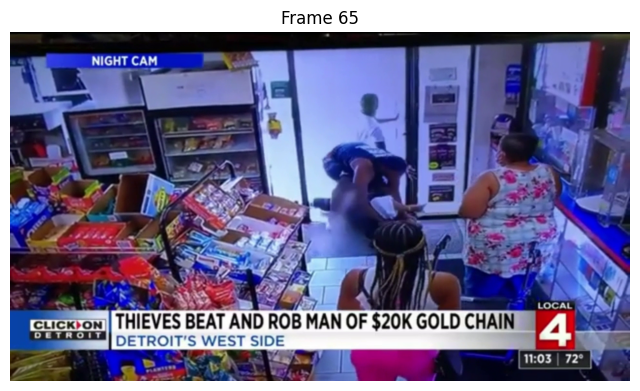

In [ ]:
import cv2
import matplotlib.pyplot as plt

frame_idx = 65
 # frame you want to check
video_path = "/content/kag_1.mp4"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()

if ret:

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("Could not read frame")

cap.release()


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG 2
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,
    off_threshold=1.6,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 58

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.677,1.68,1.677,1.708,1.667,1.648,1.642,1.638,1.625,1.615,1.622,1.608,1.61,1.605,
1.621,1.592,1.595,1.59,1.566,1.518,1.545,1.573,1.569,1.558,1.615,1.678,1.635,
1.635,1.643,1.625,1.637,1.541,1.542,1.548,1.537,1.581,1.569,1.584,1.572,1.56,
1.562,1.573,1.574,1.514,1.513,1.516,1.518,1.519,1.532,1.524,1.524,1.472,1.47,
1.46,1.505,1.48,1.491,1.489,1.51,1.488,1.485,1.487,1.489,1.64,1.664,1.631,
1.634,1.634,1.639,1.666,1.638,1.637,1.635,1.637,1.727,1.718,1.772,1.766,
1.786,1.796,1.737,1.692,1.694,1.703,1.709,1.563,1.59,1.588,1.583,1.549,
1.555,1.541,1.543,1.649,1.712,1.705,1.626,1.626,1.647,1.673,1.833,1.782,
1.782,1.808,1.765,1.724,1.794,1.794,1.823,1.749,1.746,1.665,1.664,1.662,
1.645,1.838,1.845,1.846,1.857,1.828,1.689,1.689,1.693,1.747,1.752,1.769,
1.742,1.742,1.943,1.915,1.838,1.771,1.773,1.758,1.785,1.863,1.869,1.868,
1.909,1.917,1.933,1.902,1.904,1.876,1.866,1.872,1.867,1.867,1.979,1.984,
1.869,1.855,1.855,1.862,1.774,1.757,1.758,1.754,1.749,1.822,1.767,1.853,
1.853,1.84,1.836,1.807,1.876,1.876,1.869,1.894,1.74,1.741,1.743,1.701,
1.687,1.664,1.669,1.665,1.612,1.594,1.593,1.618,1.613,1.64,1.67,1.661,
1.521,1.523,1.526,1.686,1.677,1.68,1.69,1.662,1.683,1.672,1.674,1.673,
1.651,1.635,1.602,1.601,1.6,1.597,1.577,1.677,1.676,1.665,1.666,1.731,
1.754,1.757,1.727,1.719,1.745,1.738,1.741
])


# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
0.373,0.988,0.019,0.926,1.331,0.201,0.847,0.024,1.996,0.653,0.762,0.253,0.033,
1.418,0.902,2.26,0.174,0.021,1.041,1.764,1.203,1.145,0.033,0.22,2.51,1.163,
1.888,0.018,0.298,1.108,1.35,2.237,0.032,1.096,0.314,1.233,0.895,0.036,1.818,
0.342,0.498,0.33,0.008,0.902,0.232,0.263,1.542,0.013,0.737,0.726,0.238,1.348,
0.015,0.593,1.577,0.572,0.15,0.027,1.184,0.416,0.61,0.226,0.033,2.157,1.861,
0.326,0.533,0.008,0.209,0.507,1.918,0.46,0.032,0.236,2.546,0.705,2.204,0.031,
0.859,0.144,0.919,3.309,0.034,0.897,0.26,3.029,1.125,0.016,0.893,3.568,0.204,
1.06,0.015,3.311,1.52,0.705,3.241,0.027,1.035,1.074,3.347,0.795,0.011,1.049,
2.682,0.861,0.462,0.033,0.633,3.063,0.984,2.161,0.045,0.189,0.664,2.168,
0.33,0.028,0.174,0.353,1.26,0.436,0.013,1.626,0.199,0.508,0.762,0.041,
1.265,0.454,0.87,1.776,0.012,0.695,0.373,1.37,0.962,0.025,1.412,2.329,
0.496,0.652,0.016,1.172,0.564,0.18,0.395,0.019,1.699,0.413,0.961,0.19,
0.027,0.431,1.5,0.44,0.109,0.08,0.481,1.529,0.965,1.994,0.016,0.315,
0.867,0.95,2.239,0.017,0.151,0.88,1.972,0.921,0.026,1.956,0.237,0.582,
0.738,0.02,2.02,0.181,0.765,2.31,0.035,0.83,0.696,0.21,1.366,0.027,
0.592,1.994,0.171,0.044,0.523,1.8,0.299,0.36,0.03,0.206,0.986,0.655,
1.374,0.021,0.245,0.616,0.867,1.626,0.02,1.114,0.256,1.666,1.026,
0.041,2.161,0.25,1.113,1.188,0.022
])


# =========================
# FORCE SCORES
# =========================


force_scores = np.array([
0,0,0,0,499474.025,75480.348,317727.344,8819.43,749167.89,311248.878,
363179.879,120334.302,15765.661,675418.082,382475.003,958269.441,
73604.852,9024.549,441289.843,948874.805,646968.987,615685.918,
17531.642,118212.237,1412406.067,654159.532,1062233.741,9889.019,
167748.246,531481.502,647904.038,1073260.97,15316.342,526008.566,
129067.082,506716.026,367960.506,14622.737,747256.33,226836.642,
329517.202,218308.406,5537.791,597424.284,156270.178,177051.255,
1039235.752,8932.926,496432.215,358874.522,117466.741,666289.676,
7556.359,293081.759,739976.202,268227.116,70579.493,12561.185,
555589.91,163062.294,238983.383,88668.948,12893.851,844404.767,
1394093.791,244273.827,399548.994,6060.74,156326.152,362447.458,
1370869.377,328630.584,22588.773,168834.097,2286502.171,633427.98,
1979971.289,28245.602,771949.332,149910.523,958580.259,3450046.837,
35483.396,935377.114,188572.509,2200346.207,817337.67,11734.287,
648845.977,2055934.919,117580.208,610930.188,8767.064,1907680.236,
368501.283,170977.996,785673.264,6596.194,250822.099,9890.881,
30828.798,7321.713,100.765,9665.826
])




# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,
1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0
])



# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 104

Detected Events:
Event 1: Start=20, End=77, Duration=1.93s

Smoothed Confidence Array:
[3.05  3.235 3.074 3.242 3.512 3.02  2.888 2.521 2.916 2.749 2.671 2.438 2.201 2.806 3.055 3.677 3.111 2.662 2.684 3.246 3.453 3.286 2.782 2.491 3.104 3.082 3.307 2.811 2.565 2.962 3.326 3.855 3.172 3.059 2.708 3.084 3.23  2.748 3.006 2.694 2.533 2.363 2.129 2.267 2.124 2.036 2.434 2.164 2.239 2.273 2.13  2.395 2.123
 2.127 2.478 2.374 2.16  1.968 2.234 2.149 2.154 2.029 1.878 2.827 3.458 3.029 2.805 2.457 2.288 2.585 3.295 2.964 2.577 2.381 3.147 2.985 3.454 2.96  2.932 2.648 2.734 3.714 3.121 3.046 2.739 3.487 3.326 2.811 2.767 3.65  3.093 2.999 2.567 3.751 3.927 3.487 3.969 3.275 3.119 3.008 3.662 3.337 2.874 2.87 ]


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#KAG4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,
    off_threshold=1.6,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 58

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.725,1.72,1.674,1.66,1.69,1.714,1.667,1.656,1.642,1.66,1.706,1.693,1.678,1.654,
1.683,1.749,1.74,1.767,1.702,1.698,1.727,1.694,1.72,1.721,1.684,1.705,1.731,
1.697,1.692,1.705,1.677,1.66,1.622,1.641,1.666,1.709,1.676,1.667,1.685,
1.696,1.726,1.709,1.688,1.676,1.699,1.697,1.694,1.746,1.759,1.752,1.741,
1.726,1.719,1.691,1.694,1.723,1.695,1.716,1.725,1.721,1.704,1.738,1.742,
1.754,1.752,1.738,1.738,1.764,1.78,1.786,1.739,1.763,1.798,1.817,1.802,
1.764,1.785,1.807,1.82,1.758,1.762,1.779,1.802,1.835,1.809,1.754,1.804,
1.79,1.766,1.866,1.813,1.802,1.942,1.821,1.805,1.797,1.863,1.922,1.997,
1.916,1.89,1.809,1.858,1.712,1.649,1.606,1.503,1.546,1.433,1.407,1.452,
1.447,1.416,1.474,1.478,1.538,1.536,1.514,1.506,1.465,1.48,1.5,1.443,
1.475,1.494,1.552,1.696,1.819,1.687,1.693,1.779,1.718,1.784,1.805,1.844,
1.673,1.591,1.569,1.538,1.476,1.517,1.508,1.467,1.428,1.446,1.426,1.393,
1.399,1.451,1.416,1.295,1.334,1.338,1.326,1.293,1.732,1.73,1.687,1.699,
1.684,1.673,1.681,1.705,1.775,1.847,1.827,1.71,1.786,1.844,1.839,1.803,
1.822,1.852,1.824,1.776
])


# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
1.137,1.092,1.081,1.092,1.15,1.128,1.196,1.217,1.13,1.084,1.107,0.979,0.989,
0.982,0.998,0.885,0.817,0.897,0.869,0.902,1.022,1.042,1.141,1.059,1.105,
1.143,1.038,1.058,0.989,0.926,0.879,0.873,0.8,0.801,0.849,0.793,0.856,
0.841,0.918,0.941,0.917,0.9,0.915,0.93,0.876,0.848,0.849,0.839,0.838,
0.863,0.895,0.91,0.985,1.042,0.977,1.02,1.028,0.99,0.999,1.0,1.005,
0.959,0.97,0.904,0.943,0.876,0.929,0.953,0.915,0.903,0.926,1.022,
0.899,0.961,0.918,1.055,1.142,1.171,1.341,1.487,1.537,1.734,1.922,
2.215,2.39,2.515,2.777,3.066,3.5,3.717,4.0,4.27,4.901,5.085,4.747,
4.668,4.765,4.715,4.769,4.759,4.698,4.966,4.57,4.375,4.91,4.766,
4.224,4.204,3.849,3.591,3.758,3.655,3.334,3.029,2.738,2.626,2.293,
2.036,1.861,1.713,1.711,1.605,1.418,1.569,1.757,2.034,2.115,2.368,
2.781,2.989,3.083,3.344,3.555,3.746,3.772,3.956,4.109,4.214,4.243,
4.591,4.668,4.954,4.834,5.052,4.611,4.339,4.056,4.084,3.654,3.411,
3.125,2.813,2.55,2.329,2.096,2.739,1.492,1.559,1.635,1.674,1.607,
1.577,1.636,1.507,1.579,1.558,1.65,1.485,1.449,1.355,1.378,1.272,
1.287,1.34,1.453
])



# =========================
# FORCE SCORES
# =========================


force_scores = np.array([
0,0,0,0,89654.835,87902.755,93238.135,94851.764,88065.019,84235.17,
85975.036,76066.555,76808.753,76300.791,85908.352,76209.166,70349.073,
77178.87,74769.671,74432.889,84394.504,86010.715,94218.533,87409.117,
132966.517,137654.685,124984.374,127412.812,119000.023,95326.471,
90496.308,89886.904,82280.862,82401.667,95724.857,89359.472,96480.871,
94790.458,103489.911,103414.925,100782.981,98964.216,100613.715,
102228.538,109214.397,105644.95,105849.247,104554.244,104453.532,
117326.139,121652.654,123702.766,133915.283,141717.463,148414.112,
155042.973,156204.118,150455.532,151771.659,164319.892,165233.928,
157637.953,159416.31,148638.135,202446.853,188110.111,199318.816,
204525.004,196464.333,231150.265,236995.186,261702.522,230330.712,
246088.803,247353.085,284293.009,307657.357,315392.375,361327.614,
447923.652,463107.121,522304.913,578988.089,667175.056,886695.329,
933265.946,1030445.872,1137554.929,1298778.72,1684564.396,1812981.634,
1935385.547,2221392.747,2304641.746,4547297.928,4470737.702,4564541.05,
4516589.798,4568241.518,3029348.788,2990443.037,3161134.056,2908875.686,
2784490.429,2382562.058,2312358.335,2049719.414,2039598.954,1867606.427,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,451986.127,466076.557,
505563.032,537484.359,566379.923,1392770.789,1460975.91,1517463.106,
1556292.237,1566856.771,1105053.716,1123574.217,1192369.728,1163375.64,
1215912.29,170870.727,160793.576,150310.544,151351.295,135420.935,
0,0,0,0,0,0,0,0,0,0,280223.338,268992.498,263960.099,273793.96,
252234.741,140540.54,138644.664,146782.451,132147.839,128972.694,
93275.502,94837.853,87578.362,88586.537,92238.17,101436.24
])





# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])



# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 175

Detected Events:
Event 1: Start=20, End=77, Duration=1.93s

Smoothed Confidence Array:
[3.862 3.847 3.819 3.799 3.817 3.53  3.336 3.204 3.08  2.985 2.939 2.864 2.81  2.763 2.744 2.716 2.673 2.675 2.649 2.639 2.678 2.701 2.755 2.768 2.783 2.812 2.807 2.8   2.772 2.736 2.688 2.647 2.585 2.548 2.544 2.537 2.542 2.538 2.564 2.593 2.615 2.619 2.621 2.623 2.616 2.602 2.591 2.596 2.603 2.614 2.629 2.639 2.667
 2.696 2.699 2.722 2.733 2.734 2.741 2.746 2.746 2.741 2.743 2.727 2.731 2.708 2.709 2.725 2.729 2.732 2.727 2.762 2.758 2.78  2.778 2.809 2.865 2.919 3.016 3.114 3.2   3.328 3.485 3.698 3.907 4.377 4.806 4.895 5.092 5.35  5.608 5.874 6.311 6.641 6.913 7.072 7.239 7.355 7.478 7.436 7.378 7.405 7.303 7.121 7.109 7.04
 6.78  6.605 6.331 5.931 5.715 5.531 5.297 5.059 4.806 4.613 4.378 4.13  3.901 3.684 3.536 3.407 3.243 3.183 3.204 3.318 3.466 3.682 3.918 4.147 4.391 4.623 5.171 5.62  5.656 5.74  5.824 5.911 5.974 6.105 6.202 6.353 6.416 6.512 6.455 6.259 6.027 5.874 5.65

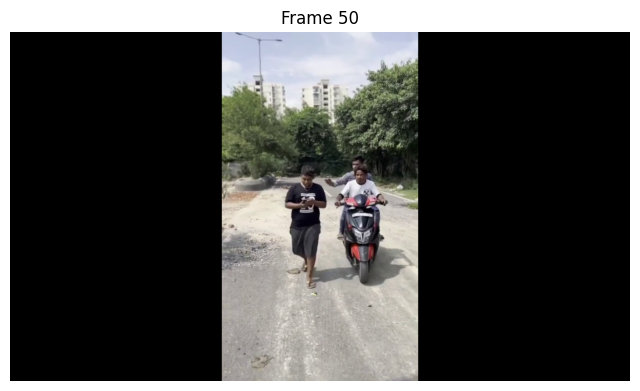

In [ ]:
import cv2
import matplotlib.pyplot as plt

frame_idx = 50
video_path = "/content/kag_4.mp4"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("Could not read frame")

cap.release()


In [ ]:
import numpy as np

# ============================================================
# EVENT TEMPORAL CONSISTENCY ENGINEER
# (EMA + Group Averaging + Hard Stop + Re-arm Lock)
#CHAIN SNATCHING 17
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.8,
    off_threshold=1.6,
    min_duration_seconds=0.3,
    warm_up_frames = 15,
    contact_grace_frames=10,
    group_size=10
):
    # ---------------- SAFE ALIGNMENT ----------------
    T = min(
        len(cnn_score),
        len(motion_score),
        len(force_score),
        len(contact_flag)
    )

    cnn_score    = np.asarray(cnn_score[:T])
    motion_score = np.asarray(motion_score[:T])
    force_score  = np.asarray(force_score[:T])
    contact_flag = np.asarray(contact_flag[:T])

    # ---------------- FORCE NORMALIZATION ----------------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ====================================================
    # FRAME CONFIDENCE + EMA
    # ====================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ====================================================
    # GROUP AVERAGING
    # ====================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ====================================================
    # EVENT DETECTION (HARD STOP + LOCK)
    # ====================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 25

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # ---- START EVENT ----
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # ---- EVENT ACTIVE ----
        elif in_event:
            duration_frames = t - start + 1

            # HARD STOP
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_scores = np.array([
1.6315, 1.6659, 1.63, 1.6256, 1.633, 1.6275, 1.5863, 1.5813, 1.5817, 1.5824,
1.61, 1.5402, 1.5439, 1.5527, 1.5672, 1.5561, 1.5257, 1.5392, 1.5053, 1.5066,
1.4869, 1.4776, 1.4776, 1.5158, 1.5248, 1.531,
1.5252, 1.5241, 1.5384, 1.5236, 1.5425, 1.6203, 1.6209, 1.6076, 1.6142,
1.5762, 1.5972, 1.5665, 1.5705, 1.5702, 1.5741, 1.5628, 1.5523, 1.4823,
1.4853, 1.4893, 1.4866, 1.4854, 1.4397, 1.4937, 1.4935, 1.4769,
1.4737, 1.4367, 1.4843, 1.5046, 1.4995, 1.4993, 1.5517, 1.5453, 1.5458,
1.5278, 1.5373, 1.5432, 1.5427, 1.546, 1.5388, 1.5686, 1.566, 1.6203,
1.6446, 1.6276, 1.5277, 1.5358, 1.534, 1.603, 1.6268, 1.6334,
1.6086, 1.6421, 1.6428, 1.6549, 1.6205, 1.6168
])


# =========================
# MOTION SCORES
# =========================
motion_scores = np.array([
1.5287, 0.090134, 0.78191, 0.033117, 0.71561, 0.80958, 1.9291, 0.042698,
0.013103, 0.75203, 0.74732, 0.81388, 1.485, 0.04679, 0.68331, 0.63322,
0.54453, 1.0514, 0.4073, 0.029406, 0.39338, 0.36975, 0.033634, 0.97413,
0.34432, 0.036541, 0.032354, 0.0042373, 0.37901, 0.36527, 0.39668,
0.90156, 0.037916, 0.3653, 0.018589, 0.407, 0.41553, 0.88278, 0.033945,
0.38349, 0.017183, 0.38272, 0.36533, 0.85058, 0.017912, 0.35693,
0.014783, 0.32633, 0.28625, 0.71522, 0.01629, 0.29132, 0.014491,
0.3002, 0.26622, 0.78423, 0.041354, 0.016316, 0.28139, 0.35724,
0.41397, 0.96611, 0.056764, 0.46865, 0.42637, 0.019957, 0.38468,
0.8033, 0.024031, 0.27404, 0.29152, 0.26944, 0.52006, 0.25623,
0.022262, 0.2903, 0.26632, 0.30185, 0.54927, 0.30644, 0.036392,
0.34192, 0.37562, 0.38677
])



# =========================
# FORCE SCORES
# =========================


force_scores = np.array([
1.5287e-06, 9.0134e-08, 7.8191e-07, 3.3117e-08, 66370, 75085, 178910,
3960, 1215.3, 96795, 96189, 104760, 191130, 6022.5, 110940, 102810,
88411, 170700, 66131, 4554.8, 60931, 57272, 5209.7, 150890, 74197,
7874.1, 6971.9, 913.11, 81674, 47628, 51724, 117560, 4944, 47632,
5416.8, 118600, 121080, 257230, 9891.2, 68309, 3060.8, 68173, 65075,
151510, 3300.9, 65778, 2724.3, 60137, 52751, 138970, 3165.3, 56604,
2815.6, 58332, 55414, 163240, 8607.8, 3396.2, 58572, 67214, 77887,
181770, 10680, 88174, 74192, 3472.7, 66939, 139780, 4181.7, 62709,
66709, 61657, 119010, 58634, 4525.8, 59017, 54143, 61365, 111670,
63761, 7572.1, 71144, 78154, 80476
])





# =========================
# CONTACT FLAGS
# =========================
contact_flags = np.array([
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

contact_flag = np.array([
1,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])

# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_scores,
    motion_scores,
    force_scores,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(smoothed_conf))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)


Total Frames: 84

Detected Events:
Event 1: Start=15, End=39, Duration=0.83s

Smoothed Confidence Array:
[4.16  3.739 3.641 3.346 3.424 3.216 3.514 2.952 2.546 2.596 2.636 2.674
 3.003 2.589 2.617 2.609 2.55  2.761 2.584 2.275 2.228 2.18  1.986 2.313
 2.266 2.066 1.921 1.805 1.934 1.976 2.025 2.311 2.121 2.132 1.989 2.125
 2.233 2.598 2.311 2.284 2.08  2.119 2.134 2.371 2.114 2.111 1.931 1.965
 1.955 2.193 1.992 1.991 1.843 1.879 1.905 2.211 2.02  1.873 1.929 1.999
 2.078 2.415 2.181 2.233 2.241 2.042 2.085 2.334 2.116 2.122 2.144 2.142
 2.253 2.183 2.    2.037 2.057 2.092 2.242 2.228 2.072 2.133 2.183 2.223]


In [ ]:
import cv2
import matplotlib.pyplot as plt

frame_idx = 39
video_path = "/content/Chain_Snatching17.mp4"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("Could not read frame")

cap.release()


Could not read frame


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.0,
    off_threshold=0.65,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([0.26728511, 0.26730592, 0.26689709, 0.26605492, 0.26600701, 0.26512612, 0.26508958, 0.26508726, 0.26432247, 0.26415483, 0.26438679, 0.26457954, 0.26458328, 0.26457812, 0.26497637, 0.26513128, 0.26535181, 0.2651796, 0.26481955, 0.26485359, 0.26502213, 0.26443202, 0.26414519, 0.26387663, 0.26379359, 0.26383247, 0.26376492, 0.26377973, 0.26346096, 0.26330595, 0.26268093, 0.26277661, 0.26253256, 0.26225036, 0.26251484, 0.26185224, 0.2611398, 0.26115476, 0.2612537, 0.26118518, 0.26060417, 0.26033558, 0.26048891, 0.26051965, 0.26119126, 0.26192789, 0.2619525, 0.40804694, 0.55629079, 0.55648666, 0.55725367, 0.41096096, 0.26634417, 0.26557251, 0.2657033, 0.26566852, 0.26508553, 0.26491402, 0.26431798, 0.26404051, 0.26421689, 0.26425991, 0.26433083, 0.26434746, 0.26493897, 0.26511217, 0.26526408, 0.26531019, 0.26506966, 0.26465195, 0.26456099, 0.26383862, 0.26369895, 0.26373458, 0.2642354, 0.26403021, 0.2641065, 0.2641305, 0.26375861, 0.26379016, 0.26337437, 0.26322024, 0.26267891, 0.26263975, 0.26251243, 0.26253801, 0.26181305, 0.26110887, 0.25767715, 0.25426749, 0.25006039, 0.25009854, 0.24690799, 0.24501055, 0.24374553, 0.24293155, 0.24192057, 0.24193673, 0.24168537, 0.20860714, 0.20678467, 0.20436934, 0.2049623, 0.20500796]
)

motion_score = np.array([0.0, 0.00696606841, 0.224467307, 0.212362558, 0.138537899, 0.170723721, 0.00354061159, 0.00114687264, 0.156690896, 0.078579016, 0.136502504, 0.125127375, 0.0231913831, 0.00280025415, 0.133356988, 0.145979375, 0.155928418, 0.134522215, 0.186130822, 0.0111790607, 0.0115669277, 0.0873344243, 0.100484975, 0.245159954, 0.159780979, 0.00591691444, 0.0297487881, 0.162452206, 0.142001793, 0.120228872, 0.17837888, 0.00983762927, 0.135602549, 0.0182120074, 0.0939877704, 0.101218008, 0.0873065293, 0.00484640338, 0.11671415, 0.0253081266, 0.0987091139, 0.0881874338, 0.13292864, 0.00522128586, 0.0809757411, 0.0704053193, 0.00366970059, 1.79669714, 2.54928994, 0.0261029676, 0.300536484, 2.24495339, 2.35449219, 0.196120337, 0.132628083, 0.0090888869, 0.171853602, 0.0153139187, 0.164143443, 0.0687728301, 0.144629434, 0.00519260764, 0.153423414, 0.00917410199, 0.131861299, 0.142823026, 0.1541114, 0.00641963631, 0.136117235, 0.173340186, 0.025398476, 0.0988379121, 0.111874297, 0.00538858399, 0.216852129, 0.169984624, 0.0165499728, 0.165987626, 0.145123869, 0.00611203862, 0.107884586, 0.178921461, 0.136730358, 0.0202368982, 0.104155302, 0.00595792243, 0.0970839933, 0.0807764158, 0.163654536, 0.0867745131, 0.149423897, 0.00628806837, 0.149055988, 0.197592571, 0.150087669, 0.638520777, 0.725456655, 0.00576244993, 0.81170994, 0.73471266, 0.177853733, 0.209687516, 0.151202157, 0.00543606002]
)

force_score = np.array([0.0, 23741.409, 763848.316, 720376.314, 469863.668, 577107.294, 11966.8854, 3876.27193, 528065.789, 264652.093, 460140.61, 422103.321, 78234.6644, 9446.29612, 450539.751, 493472.146, 527542.563, 454824.982, 628461.28, 37750.3835, 39085.0208, 294448.729, 338418.436, 824822.788, 537402.28, 19903.6952, 100045.256, 546357.88, 477002.099, 403626.455, 597423.303, 32960.0103, 453901.082, 60895.3442, 314583.107, 337928.06, 290689.924, 16137.1818, 388773.046, 84278.8711, 327981.088, 292718.667, 441487.067, 17343.1567, 269664.484, 235124.242, 12256.4123, 9347493.92, 18081368.1, 185205.904, 2135307.01, 11762999.7, 7995592.02, 664073.166, 449306.43, 30786.5464, 580837.776, 51725.1158, 553172.314, 231524.869, 487222.633, 17495.5249, 517070.368, 30920.6696, 445423.767, 482767.565, 521222.799, 21715.7353, 460026.994, 584903.941, 85672.9363, 332485.047, 376139.464, 18119.7382, 730575.118, 572233.725, 55729.6822, 558990.523, 488040.295, 20556.7694, 362278.951, 600470.81, 457931.32, 67766.4276, 348611.28, 19943.3091, 324077.674, 268915.84, 537667.938, 281315.201, 476403.729, 20051.118, 469239.701, 617256.369, 466435.784, 1977739.73, 2237661.79, 17775.3911, 2501274.77, 1954145.42, 468912.177, 546384.672, 395131.951, 14209.0535]
)

contact_flags =(
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 104

Detected Events:
Event 1: Start=45, End=62, Duration=0.60s

Smoothed Confidence Array:
[0.267 0.27  0.349 0.4   0.409 0.427 0.379 0.346 0.377 0.371 0.388 0.395
 0.364 0.335 0.362 0.385 0.404 0.411 0.433 0.387 0.354 0.358 0.366 0.423
 0.432 0.383 0.358 0.388 0.401 0.402 0.424 0.379 0.392 0.36  0.364 0.369
 0.368 0.338 0.356 0.337 0.349 0.354 0.373 0.341 0.346 0.346 0.322 1.342
 2.471 2.208 2.138 2.789 3.171 2.369 1.785 1.333 1.074 0.836 0.723 0.61
 0.558 0.472 0.464 0.407 0.412 0.418 0.427 0.381 0.395 0.417 0.381 0.381
 0.385 0.351 0.402 0.421 0.38  0.404 0.414 0.371 0.377 0.407 0.412 0.374
 0.378 0.345 0.355 0.355 0.384 0.376 0.391 0.351 0.372 0.404 0.408 0.583
 0.736 0.589 0.77  0.855 0.721 0.638 0.56  0.455]


In [ ]:
import cv2
import matplotlib.pyplot as plt

frame_idx = 62
 # frame you want to check
video_path = "/Chain_Snatching01.mp4"

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()

if ret:

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
    plt.show()
else:
    print("Could not read frame")

cap.release()

Could not read frame


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.5,
    off_threshold=2.3,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([0.862, 0.862, 0.864, 0.867, 0.868, 0.869, 0.873, 0.873, 0.874, 0.876, 0.876, 0.878, 0.877, 0.878, 0.876, 0.876, 0.877, 0.875, 0.875, 0.874, 0.87, 0.87, 0.868, 0.868, 0.868, 0.865, 0.864, 0.866, 0.865, 0.865, 0.865, 0.867, 0.867, 0.869, 0.865, 0.863, 0.862, 0.862, 0.862, 0.86, 0.86, 0.858, 0.855, 0.855, 0.855, 0.854, 0.854, 0.851, 0.85, 0.848, 0.843, 0.843, 0.841, 0.839, 0.839, 0.84, 0.841, 0.842, 0.844, 0.844, 0.844, 0.845, 0.844, 0.845, 0.841, 0.84, 0.839, 0.835, 0.834, 0.834, 0.834, 0.835, 0.836, 0.835, 0.837, 0.839, 0.839, 0.841, 0.845, 0.848, 0.847, 0.847, 0.849, 0.848, 0.849, 0.853, 0.852, 0.854, 0.854, 0.854, 0.85, 0.85, 0.852, 0.851, 0.851, 0.849, 0.845, 0.845, 0.844, 0.843, 0.843, 0.845, 0.845, 0.847, 0.846, 0.846, 0.847, 0.848, 0.848, 0.85, 0.85, 0.85, 0.851, 0.854, 0.857, 0.861, 0.861, 0.865]
)

motion_score = np.array([0.0, 0.07, 0.29, 0.954, 0.111, 0.256, 0.585, 0.109, 0.601, 1.043, 0.089, 0.957, 0.046, 0.395, 0.665, 0.059, 0.461, 0.993, 0.119, 0.43, 1.159, 0.064, 0.943, 0.13, 0.465, 0.848, 0.075, 0.365, 0.698, 0.079, 0.536, 0.954, 0.051, 0.419, 0.913, 0.486, 0.758, 0.078, 0.493, 1.253, 0.07, 0.406, 0.791, 0.058, 0.731, 0.809, 0.427, 0.982, 0.068, 0.397, 0.771, 0.061, 0.431, 0.765, 0.049, 0.57, 0.948, 0.357, 0.955, 0.034, 0.335, 0.612, 0.079, 0.596, 0.767, 0.085, 0.411, 0.804, 0.441, 0.87, 0.063, 0.514, 0.832, 0.042, 0.622, 1.032, 0.138, 0.483, 1.139, 0.709, 1.353, 0.026, 0.496, 0.844, 0.095, 1.158, 0.081, 0.462, 0.889, 0.076, 1.228, 0.061, 0.556, 0.771, 0.058, 0.471, 0.729, 0.078, 0.495, 0.658, 0.046, 0.674, 0.088, 0.444, 0.669, 0.049, 0.585, 0.832, 0.067, 0.819, 0.907, 0.103, 0.887, 1.066, 0.789, 0.843, 0.061, 0.603]
)

force_score = np.array([0.0, 770583.068, 3191219.273, 10552242.174, 1227934.176, 2837393.647, 6508396.776, 1214144.88, 6698371.804, 11648024.783, 998883.316, 10712103.114, 518556.218, 4414990.725, 7424628.82, 654700.784, 5156756.743, 11073170.533, 1327893.84, 4794856.717, 12862357.079, 710425.982, 10435025.8, 1433747.659, 5144648.14, 9352012.331, 821689.468, 4030300.273, 7699564.834, 876061.074, 5913324.041, 10547372.008, 564589.441, 4641998.234, 10065303.62, 5348513.588, 8338382.981, 852281.322, 5416959.913, 13738013.328, 766366.349, 4447135.054, 8625600.165, 631381.773, 7965270.042, 8810020.706, 4650819.165, 10647793.0, 732106.996, 4288504.721, 8281602.511, 657363.769, 4626128.448, 8185983.787, 523578.845, 6110726.776, 10171647.503, 3831531.455, 10275534.191, 369200.92, 3606333.982, 6588124.593, 847432.053, 6417391.787, 8216704.617, 913874.525, 4397551.941, 8554472.982, 4687092.655, 9248131.747, 665024.572, 5471179.078, 8863668.732, 449645.342, 6644001.453, 11034176.206, 1476374.257, 5182247.599, 12268913.866, 7667356.619, 14617667.495, 281709.376, 5372535.558, 9131773.812, 1028748.62, 12589357.721, 884917.484, 5033694.779, 9676587.799, 823167.111, 13317389.39, 666551.808, 6038963.319, 8366029.101, 631577.046, 5104256.633, 7857046.696, 836296.85, 5329745.634, 7074261.823, 493704.395, 7262970.15, 948674.742, 4789519.128, 7214443.167, 533069.413, 6317897.549, 8994857.846, 724518.568, 8867421.917, 9825494.682, 1121496.061, 9627711.575, 11605757.267, 8622477.604, 9251212.998, 666702.264, 6652057.614]
)

contact_flags =([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 118

Detected Events:
Event 1: Start=20, End=69, Duration=1.67s

Smoothed Confidence Array:
[1.862 1.899 2.041 2.491 2.363 2.35  2.516 2.381 2.546 2.897 2.638 2.917
 2.629 2.613 2.744 2.515 2.567 2.885 2.645 2.641 3.021 2.71  2.954 2.697
 2.693 2.891 2.622 2.588 2.738 2.518 2.604 2.886 2.607 2.607 2.865 2.82
 2.931 2.651 2.673 3.087 2.756 2.7   2.861 2.589 2.752 2.906 2.814 3.038
 2.717 2.664 2.819 2.558 2.567 2.746 2.499 2.598 2.864 2.743 2.971 2.651
 2.583 2.68  2.471 2.593 2.766 2.533 2.538 2.744 2.699 2.891 2.606 2.641
 2.831 2.554 2.662 2.951 2.689 2.686 3.027 3.043 3.39  2.941 2.872 3.006
 2.708 3.058 2.738 2.715 2.922 2.641 3.046 2.719 2.75  2.883 2.604 2.623
 2.77  2.533 2.584 2.704 2.47  2.634 2.443 2.496 2.65  2.434 2.563 2.783
 2.537 2.759 2.96  2.681 2.896 3.141 3.17  3.22  2.844 2.868]


In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=4.0,
    off_threshold=3.0,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([1.195, 1.194, 1.194, 1.192, 1.192, 1.192, 1.196, 1.196, 1.194, 1.194, 1.194, 1.19, 1.19, 1.19, 1.185, 1.184, 1.183, 1.183, 1.183, 1.178, 1.178, 1.177, 1.177, 1.177, 1.173, 1.173, 1.173, 1.172, 1.172, 1.176, 1.176, 1.176, 1.186, 1.186, 1.196, 1.196, 1.196, 1.245, 1.246, 1.253, 1.253, 1.253, 1.268, 1.268, 1.268, 1.296, 1.296, 1.299, 1.3, 1.299, 1.301, 1.301, 1.305, 1.305, 1.305, 1.308, 1.308, 1.308, 1.31, 1.31, 1.312, 1.312, 1.312, 1.306, 1.306, 1.309, 1.309, 1.309, 1.306, 1.306, 1.306, 1.305, 1.305, 1.305, 1.305, 1.305, 1.303, 1.303, 1.302, 1.302, 1.302, 1.3, 1.3, 1.3, 1.298, 1.298, 1.298, 1.297, 1.297, 1.293, 1.293, 1.29, 1.29, 1.29, 1.283, 1.283, 1.274, 1.274, 1.275, 1.271, 1.272, 1.271, 1.259, 1.259, 1.257, 1.256, 1.256, 1.255, 1.255, 1.257, 1.257, 1.257, 1.256, 1.256, 1.256, 1.262, 1.262, 1.272, 1.272, 1.272, 1.269, 1.269, 1.277, 1.277, 1.277, 1.276, 1.277, 1.276, 1.27, 1.27, 1.267, 1.267, 1.267, 1.27, 1.27, 1.269, 1.269, 1.269, 1.268, 1.269, 1.268, 1.268, 1.268, 1.266, 1.266, 1.266, 1.261, 1.261, 1.258, 1.258, 1.258, 1.258, 1.258, 1.256, 1.256, 1.256, 1.249, 1.249, 1.249, 1.25, 1.25, 1.243, 1.244, 1.243, 1.24, 1.241, 1.235, 1.235, 1.235, 1.233, 1.233, 1.233, 1.239, 1.239, 1.232, 1.232, 1.232, 1.232, 1.232, 1.233, 1.233, 1.233, 1.233, 1.233, 1.233, 1.242, 1.242, 1.247, 1.248, 1.248, 1.254, 1.254, 1.257, 1.257, 1.257, 1.259, 1.259, 1.249, 1.249, 1.249, 1.25, 1.249, 1.249, 1.244, 1.244, 1.249, 1.249, 1.249, 1.257, 1.257, 1.269, 1.269, 1.268, 1.273, 1.273, 1.273, 1.27, 1.27, 1.263, 1.263, 1.263, 1.256, 1.256, 1.254, 1.254, 1.254, 1.25, 1.25, 1.25, 1.229, 1.23, 1.232, 1.232, 1.232, 1.213, 1.213, 1.214, 1.214, 1.214, 1.21, 1.21, 1.21, 1.257, 1.257, 1.253, 1.254, 1.253, 1.275, 1.275, 1.281, 1.281, 1.281, 1.282, 1.282, 1.285, 1.285, 1.285, 1.284, 1.284, 1.284, 1.282, 1.282, 1.289, 1.289, 1.289, 1.272, 1.272, 1.269, 1.269, 1.269, 1.268, 1.268, 1.268, 1.268, 1.268, 1.267, 1.267, 1.267, 1.273, 1.273, 1.276, 1.276, 1.276, 1.277, 1.277, 1.277, 1.277, 1.277, 1.281, 1.281, 1.281, 1.286, 1.286, 1.315, 1.315, 1.315, 1.315, 1.315, 1.315, 1.333, 1.333, 1.331, 1.331, 1.331, 1.325, 1.325, 1.327, 1.327, 1.327, 1.328, 1.328, 1.327, 1.327, 1.327, 1.32, 1.32, 1.32, 1.318, 1.318, 1.321, 1.321, 1.322, 1.32, 1.32, 1.326, 1.326, 1.326, 1.328, 1.328, 1.328, 1.306, 1.306, 1.294, 1.294, 1.294, 1.287]
)

motion_score = np.array([0.0, 0.324, 0.008, 4.788, 0.003, 0.002, 7.981, 0.005, 8.203, 0.008, 0.001, 9.939, 0.001, 0.001, 6.93, 0.008, 6.743, 0.004, 0.004, 7.113, 0.002, 2.263, 0.003, 0.006, 7.934, 0.008, 0.002, 6.591, 0.005, 4.207, 0.009, 0.013, 4.304, 0.005, 4.172, 0.012, 0.013, 9.358, 0.009, 3.083, 0.013, 0.011, 4.995, 0.005, 0.005, 7.946, 0.005, 1.599, 0.025, 0.02, 1.391, 0.019, 1.745, 0.004, 0.007, 1.784, 0.023, 0.021, 1.73, 0.006, 1.429, 0.008, 0.009, 2.125, 0.005, 2.125, 0.012, 0.005, 3.042, 0.003, 0.003, 1.977, 0.008, 2.311, 0.004, 0.003, 3.244, 0.005, 2.206, 0.005, 0.004, 2.577, 0.007, 0.006, 3.362, 0.01, 2.121, 0.017, 0.004, 2.974, 0.004, 2.602, 0.005, 0.006, 2.996, 0.005, 2.482, 0.001, 0.015, 2.101, 0.01, 0.013, 4.818, 0.005, 2.309, 0.012, 0.009, 2.917, 0.005, 5.388, 0.013, 0.011, 2.296, 0.027, 0.015, 3.065, 0.006, 9.923, 0.002, 0.002, 3.871, 0.007, 5.412, 0.004, 0.037, 0.089, 0.008, 0.007, 5.101, 0.006, 0.092, 0.003, 0.003, 7.279, 0.008, 4.533, 0.002, 0.003, 4.46, 0.005, 0.005, 6.181, 0.004, 2.206, 0.003, 0.003, 4.081, 0.004, 1.598, 0.002, 0.002, 2.904, 0.006, 3.866, 0.001, 0.001, 1.975, 0.007, 0.001, 3.172, 0.005, 1.675, 0.006, 0.007, 2.211, 0.003, 4.038, 0.01, 0.001, 1.674, 0.007, 0.0, 2.974, 0.004, 1.733, 0.004, 0.005, 2.168, 0.004, 1.855, 0.009, 0.007, 1.682, 0.004, 0.004, 2.013, 0.005, 1.026, 0.013, 0.002, 1.017, 0.005, 1.212, 0.008, 0.005, 0.946, 0.004, 4.618, 0.006, 0.007, 1.299, 0.004, 0.001, 3.597, 0.003, 2.523, 0.006, 0.009, 2.548, 0.005, 2.015, 0.003, 0.003, 1.833, 0.004, 0.005, 2.991, 0.006, 3.707, 0.002, 0.002, 3.649, 0.006, 3.847, 0.003, 0.002, 3.821, 0.005, 0.004, 8.094, 0.023, 0.053, 0.014, 0.015, 6.978, 0.004, 4.035, 0.009, 0.005, 3.592, 0.008, 0.008, 4.792, 0.005, 1.912, 0.006, 0.006, 4.419, 0.008, 1.603, 0.005, 0.005, 2.921, 0.005, 1.252, 0.006, 0.009, 1.084, 0.015, 0.014, 4.056, 0.004, 3.948, 0.006, 0.003, 5.996, 0.017, 1.277, 0.007, 0.008, 2.503, 0.002, 0.004, 2.097, 0.006, 2.721, 0.004, 0.004, 2.584, 0.007, 2.735, 0.006, 0.004, 4.141, 0.004, 0.005, 2.769, 0.008, 3.597, 0.003, 0.003, 2.815, 0.005, 6.85, 0.002, 0.002, 2.522, 0.006, 0.005, 7.531, 0.005, 4.893, 0.002, 0.001, 4.744, 0.006, 5.191, 0.004, 0.005, 5.211, 0.005, 4.778, 0.005, 0.003, 6.089, 0.003, 0.003, 3.273, 0.011, 3.131, 0.002, 0.029, 0.109, 0.006, 4.4, 0.004, 0.004, 0.243, 0.019, 0.002, 4.69, 0.006, 2.97, 0.006, 0.009, 2.789]
)

force_score = np.array([0.0, 4938000.0, 129100.0, 72770000.0, 38050.0, 24620.0, 121700000.0, 70320.0, 124800000.0, 115200.0, 11410.0, 150800000.0, 22210.0, 18140.0, 104700000.0, 113300.0, 101700000.0, 58720.0, 63710.0, 106800000.0, 27190.0, 33970000.0, 42650.0, 89070.0, 118700000.0, 116000.0, 24510.0, 98520000.0, 67680.0, 63090000.0, 136400.0, 191100.0, 65070000.0, 76410.0, 63610000.0, 180000.0, 190600.0, 148600000.0, 146400.0, 49250000.0, 204100.0, 179200.0, 80750000.0, 78780.0, 76400.0, 131300000.0, 79080.0, 26490000.0, 408100.0, 325000.0, 23070000.0, 319100.0, 29030000.0, 66240.0, 122600.0, 29750000.0, 386000.0, 345800.0, 28880000.0, 102300.0, 23900000.0, 133500.0, 155300.0, 35390000.0, 76890.0, 35480000.0, 200100.0, 86850.0, 50650000.0, 55310.0, 57420.0, 32900000.0, 128100.0, 38460000.0, 58440.0, 49070.0, 53900000.0, 85860.0, 36620000.0, 78180.0, 58960.0, 42710000.0, 108600.0, 104800.0, 55640000.0, 168600.0, 35090000.0, 281400.0, 59890.0, 49020000.0, 59250.0, 42800000.0, 78770.0, 95550.0, 49020000.0, 80120.0, 40330000.0, 13020.0, 247500.0, 34070000.0, 168900.0, 204900.0, 77360000.0, 81250.0, 37000000.0, 186100.0, 151900.0, 46690000.0, 83630.0, 86320000.0, 201100.0, 174500.0, 36770000.0, 432700.0, 245100.0, 49330000.0, 95090.0, 161000000.0, 35150.0, 38670.0, 62640000.0, 118000.0, 88110000.0, 65750.0, 598500.0, 1443000.0, 132200.0, 120300.0, 82570000.0, 98870.0, 1494000.0, 53670.0, 53180.0, 117900000.0, 126900.0, 73340000.0, 34090.0, 46300.0, 72140000.0, 86790.0, 87430.0, 99960000.0, 62670.0, 35610000.0, 55090.0, 45980.0, 65610000.0, 71410.0, 25620000.0, 31330.0, 37130.0, 46580000.0, 91580.0, 61920000.0, 15970.0, 8375.0, 31450000.0, 118300.0, 9361.0, 50550000.0, 74400.0, 26550000.0, 100600.0, 108800.0, 34960000.0, 41970.0, 63600000.0, 152300.0, 20100.0, 26320000.0, 110100.0, 6788.0, 46990000.0, 70920.0, 27220000.0, 65090.0, 71830.0, 34060000.0, 56470.0, 29180000.0, 149100.0, 111400.0, 26440000.0, 65650.0, 63450.0, 31870000.0, 78220.0, 16310000.0, 212700.0, 36240.0, 16260000.0, 74540.0, 19440000.0, 132800.0, 78070.0, 15190000.0, 71760.0, 73530000.0, 96410.0, 103600.0, 20700000.0, 61840.0, 23220.0, 57030000.0, 43820.0, 40180000.0, 91970.0, 140700.0, 40830000.0, 77040.0, 32590000.0, 45130.0, 49530.0, 29750000.0, 64610.0, 80980.0, 48430000.0, 104000.0, 59700000.0, 36070.0, 35730.0, 58460000.0, 90250.0, 61490000.0, 40890.0, 34240.0, 60900000.0, 83950.0, 64400.0, 126800000.0, 362600.0, 834500.0, 221900.0, 229600.0, 107900000.0, 61550.0, 62470000.0, 145100.0, 72120.0, 55410000.0, 116300.0, 122700.0, 76770000.0, 73270.0, 30550000.0, 88590.0, 97020.0, 71850000.0, 128600.0, 26180000.0, 75860.0, 77210.0, 47750000.0, 75830.0, 20510000.0, 90450.0, 152300.0, 17750000.0, 248600.0, 237100.0, 66280000.0, 58840.0, 64870000.0, 96180.0, 50810.0, 97270000.0, 268300.0, 20660000.0, 119000.0, 125400.0, 40480000.0, 27680.0, 68440.0, 33920000.0, 93050.0, 43970000.0, 57460.0, 60000.0, 41940000.0, 112000.0, 44490000.0, 94310.0, 61590.0, 67410000.0, 66210.0, 77480.0, 45100000.0, 130200.0, 58780000.0, 41470.0, 54760.0, 46140000.0, 79110.0, 114900000.0, 39780.0, 33840.0, 42270000.0, 104700.0, 86540.0, 128000000.0, 76530.0, 83070000.0, 32400.0, 11730.0, 80160000.0, 102500.0, 87790000.0, 71900.0, 87450.0, 88250000.0, 85940.0, 80840000.0, 92700.0, 56930.0, 102400000.0, 48520.0, 46670.0, 55010000.0, 185600.0, 52740000.0, 40230.0, 483200.0, 1833000.0, 104700.0, 74370000.0, 62900.0, 70630.0, 4110000.0, 314100.0, 28920.0, 78090000.0, 103300.0, 49000000.0, 106800.0, 145300.0, 45770000.0]
)

contact_flags =(
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 336

Detected Events:
Event 1: Start=20, End=69, Duration=1.67s
Event 2: Start=120, End=169, Duration=1.67s
Event 3: Start=225, End=274, Duration=1.67s

Smoothed Confidence Array:
[2.195 2.301 2.272 3.82  3.332 2.991 5.374 4.422 6.447 5.174 4.28  6.916
 5.498 4.506 6.084 4.917 6.309 5.072 4.207 5.931 4.806 4.759 3.986 3.445
 5.665 4.62  3.886 5.533 4.526 5.201 4.296 3.665 4.633 3.901 4.76  3.994
 3.459 6.179 5.002 5.194 4.316 3.701 4.92  4.126 3.57  5.816 4.762 4.552
 3.885 3.416 3.542 3.176 3.492 3.137 2.89  3.306 3.014 2.809 3.232 2.958
 3.237 2.962 2.77  3.334 3.027 3.516 3.158 2.905 3.732 3.305 3.006 3.45
 3.109 3.633 3.236 2.958 3.835 3.377 3.785 3.341 3.031 3.664 3.257 2.972
 3.882 3.41  3.778 3.339 3.028 3.791 3.343 3.887 3.41  3.076 3.828 3.366
 3.858 3.383 3.056 3.514 3.145 2.887 4.288 3.681 4.015 3.492 3.124 3.825
 3.356 4.803 4.044 3.511 3.892 3.41  3.069 3.838 3.367 6.316 5.103 4.255
 4.937 4.139 5.368 4.442 3.805 3.376 3.049 2.819 4.339 3.72  3.314 3.001
 2.7

In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=1.90,
    off_threshold=1.75,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([0.601, 0.601, 0.601, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.607, 0.607, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.609, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.61, 0.61, 0.61, 0.609, 0.608, 0.608, 0.607, 0.607, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.602, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.602, 0.602, 0.602, 0.602, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.601, 0.602, 0.602, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.603, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.603, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.605, 0.605, 0.604, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.605, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.604, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.606, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.607, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.608, 0.612, 0.612, 0.613, 0.613, 0.613, 0.613, 0.613, 0.613, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.612, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.611, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61, 0.611, 0.611, 0.611, 0.612, 0.612, 0.613, 0.613, 0.613, 0.613, 0.614, 0.614, 0.614, 0.615, 0.615, 0.615, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.615, 0.615, 0.615, 0.615, 0.614, 0.614, 0.614, 0.614, 0.614, 0.614, 0.614, 0.614, 0.614, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.616, 0.616, 0.616, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.617, 0.617, 0.617, 0.617, 0.617, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.617, 0.617, 0.617, 0.617, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.616, 0.618, 0.618, 0.618, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.616, 0.616, 0.616, 0.616, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.617, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.618, 0.619, 0.619, 0.619, 0.619, 0.619, 0.619, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.621, 0.622, 0.622, 0.622, 0.622, 0.622, 0.622, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.623, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.625, 0.625, 0.625, 0.625, 0.625, 0.626, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.627, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.628, 0.629, 0.629, 0.629, 0.629, 0.629, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.631, 0.631, 0.631, 0.631, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.632, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.633, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.634, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.636, 0.637, 0.637, 0.637, 0.637, 0.637, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.638, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.639, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.641, 0.641, 0.641, 0.641, 0.646, 0.646, 0.646, 0.646, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.651, 0.65, 0.65, 0.645]
)

motion_score = np.array([0.0, 0.049, 0.055, 0.234, 0.027, 0.054, 0.079, 0.02, 0.021, 0.016, 0.015, 0.044, 0.013, 0.011, 0.008, 0.006, 0.04, 0.004, 0.113, 0.003, 0.003, 0.005, 0.005, 0.003, 0.033, 0.001, 0.002, 0.002, 0.001, 0.001, 0.079, 0.001, 0.04, 0.001, 0.127, 0.001, 0.001, 0.047, 0.002, 0.008, 0.002, 0.041, 0.001, 0.043, 0.001, 0.149, 0.057, 0.013, 0.004, 0.068, 0.002, 0.003, 0.055, 0.045, 0.003, 0.002, 0.041, 0.008, 0.04, 0.003, 0.022, 0.008, 0.04, 0.003, 0.045, 0.003, 0.006, 0.101, 0.002, 0.004, 0.007, 0.002, 0.057, 0.001, 0.062, 0.066, 0.001, 0.002, 0.07, 0.001, 0.062, 0.001, 0.006, 0.064, 0.001, 0.053, 0.001, 0.002, 0.055, 0.001, 0.049, 0.005, 0.002, 0.002, 0.05, 0.001, 0.041, 0.05, 0.002, 0.001, 0.043, 0.001, 0.046, 0.144, 0.003, 0.003, 0.061, 0.001, 0.057, 0.065, 0.002, 0.004, 0.062, 0.002, 0.009, 0.057, 0.001, 0.004, 0.063, 0.001, 0.058, 0.004, 0.061, 0.006, 0.003, 0.056, 0.003, 0.015, 0.079, 0.055, 0.009, 0.074, 0.008, 0.059, 0.002, 0.014, 0.011, 0.008, 0.005, 0.117, 0.002, 0.07, 0.001, 0.052, 0.001, 0.003, 0.045, 0.002, 0.008, 0.047, 0.002, 0.044, 0.001, 0.043, 0.001, 0.039, 0.001, 0.01, 0.001, 0.036, 0.001, 0.042, 0.001, 0.047, 0.001, 0.088, 0.004, 0.049, 0.001, 0.072, 0.001, 0.056, 0.002, 0.006, 0.002, 0.06, 0.001, 0.067, 0.004, 0.002, 0.062, 0.058, 0.004, 0.005, 0.002, 0.053, 0.003, 0.002, 0.048, 0.001, 0.066, 0.001, 0.059, 0.001, 0.065, 0.005, 0.002, 0.071, 0.004, 0.002, 0.064, 0.002, 0.062, 0.001, 0.055, 0.007, 0.001, 0.054, 0.002, 0.002, 0.048, 0.001, 0.048, 0.069, 0.001, 0.001, 0.073, 0.001, 0.008, 0.073, 0.002, 0.001, 0.079, 0.001, 0.249, 0.005, 0.088, 0.012, 0.002, 0.096, 0.001, 0.002, 0.103, 0.002, 0.1, 0.096, 0.002, 0.075, 0.009, 0.003, 0.026, 0.091, 0.003, 0.002, 0.084, 0.003, 0.074, 0.003, 0.078, 0.01, 0.002, 0.005, 0.079, 0.002, 0.076, 0.083, 0.001, 0.083, 0.011, 0.002, 0.065, 0.011, 0.002, 0.068, 0.002, 0.003, 0.071, 0.072, 0.002, 0.06, 0.001, 0.017, 0.002, 0.061, 0.001, 0.075, 0.001, 0.074, 0.008, 0.07, 0.002, 0.074, 0.001, 0.008, 0.003, 0.066, 0.001, 0.065, 0.001, 0.068, 0.001, 0.079, 0.003, 0.015, 0.002, 0.056, 0.003, 0.05, 0.011, 0.064, 0.054, 0.072, 0.005, 0.067, 0.001, 0.008, 0.004, 0.08, 0.003, 0.067, 0.003, 0.004, 0.069, 0.061, 0.001, 0.06, 0.002, 0.005, 0.011, 0.056, 0.002, 0.002, 0.058, 0.063, 0.004, 0.001, 0.067, 0.002, 0.004, 0.058, 0.002, 0.002, 0.076, 0.001, 0.062, 0.001, 0.069, 0.001, 0.068, 0.005, 0.001, 0.002, 0.058, 0.002, 0.216, 0.003, 0.057, 0.053, 0.002, 0.003, 0.014, 0.003, 0.053, 0.046, 0.001, 0.055, 0.002, 0.003, 0.071, 0.002, 0.067, 0.007, 0.002, 0.003, 0.069, 0.002, 0.068, 0.002, 0.065, 0.083, 0.002, 0.007, 0.003, 0.004, 0.095, 0.001, 0.098, 0.093, 0.001, 0.005, 0.093, 0.001, 0.102, 0.002, 0.002, 0.088, 0.001, 0.002, 0.087, 0.001, 0.09, 0.08, 0.001, 0.001, 0.009, 0.003, 0.074, 0.001, 0.081, 0.083, 0.002, 0.001, 0.091, 0.001, 0.179, 0.006, 0.002, 0.002, 0.106, 0.001, 0.107, 0.111, 0.001, 0.122, 0.001, 0.003, 0.011, 0.004, 0.117, 0.163, 0.015, 0.161, 0.004, 0.149, 0.004, 0.131, 0.005, 0.012, 0.003, 0.128, 0.003, 0.003, 0.113, 0.14, 0.001, 0.15, 0.002, 0.009, 0.004, 0.134, 0.004, 0.138, 0.003, 0.002, 0.162, 0.196, 0.002, 0.217, 0.002, 0.002, 0.007, 0.003, 0.253, 0.25, 0.002, 0.001, 0.24, 0.001, 0.239, 0.009, 0.002, 0.265, 0.001, 0.002, 0.3, 0.233, 0.003, 0.006, 0.002, 0.242, 0.002, 0.002, 0.239, 0.181, 0.002, 0.15, 0.002, 0.003, 0.009, 0.147, 0.015, 0.002, 0.15, 0.004, 0.161, 0.003, 0.157, 0.009, 0.004, 0.004, 0.114, 0.001, 0.124, 0.115, 0.002, 0.135, 0.002, 0.003, 0.142, 0.003, 0.006, 0.002, 0.142, 0.152, 0.002, 0.001, 0.149, 0.001, 0.135, 0.006, 0.002, 0.004, 0.158, 0.001, 0.129, 0.002, 0.136, 0.143, 0.002, 0.004, 0.14, 0.001, 0.009, 0.002, 0.122, 0.113, 0.002, 0.001, 0.104, 0.002, 0.118, 0.008, 0.002, 0.112, 0.001, 0.108, 0.002, 0.001, 0.104, 0.003, 0.104, 0.105, 0.002, 0.006, 0.003, 0.134, 0.003, 0.143, 0.002, 0.154, 0.002, 0.147, 0.002, 0.01, 0.002, 0.135, 0.001, 0.127, 0.002, 0.143, 0.003, 0.135, 0.002, 0.133, 0.002, 0.003, 0.007, 0.152, 0.002, 0.163, 0.002, 0.161, 0.002, 0.001, 0.164, 0.001, 0.006, 0.155, 0.001, 0.002, 0.157, 0.001, 0.144, 0.372, 0.004, 0.003, 0.171, 0.001, 0.011, 0.004, 0.149, 0.003, 0.142, 0.16, 0.001, 0.002, 0.162, 0.004, 0.009, 0.004, 0.199, 0.185, 0.001, 0.002, 0.186, 0.002, 0.181, 0.121, 0.002, 0.003, 0.019, 0.003, 0.165, 0.138, 0.001, 0.001, 0.153, 0.002, 0.123, 0.003, 0.149, 0.012, 0.002, 0.003, 0.127, 0.002, 0.117, 0.107, 0.001, 0.001, 0.119, 0.002, 0.008, 0.126, 0.002, 0.004, 0.144, 0.002, 0.151, 0.141, 0.007, 0.136, 0.003, 0.003, 0.012, 0.004, 0.153, 0.149, 0.001, 0.151, 0.003, 0.002, 0.166, 0.003, 0.009, 0.003, 0.193, 0.198, 0.001, 0.187, 0.016, 0.004, 0.191, 0.178, 0.003, 0.01, 0.005, 0.195, 0.003, 0.224, 0.002, 0.256, 0.003, 0.263, 0.003, 0.007, 0.007, 0.249, 0.004, 0.256, 0.007, 0.24, 0.002, 0.002, 0.23, 0.224, 0.002, 0.007, 0.003, 0.232, 0.002, 0.003, 0.23, 0.26, 0.002, 0.002, 0.221, 0.002, 0.008, 0.004, 0.235, 0.221, 0.004, 0.26, 0.003, 0.195, 0.004, 0.185, 0.004, 0.006, 0.009, 0.176, 0.003, 0.17, 0.002, 0.157, 0.002, 0.003, 0.132, 0.002, 0.032, 0.007, 0.126, 0.002, 0.138, 0.002, 0.136, 0.002, 0.149, 0.122, 0.002, 0.012, 0.006, 0.005, 0.122, 0.001, 0.115, 0.001, 0.128, 0.002, 0.116, 0.007, 0.002, 0.103, 0.001, 0.108, 0.001, 0.003, 0.105, 0.097, 0.001, 0.085, 0.001, 0.003, 0.003, 0.002, 0.086, 0.087, 0.001, 0.001, 0.081, 0.003, 0.085, 0.001, 0.005, 0.002, 0.144, 0.002, 0.083, 0.001, 0.094, 0.104, 0.003, 0.002, 0.088, 0.002, 0.093, 0.105, 0.001, 0.011, 0.007, 0.009, 0.097, 0.086, 0.002, 0.076, 0.003, 0.086, 0.003, 0.005, 0.003, 0.084, 0.002, 0.083, 0.001, 0.08, 0.001, 0.083, 0.002, 0.07, 0.001, 0.009, 0.005, 0.074, 0.003, 0.082, 0.002, 0.089, 0.001, 0.234, 0.001, 0.006, 0.003, 0.17, 0.001, 0.069, 0.001, 0.072, 0.001, 0.064, 0.001, 0.06, 0.003, 0.122, 0.002, 0.062, 0.002, 0.063, 0.002, 0.068, 0.004, 0.057, 0.004, 0.014, 0.003, 0.062, 0.001, 0.073, 0.002, 0.071, 0.008, 0.074, 0.009, 0.002, 0.068, 0.004, 0.008, 0.003, 0.063, 0.002, 0.067, 0.001, 0.059, 0.001, 0.058, 0.001, 0.005, 0.004, 0.002, 0.054, 0.056, 0.002, 0.139]
)

force_score = np.array([0.0, 375764.524, 424236.108, 1809728.311, 208460.399, 421921.904, 610984.143, 155770.091, 160440.153, 127662.027, 117837.561, 340016.243, 99205.738, 85680.569, 62495.72, 42952.459, 311581.447, 30095.09, 877369.364, 25203.547, 20255.51, 41479.878, 35791.968, 26483.942, 256053.764, 7083.02, 15349.483, 12744.277, 8551.792, 4018.468, 609425.286, 6476.537, 312089.323, 7087.021, 984924.526, 6195.42, 6803.961, 361437.764, 15594.638, 62735.748, 14435.073, 318091.601, 8710.189, 333326.424, 8794.295, 1158992.826, 442223.859, 103845.809, 29537.87, 528872.698, 15852.756, 20653.691, 426221.324, 351934.345, 25440.802, 13950.403, 316284.631, 64776.569, 310176.549, 22885.639, 171002.459, 63620.123, 313411.906, 21110.397, 347937.837, 21749.963, 43304.674, 787512.455, 11685.182, 27605.714, 52858.963, 19181.322, 445343.413, 7955.231, 481713.384, 510267.014, 9434.963, 19299.325, 545154.325, 10525.946, 480225.616, 9166.752, 45478.154, 495575.195, 6981.222, 409284.575, 6081.193, 18994.118, 428959.434, 4641.443, 379537.866, 40441.488, 11991.174, 18740.961, 385554.505, 8184.52, 316476.026, 392755.846, 16166.405, 7591.732, 335542.192, 9311.785, 361266.303, 1121433.305, 22166.757, 22653.827, 472357.783, 7802.817, 447057.026, 502998.701, 17870.68, 34196.266, 485299.005, 13199.501, 67110.627, 447418.824, 8448.482, 33307.429, 490810.053, 6092.932, 452290.368, 31553.688, 475413.856, 45875.29, 24151.571, 435335.216, 26937.882, 116131.7, 611813.324, 430546.779, 67312.442, 570510.564, 60358.506, 453457.325, 14462.838, 106838.62, 81446.534, 64659.914, 34975.076, 901626.117, 13799.853, 542852.462, 7084.773, 397860.458, 8992.995, 20836.042, 350103.559, 16820.511, 58229.686, 360512.518, 12571.329, 336597.752, 9441.595, 328785.651, 7961.329, 302285.992, 7710.033, 77615.56, 11137.66, 274830.327, 10479.149, 321271.479, 7711.731, 363122.659, 6953.626, 675360.195, 33845.706, 373033.4, 11491.62, 553200.709, 10814.154, 432643.822, 12889.525, 42409.94, 19117.406, 458791.878, 7752.924, 514629.07, 29537.176, 13771.033, 472108.708, 447866.301, 30804.677, 37312.508, 16415.616, 404710.714, 19234.011, 17580.801, 371649.956, 10082.408, 506020.095, 10972.766, 455271.411, 8420.875, 495172.119, 40665.876, 14206.656, 547252.013, 28758.879, 12273.679, 492890.2, 12095.349, 475644.748, 7806.947, 419883.525, 57288.064, 9872.42, 412250.316, 14142.668, 14349.651, 364240.11, 6093.361, 365262.255, 532343.099, 9561.771, 7089.083, 557444.895, 8310.315, 58120.509, 558267.333, 15937.946, 8658.149, 605437.338, 6854.023, 1913861.005, 42111.147, 679676.128, 93460.909, 15228.456, 740111.867, 7894.768, 13082.779, 795431.528, 15706.099, 772197.417, 741633.54, 18367.082, 574990.63, 66569.601, 23342.677, 198900.019, 698323.537, 23730.766, 18907.46, 646190.485, 24165.988, 570392.957, 21133.601, 598277.055, 75640.221, 18066.55, 37073.362, 604927.829, 13830.183, 586314.399, 639217.783, 10576.928, 635881.885, 87979.424, 15245.63, 498364.768, 82567.875, 13507.669, 524528.067, 16548.441, 24777.185, 546931.363, 554735.677, 13922.039, 461963.58, 8238.034, 134636.378, 14706.597, 473525.849, 8732.514, 576958.528, 11360.636, 568662.704, 64202.861, 542584.754, 17468.196, 573607.536, 9019.399, 59758.275, 23890.399, 508069.055, 10610.137, 497573.609, 8059.375, 520825.646, 9339.608, 611817.091, 25871.101, 119140.89, 18645.616, 434713.592, 22943.556, 384679.961, 86604.792, 495979.982, 419514.405, 554098.57, 42264.908, 517248.596, 11486.34, 60673.963, 29269.84, 621002.239, 20648.829, 515653.539, 20235.573, 27900.731, 532483.106, 474901.375, 7551.013, 464606.212, 16108.357, 40754.331, 84800.212, 432771.978, 18680.016, 11734.446, 446612.088, 484193.269, 28487.905, 7566.147, 519121.717, 14889.177, 29572.51, 448707.79, 15266.349, 17030.71, 587033.716, 5904.075, 476810.607, 5507.111, 534749.257, 6379.811, 523824.194, 39300.782, 8984.251, 15523.556, 448287.846, 12355.227, 1685068.744, 20624.083, 443887.975, 413597.649, 15827.336, 23874.843, 111135.909, 21832.216, 412049.834, 359998.283, 7563.036, 432548.822, 13327.599, 20206.673, 553842.32, 19282.922, 520616.905, 56350.765, 15138.38, 21973.621, 541515.824, 14583.043, 532250.019, 11797.712, 510268.214, 649248.431, 12484.057, 54084.424, 24605.346, 34642.662, 735577.919, 10812.263, 764438.263, 720326.915, 9699.308, 38138.862, 726375.505, 9904.313, 789549.133, 16263.321, 14451.763, 687065.468, 9236.601, 16658.844, 677638.791, 5805.354, 697687.211, 619284.184, 8707.962, 9743.979, 66836.249, 20647.368, 578865.439, 6958.902, 629756.817, 647009.051, 14658.281, 8014.215, 709534.469, 8600.609, 1390465.888, 46790.549, 16403.533, 16828.262, 822117.461, 10774.845, 832406.106, 866385.929, 11143.713, 948623.342, 9937.3, 20927.814, 85147.105, 28534.752, 912915.493, 1265628.837, 115218.8, 1256044.297, 29986.826, 1163406.386, 34270.105, 1020827.637, 38329.741, 92662.843, 22943.197, 1001786.071, 20455.338, 19968.027, 887205.851, 1099667.855, 11364.824, 1179551.595, 16154.385, 70551.694, 30743.377, 1054863.79, 29976.536, 1086559.998, 22662.593, 13132.14, 1270760.091, 1543029.946, 12420.886, 1705382.384, 13548.854, 18063.752, 53423.615, 21497.237, 1981483.501, 1956720.65, 14543.8, 7719.342, 1875943.816, 10031.919, 1871410.207, 73308.942, 13334.434, 2073134.018, 9520.822, 13185.64, 2350806.66, 1828576.163, 20957.733, 44840.47, 15753.858, 1896104.361, 17266.209, 13052.106, 1879572.709, 1421655.459, 13504.897, 1179755.758, 14513.107, 19797.223, 70106.842, 1150868.753, 116501.49, 15237.236, 1177428.037, 28995.451, 1262491.096, 22800.345, 1229489.968, 68507.947, 27850.314, 30845.486, 894052.956, 9242.299, 971272.45, 902097.826, 13201.834, 1061704.142, 16863.645, 23508.336, 1119743.382, 25794.809, 43888.145, 16651.89, 1119334.288, 1193402.458, 19156.412, 10806.216, 1174033.487, 11033.341, 1061547.855, 47028.48, 15046.809, 29588.255, 1241139.113, 7592.607, 1018691.345, 11993.726, 1067976.589, 1122769.271, 13288.707, 29498.508, 1098673.696, 8541.406, 72100.742, 15436.387, 958101.234, 889904.773, 16938.156, 7159.385, 816527.397, 12132.67, 923936.723, 61743.082, 15657.11, 881933.482, 8956.261, 850634.818, 11978.365, 10483.814, 818837.359, 25622.066, 816263.408, 825351.352, 12453.431, 50380.179, 20289.327, 1053103.818, 20313.185, 1127082.59, 18743.783, 1213584.837, 14934.846, 1155421.434, 17103.273, 77897.917, 19073.57, 1066488.412, 11565.266, 1000594.888, 12358.63, 1123032.481, 26624.873, 1062051.957, 14370.609, 1044040.769, 14923.857, 20714.974, 58758.298, 1193893.893, 12348.051, 1282120.081, 14613.901, 1267287.031, 13797.917, 9684.934, 1291628.13, 11442.977, 46975.768, 1221692.921, 10606.376, 14341.339, 1230103.952, 7965.024, 1129449.886, 2926101.337, 29187.567, 23301.381, 1341930.888, 10276.238, 90465.437, 34053.481, 1167827.879, 25497.075, 1114192.431, 1260527.137, 10636.138, 13921.261, 1271517.536, 30705.581, 70484.926, 32438.396, 1568475.403, 1455143.877, 10083.102, 13513.306, 1460013.186, 11966.155, 1425277.146, 953917.571, 13792.883, 24332.113, 148299.672, 26717.018, 1300432.972, 1087856.787, 6818.109, 7966.627, 1208603.744, 14296.01, 967298.184, 19831.86, 1174596.777, 93954.962, 14458.113, 22945.947, 1001962.668, 14103.741, 925700.765, 847510.924, 9093.23, 9130.047, 939014.868, 16088.069, 61438.564, 995011.219, 18098.956, 28636.882, 1139968.713, 17481.181, 1190956.164, 1118793.862, 54603.347, 1079356.475, 23004.314, 21205.114, 91341.743, 30054.416, 1214182.709, 1181895.321, 6688.328, 1201715.152, 27450.872, 17565.028, 1315528.52, 20886.883, 73522.718, 20145.646, 1533417.628, 1574667.982, 10997.09, 1482776.04, 130285.594, 35617.073, 1518696.437, 1414964.9, 22089.415, 82074.112, 40345.757, 1552917.703, 20976.456, 1783036.198, 16142.613, 2033279.441, 22784.895, 2089522.507, 26531.278, 57260.907, 51814.018, 1978804.327, 29479.859, 2042565.766, 52143.646, 1910628.817, 16005.5, 19152.558, 1833435.885, 1791592.021, 14483.333, 58234.276, 21239.75, 1857544.871, 17895.834, 21043.522, 1844295.345, 2080274.232, 14060.323, 13138.578, 1768479.089, 13761.795, 60832.579, 35044.422, 1879385.108, 1775659.912, 30388.871, 2084415.549, 21795.597, 1565383.308, 31235.257, 1488595.958, 31924.414, 45456.558, 74953.044, 1417314.35, 20577.326, 1368650.583, 18031.599, 1262528.721, 13297.992, 26339.434, 1067784.125, 17324.701, 254373.309, 53315.622, 1013860.373, 13034.514, 1116451.264, 17539.231, 1099953.672, 19010.401, 1200018.54, 985711.806, 15921.802, 94901.559, 52258.746, 38296.857, 985865.272, 9126.334, 929120.37, 9202.459, 1036545.058, 14677.115, 937162.851, 57656.115, 12695.727, 836814.083, 10112.403, 872631.109, 10565.424, 20407.886, 850573.644, 788520.558, 7315.275, 686430.716, 8515.151, 23743.56, 27840.311, 18730.655, 694297.122, 708629.394, 7570.219, 9872.063, 657230.366, 23906.683, 692261.056, 9116.0, 38296.006, 15877.03, 1168931.591, 16695.589, 675287.101, 10722.616, 768303.602, 844499.984, 20727.152, 14956.292, 717222.793, 17696.336, 755070.308, 853912.089, 11889.779, 86287.881, 61013.088, 76424.536, 787321.907, 703069.627, 15376.089, 619691.112, 21486.152, 703155.402, 21809.953, 44722.899, 25339.738, 686268.403, 13507.872, 677650.762, 11348.423, 653866.543, 8972.655, 677713.211, 16063.104, 574610.396, 6594.92, 76233.509, 37838.441, 601094.353, 23622.592, 668103.175, 18273.324, 730434.479, 10190.429, 1923811.281, 6383.5, 51096.342, 26507.919, 1413132.155, 7387.709, 574847.976, 8258.538, 596354.908, 7405.122, 527746.688, 6492.764, 498771.104, 21099.684, 1008313.336, 19093.903, 517934.495, 18728.728, 523864.151, 13112.729, 566497.424, 35921.077, 469122.561, 32543.783, 113606.238, 22220.46, 511298.395, 10032.165, 609875.294, 18422.934, 590121.928, 63233.834, 616234.219, 75531.718, 14029.22, 568474.698, 31579.544, 63167.711, 27794.064, 524277.95, 18319.557, 559829.51, 9720.736, 486879.82, 8112.766, 482859.77, 7385.668, 40347.135, 30793.564, 19687.162, 451401.501, 461339.586, 16298.93, 1145569.539]
)

contact_flags =(
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
)


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 863

Detected Events:
Event 1: Start=445, End=494, Duration=1.67s
Event 2: Start=580, End=629, Duration=1.67s
Event 3: Start=680, End=729, Duration=1.67s

Smoothed Confidence Array:
[1.601 1.654 1.698 1.927 1.861 1.844 1.86  1.806 1.77  1.739 1.716 1.732
 1.709 1.691 1.675 1.661 1.689 1.668 1.774 1.728 1.695 1.675 1.66  1.648
 1.672 1.654 1.642 1.634 1.627 1.622 1.704 1.676 1.7   1.673 1.793 1.739
 1.701 1.724 1.692 1.676 1.658 1.688 1.666 1.696 1.671 1.816 1.816 1.769
 1.725 1.765 1.72  1.69  1.726 1.74  1.704 1.678 1.702 1.683 1.705 1.679
 1.682 1.669 1.695 1.672 1.703 1.678 1.663 1.758 1.715 1.687 1.671 1.655
 1.704 1.677 1.725 1.763 1.718 1.688 1.742 1.704 1.743 1.705 1.683 1.731
 1.696 1.728 1.693 1.671 1.713 1.683 1.715 1.689 1.667 1.652 1.694 1.67
 1.697 1.726 1.694 1.67  1.7   1.674 1.706 1.836 1.772 1.727 1.759 1.715
 1.747 1.777 1.73  1.699 1.741 1.704 1.686 1.726 1.693 1.673 1.724 1.691
 1.731 1.699 1.74  1.708 1.682 1.722 1.692 1.684 1.748 1.766 1.729 1.773
 1

In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=4.0,
    off_threshold=3.0,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([1.098, 1.098, 1.098, 1.098, 1.098, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.097, 1.098, 1.208, 1.208, 1.207, 1.201, 1.187, 1.188, 1.188, 1.186, 1.187, 1.186, 1.19, 1.186, 1.183, 1.184, 1.184, 1.183, 1.186, 1.182, 1.184, 1.184, 1.189, 1.192, 1.195, 1.196, 1.197, 1.197, 1.196, 1.196, 1.197, 1.197, 1.196, 1.195, 1.199, 1.192, 1.193, 1.197, 1.189, 1.189, 1.189, 1.189, 1.189, 1.185, 1.189, 1.181, 1.184, 1.185, 1.19, 1.19, 1.19, 1.192, 1.194, 1.194, 1.195, 1.198, 1.198, 1.197, 1.196, 1.205, 1.197, 1.199, 1.199, 1.197, 1.196, 1.197, 1.204, 1.203, 1.202, 1.208, 1.207, 1.223, 1.223, 1.211, 1.212, 1.226, 1.226, 1.224, 1.223, 1.235, 1.234, 1.234, 1.248, 1.239, 1.24, 1.239, 1.244, 1.238, 1.238, 1.239, 1.248, 1.247, 1.247, 1.254, 1.248, 1.26, 1.25, 1.25, 1.255, 1.247, 1.247, 1.247, 1.245, 1.237, 1.237, 1.238, 1.239, 1.239, 1.244, 1.244, 1.239, 1.238, 1.239, 1.237, 1.241, 1.24, 1.241, 1.247, 1.247, 1.247, 1.249, 1.25, 1.251, 1.25, 1.249, 1.249, 1.251, 1.25, 1.252, 1.251, 1.256, 1.261, 1.263, 1.268, 1.268, 1.27, 1.268, 1.269, 1.269, 1.269, 1.274, 1.275, 1.276, 1.276, 1.275, 1.28, 1.278, 1.285, 1.286, 1.287, 1.287, 1.287, 1.287, 1.287, 1.295, 1.295, 1.296, 1.297, 1.296, 1.295, 1.301, 1.299, 1.3, 1.3, 1.3, 1.298, 1.298, 1.298, 1.299, 1.299, 1.298, 1.299, 1.29, 1.287, 1.286, 1.282, 1.281, 1.274, 1.268, 1.263, 1.299, 1.302, 1.302, 1.295, 1.293, 1.287, 1.285, 1.284, 1.276, 1.273, 1.273, 1.272, 1.265, 1.268, 1.274, 1.278, 1.28, 1.281, 1.281, 1.283, 1.288, 1.289, 1.29, 1.288, 1.29, 1.288, 1.285, 1.29, 1.29, 1.281, 1.282, 1.281, 1.282, 1.283, 1.283, 1.28, 1.282, 1.283, 1.284, 1.285, 1.282, 1.283, 1.284, 1.283, 1.285, 1.285, 1.285, 1.283, 1.283, 1.285, 1.284, 1.284, 1.282, 1.282, 1.283, 1.281, 1.282, 1.282, 1.277, 1.277, 1.268, 1.269, 1.265, 1.261, 1.261, 1.258, 1.247, 1.246, 1.246, 1.237, 1.236, 1.237, 1.237, 1.236, 1.235, 1.234, 1.234, 1.234, 1.228, 1.229, 1.23, 1.223, 1.223, 1.221, 1.221, 1.21, 1.212, 1.211, 1.193, 1.194, 1.191, 1.19, 1.19, 1.191, 1.187, 1.187, 1.187, 1.182, 1.184, 1.185, 1.185, 1.184, 1.184, 1.184, 1.184, 1.184, 1.186, 1.182, 1.182, 1.183, 1.183, 1.183, 1.185, 1.188, 1.193, 1.193, 1.193, 1.193, 1.198, 1.192, 1.193, 1.193, 1.194, 1.191, 1.193, 1.193, 1.206, 1.175, 1.18, 1.183, 1.181, 1.191, 1.184, 1.184, 1.189, 1.188, 1.195, 1.189, 1.2, 1.19, 1.191, 1.205, 1.204, 1.195, 1.216, 1.206, 1.207, 1.216, 1.178, 1.178, 1.177, 1.177, 1.177, 1.189, 1.192, 1.194, 1.197, 1.201, 1.201, 1.2, 1.202, 1.201, 1.205, 1.205, 1.206, 1.206, 1.205, 1.216, 1.22, 1.23, 1.23, 1.23]
)

motion_score = np.array([0.0, 0.073, 0.144, 0.056, 0.038, 0.036, 0.029, 0.033, 0.014, 0.021, 0.027, 0.08, 0.012, 0.008, 0.01, 0.015, 0.016, 0.008, 0.01, 0.006, 0.006, 0.006, 0.006, 0.004, 0.712, 10.094, 0.645, 0.033, 2.017, 4.157, 2.436, 0.061, 1.459, 0.736, 1.269, 2.619, 1.462, 4.278, 2.231, 0.084, 1.61, 0.836, 3.645, 0.915, 2.814, 2.322, 1.482, 1.229, 0.074, 1.546, 3.664, 1.557, 1.709, 1.426, 0.841, 0.468, 0.058, 1.899, 3.444, 1.141, 1.328, 2.825, 1.854, 2.516, 0.057, 2.417, 4.654, 3.159, 1.966, 0.973, 4.609, 5.135, 0.05, 5.325, 0.881, 5.682, 1.003, 1.123, 1.965, 6.474, 0.053, 1.304, 3.924, 1.259, 5.941, 0.066, 0.865, 0.723, 0.856, 0.709, 5.891, 0.021, 7.15, 0.938, 4.98, 0.032, 1.544, 0.671, 1.128, 0.031, 5.301, 0.584, 1.241, 5.094, 0.667, 5.294, 1.768, 1.315, 0.057, 1.93, 2.925, 0.024, 0.462, 1.062, 2.191, 0.02, 3.164, 2.363, 2.601, 3.06, 1.699, 0.946, 1.989, 0.029, 0.687, 1.507, 3.545, 0.023, 1.142, 2.08, 1.211, 1.877, 0.035, 2.237, 1.135, 0.322, 1.483, 2.637, 0.927, 0.581, 1.914, 0.039, 1.624, 2.216, 0.853, 1.002, 0.993, 1.615, 0.034, 0.634, 2.31, 1.875, 2.411, 1.771, 3.405, 2.268, 1.241, 0.051, 3.428, 1.827, 0.94, 0.252, 0.6, 2.931, 0.866, 0.544, 0.056, 0.848, 1.738, 2.497, 2.622, 2.545, 2.489, 2.622, 0.055, 2.435, 3.067, 3.436, 2.567, 2.01, 3.038, 0.052, 3.368, 5.765, 4.716, 5.593, 7.537, 7.379, 7.413, 0.031, 9.755, 10.173, 9.629, 9.329, 7.724, 7.692, 6.39, 0.053, 7.414, 6.209, 8.539, 7.994, 6.692, 7.111, 6.409, 0.043, 4.491, 4.124, 2.346, 1.533, 2.22, 3.492, 1.768, 0.069, 2.054, 2.492, 1.298, 2.556, 1.324, 1.87, 2.009, 0.047, 1.088, 1.846, 2.289, 0.727, 2.116, 1.527, 2.037, 0.666, 2.084, 0.047, 3.149, 0.956, 1.885, 0.709, 1.199, 0.044, 3.069, 1.688, 2.238, 0.922, 0.981, 1.051, 0.397, 2.825, 0.036, 1.607, 0.958, 2.737, 0.676, 0.532, 2.176, 0.992, 0.043, 2.059, 0.882, 1.445, 1.692, 1.01, 2.017, 2.073, 0.032, 1.33, 0.804, 2.281, 2.137, 1.82, 1.178, 1.969, 0.38, 0.049, 2.795, 1.471, 1.689, 1.821, 1.101, 2.616, 0.038, 2.476, 2.435, 2.9, 1.984, 1.527, 2.152, 0.799, 1.514, 0.045, 3.078, 2.323, 3.196, 3.539, 1.473, 1.468, 0.709, 0.058, 2.513, 2.206, 3.374, 1.342, 2.921, 0.878, 4.514, 0.054, 2.162, 1.863, 1.877, 2.506, 0.621, 1.788, 2.548, 0.037, 1.873, 1.288, 0.646, 1.818, 3.667, 3.139, 1.707, 0.041, 0.754, 2.282, 2.496, 1.577, 1.304, 2.048, 1.802, 4.324, 0.051, 3.936, 4.836, 0.617, 4.966, 0.818, 3.166, 2.473, 0.063, 1.215, 4.363, 0.965, 5.729, 4.008, 3.09, 1.477, 4.228, 0.067, 3.268, 3.165, 5.561, 1.73, 2.119, 5.828, 2.178, 0.063, 1.959, 1.049, 1.802, 7.087, 2.625, 1.399, 4.155, 0.039, 1.693, 1.303, 1.494, 1.25, 2.818, 0.871, 0.702, 0.07, 1.33, 2.447, 3.61, 0.783, 1.314]
)

force_score = np.array([0.0, 1015000.0, 2018000.0, 782700.0, 535000.0, 499300.0, 408200.0, 458300.0, 195900.0, 300200.0, 377300.0, 1118000.0, 168500.0, 116100.0, 143300.0, 210400.0, 223200.0, 118600.0, 141300.0, 89800.0, 90850.0, 90050.0, 79880.0, 52470.0, 9975000.0, 155400000.0, 9937000.0, 500700.0, 30880000.0, 62920000.0, 36900000.0, 930600.0, 22060000.0, 11140000.0, 19180000.0, 39730000.0, 22110000.0, 64520000.0, 33690000.0, 1271000.0, 24290000.0, 12650000.0, 54920000.0, 13810000.0, 42470000.0, 35190000.0, 22510000.0, 18730000.0, 1121000.0, 23600000.0, 55910000.0, 23730000.0, 26060000.0, 21760000.0, 12830000.0, 7139000.0, 880000.0, 29020000.0, 52330000.0, 17350000.0, 20270000.0, 42810000.0, 28110000.0, 38150000.0, 870700.0, 36640000.0, 70320000.0, 47890000.0, 29610000.0, 14680000.0, 69660000.0, 77930000.0, 760800.0, 80820000.0, 13390000.0, 86500000.0, 15270000.0, 17110000.0, 30020000.0, 98860000.0, 804900.0, 19890000.0, 60270000.0, 19230000.0, 90800000.0, 1009000.0, 13190000.0, 11020000.0, 13070000.0, 10870000.0, 90330000.0, 316600.0, 110100000.0, 14430000.0, 77680000.0, 495300.0, 23840000.0, 10380000.0, 17630000.0, 484500.0, 82730000.0, 9108000.0, 19540000.0, 80120000.0, 10490000.0, 84220000.0, 27940000.0, 20790000.0, 901100.0, 30610000.0, 46170000.0, 371600.0, 7299000.0, 16900000.0, 34840000.0, 310800.0, 50590000.0, 37600000.0, 41790000.0, 48770000.0, 27060000.0, 15130000.0, 31630000.0, 457500.0, 10920000.0, 23920000.0, 55910000.0, 370200.0, 18030000.0, 32850000.0, 19130000.0, 29790000.0, 547900.0, 35330000.0, 17930000.0, 5087000.0, 23390000.0, 41720000.0, 14660000.0, 9197000.0, 30430000.0, 627900.0, 25820000.0, 35280000.0, 13590000.0, 15970000.0, 15840000.0, 25720000.0, 544100.0, 10110000.0, 36820000.0, 29940000.0, 38450000.0, 28350000.0, 54760000.0, 36520000.0, 20070000.0, 816600.0, 55500000.0, 29550000.0, 15210000.0, 4083000.0, 9704000.0, 47620000.0, 14080000.0, 8858000.0, 909700.0, 13790000.0, 28370000.0, 40680000.0, 42980000.0, 41730000.0, 40850000.0, 43040000.0, 894900.0, 39940000.0, 50330000.0, 56740000.0, 42390000.0, 33210000.0, 50230000.0, 863900.0, 55590000.0, 95640000.0, 78110000.0, 92670000.0, 125000000.0, 122300000.0, 122700000.0, 513700.0, 161400000.0, 168500000.0, 159500000.0, 154400000.0, 127900000.0, 126500000.0, 104800000.0, 870500.0, 121200000.0, 101400000.0, 138700000.0, 129300000.0, 107800000.0, 117800000.0, 106400000.0, 709900.0, 74170000.0, 68000000.0, 38480000.0, 25120000.0, 36360000.0, 56810000.0, 28700000.0, 1118000.0, 33310000.0, 40200000.0, 20990000.0, 41520000.0, 21570000.0, 30520000.0, 32830000.0, 771100.0, 17800000.0, 30310000.0, 37610000.0, 11960000.0, 34740000.0, 25110000.0, 33440000.0, 10910000.0, 34280000.0, 772900.0, 51420000.0, 15630000.0, 30790000.0, 11590000.0, 19610000.0, 713400.0, 50070000.0, 27600000.0, 36610000.0, 15100000.0, 16060000.0, 17190000.0, 6495000.0, 46230000.0, 596400.0, 26330000.0, 15690000.0, 44840000.0, 11050000.0, 8707000.0, 35660000.0, 16250000.0, 712000.0, 33650000.0, 14410000.0, 23640000.0, 27640000.0, 16510000.0, 32970000.0, 33750000.0, 520000.0, 21510000.0, 13010000.0, 36780000.0, 34360000.0, 29260000.0, 18900000.0, 31310000.0, 6032000.0, 781500.0, 44100000.0, 23180000.0, 26630000.0, 28710000.0, 17360000.0, 41180000.0, 597800.0, 38970000.0, 38320000.0, 45420000.0, 31090000.0, 23940000.0, 33560000.0, 12460000.0, 23570000.0, 695800.0, 47500000.0, 35890000.0, 49340000.0, 53840000.0, 22420000.0, 22290000.0, 10760000.0, 876200.0, 38170000.0, 33370000.0, 51080000.0, 20300000.0, 44010000.0, 13250000.0, 68200000.0, 809400.0, 32640000.0, 28110000.0, 28340000.0, 37850000.0, 9374000.0, 27040000.0, 38400000.0, 560900.0, 28240000.0, 19430000.0, 9745000.0, 27460000.0, 55530000.0, 47740000.0, 25970000.0, 617800.0, 11470000.0, 34850000.0, 37940000.0, 23980000.0, 19850000.0, 31170000.0, 27370000.0, 65790000.0, 771000.0, 60530000.0, 72460000.0, 9283000.0, 74900000.0, 12320000.0, 48080000.0, 37330000.0, 946100.0, 18420000.0, 66090000.0, 14700000.0, 86880000.0, 61310000.0, 46900000.0, 22430000.0, 64930000.0, 1030000.0, 49820000.0, 49070000.0, 85480000.0, 26640000.0, 32850000.0, 87510000.0, 32710000.0, 940600.0, 29400000.0, 15740000.0, 27300000.0, 107700000.0, 39970000.0, 21340000.0, 63600000.0, 599800.0, 25910000.0, 19950000.0, 22880000.0, 19220000.0, 43290000.0, 13390000.0, 10800000.0, 1078000.0, 20610000.0, 38050000.0, 56610000.0, 12280000.0, 20600000.0]
)

contact_flags =(
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
)


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 375

Detected Events:
Event 1: Start=25, End=74, Duration=1.67s
Event 2: Start=150, End=199, Duration=1.67s
Event 3: Start=265, End=314, Duration=1.67s

Smoothed Confidence Array:
[ 2.098  2.122  2.161  2.161  2.154  2.149  2.143  2.14   2.131  2.128
  2.127  2.144  2.134  2.126  2.12   2.118  2.117  2.114  2.112  2.109
  2.108  2.106  2.106  2.104  2.334  5.601  4.794  4.029  4.141  4.914
  4.892  4.101  4.004  3.699  3.66   4.075  3.987  4.844  4.775  4.025
  3.999  3.728  4.456  4.073  4.426  4.514  4.302  4.072  3.534  3.638
  4.405  4.251  4.194  4.061  3.777  3.456  3.097  3.449  4.198  3.97
  3.872  4.291  4.267  4.466  3.802  4.108  5.053  5.227  4.955  4.442
  5.272  6.026  4.892  5.823  5.022  6.032  5.209  4.672  4.573  5.978
  4.861  4.488  5.088  4.633  5.846  4.774  4.284  3.894  3.665  3.459
  5.01   4.175  5.926  5.117  5.881  4.794  4.525  4.051  3.873  3.389
  4.777  4.202  4.019  5.155  4.497  5.561  5.144  4.704  3.984  4.095
  4.498  3.828  3.503  3.4

In [ ]:
import numpy as np

# ============================================================
#/content/Chain_Snatching05.mp4
# ============================================================
def event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flag,
    fps=30,
    alpha=0.3,
    confidence_threshold=2.45,
    off_threshold=2.20,
    min_duration_seconds=0.3,
    warm_up_frames=20,
    contact_grace_frames=10,
    group_size=5
):
    T = len(cnn_score)

    # -------- Normalize force safely --------
    max_force = np.max(force_score)
    force_norm = force_score / max_force if max_force != 0 else force_score

    frame_score = np.zeros(T)
    smoothed_confidence = np.zeros(T)

    # ============================================================
    # FRAME CONFIDENCE + EMA
    # ============================================================
    for t in range(T):
        frame_score[t] = (
            cnn_score[t]
            + motion_score[t]
            + force_norm[t]
            + contact_flag[t]
        )

        if t == 0:
            smoothed_confidence[t] = frame_score[t]
        else:
            smoothed_confidence[t] = (
                alpha * frame_score[t]
                + (1 - alpha) * smoothed_confidence[t - 1]
            )

    # ============================================================
    # GROUP AVERAGING
    # ============================================================
    grouped_confidence = np.zeros(T)
    for i in range(0, T, group_size):
        avg = np.mean(smoothed_confidence[i:i + group_size])
        grouped_confidence[i:i + group_size] = avg

    # ============================================================
    # EVENT DETECTION (NO HYSTERESIS, NO RETRIGGER)
    # ============================================================
    min_frames = int(min_duration_seconds * fps)
    MAX_EVENT_FRAMES = 50   # 🔴 HARD STOP

    events = []
    in_event = False
    start = 0
    last_contact = -999
    cooldown_until = -1    # 🔒 RE-ARM LOCK

    for t in range(warm_up_frames, T):

        if contact_flag[t] == 1:
            last_contact = t

        # -------- START EVENT --------
        if (
            not in_event
            and t > cooldown_until
            and grouped_confidence[t] >= confidence_threshold
        ):
            in_event = True
            start = t

        # -------- EVENT ACTIVE --------
        elif in_event:
            duration_frames = t - start + 1

            # 🔴 FORCE END AFTER 25 FRAMES
            if duration_frames >= MAX_EVENT_FRAMES:
                end = t
                if duration_frames >= min_frames:
                    events.append((start, end, duration_frames / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

            # NORMAL OFF CONDITION
            elif (
                grouped_confidence[t] < off_threshold
                and (t - last_contact) > contact_grace_frames
            ):
                end = t - 1
                duration = end - start + 1
                if duration >= min_frames:
                    events.append((start, end, duration / fps))
                in_event = False
                cooldown_until = t + MAX_EVENT_FRAMES

    return smoothed_confidence, grouped_confidence, events


# ============================================================
# INPUT ARRAYS (UNCHANGED)
# ============================================================

cnn_score = np.array([0.826, 0.825, 0.825, 0.825, 0.825, 0.824, 0.824, 0.824, 0.824, 0.824, 0.824, 0.824, 0.824, 0.825, 0.825, 0.825, 0.824, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.824, 0.824, 0.824, 0.824, 0.824, 0.823, 0.823, 0.823, 0.823, 0.823, 0.822, 0.822, 0.822, 0.821, 0.821, 0.821, 0.821, 0.821, 0.821, 0.82, 0.82, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.818, 0.813, 0.813, 0.813, 0.813, 0.813, 0.813, 0.812, 0.812, 0.812, 0.812, 0.813, 0.813, 0.813, 0.813, 0.813, 0.813, 0.813, 0.814, 0.813, 0.813, 0.813, 0.813, 0.813, 0.814, 0.813, 0.814, 0.814, 0.814, 0.814, 0.815, 0.814, 0.814, 0.814, 0.814, 0.814, 0.814, 0.813, 0.813, 0.813, 0.813, 0.813, 0.812, 0.812, 0.81, 0.81, 0.81, 0.809, 0.81, 0.81, 0.811, 0.811, 0.811, 0.813, 0.814, 0.814, 0.816, 0.816, 0.815, 0.816, 0.817, 0.817, 0.817, 0.817, 0.817, 0.817, 0.818, 0.817, 0.817, 0.817, 0.817, 0.817, 0.818, 0.818, 0.817, 0.817, 0.817, 0.817, 0.816, 0.816, 0.816, 0.816, 0.816, 0.818, 0.818, 0.819, 0.818, 0.818, 0.819, 0.82, 0.824, 0.824, 0.823, 0.823, 0.823, 0.824, 0.827, 0.828, 0.829, 0.829, 0.829, 0.829, 0.827, 0.827, 0.829, 0.829, 0.829, 0.827, 0.826, 0.826, 0.824, 0.824, 0.824, 0.825, 0.825, 0.825, 0.822, 0.822, 0.822, 0.82, 0.817, 0.817, 0.82, 0.82, 0.821, 0.822, 0.823, 0.828, 0.826, 0.826, 0.826, 0.827, 0.833, 0.833, 0.834, 0.834, 0.834, 0.833, 0.833, 0.833, 0.833, 0.833, 0.834, 0.836, 0.843, 0.844, 0.848, 0.848, 0.849, 0.853, 0.862, 0.862, 0.865, 0.865, 0.865, 0.868, 0.867, 0.867, 0.873, 0.873, 0.873, 0.874, 0.871, 0.873, 0.872, 0.872, 0.872, 0.871, 0.866, 0.866, 0.868, 0.868, 0.868, 0.871, 0.872, 0.872, 0.871, 0.871, 0.871, 0.87, 0.869, 0.869, 0.869, 0.869, 0.869, 0.868, 0.867, 0.867, 0.869, 0.869, 0.869, 0.869, 0.872, 0.872, 0.872, 0.872, 0.872, 0.873, 0.874, 0.874, 0.875, 0.875, 0.875, 0.876, 0.877, 0.877, 0.877, 0.877, 0.878, 0.877, 0.877, 0.877, 0.877, 0.877, 0.877, 0.877, 0.877, 0.877, 0.878, 0.878, 0.878, 0.879, 0.879, 0.879, 0.88, 0.88, 0.879, 0.88, 0.881, 0.881, 0.881, 0.881, 0.881, 0.882, 0.88, 0.876]
)

motion_score = np.array([0.0, 0.341, 0.02, 0.029, 0.124, 0.169, 0.046, 0.124, 0.043, 0.036, 0.067, 0.053, 0.009, 0.054, 0.003, 0.009, 0.072, 0.123, 0.013, 0.082, 0.005, 0.025, 0.097, 0.093, 0.059, 0.102, 0.006, 0.015, 0.051, 0.083, 0.104, 0.112, 0.023, 0.014, 0.048, 0.074, 0.021, 0.039, 0.003, 0.017, 0.017, 0.051, 0.007, 0.145, 0.029, 0.106, 0.062, 0.094, 0.016, 0.114, 0.008, 0.014, 0.067, 0.102, 0.3, 0.141, 0.028, 0.021, 0.072, 0.124, 0.096, 0.116, 0.006, 0.02, 0.04, 0.066, 0.011, 0.068, 0.002, 0.013, 0.057, 0.116, 0.07, 0.225, 0.011, 0.014, 0.145, 0.295, 0.02, 0.251, 0.01, 0.015, 0.148, 0.207, 0.068, 0.193, 0.007, 0.021, 0.105, 0.187, 0.09, 0.136, 0.008, 0.008, 0.059, 0.198, 0.009, 0.35, 0.003, 0.019, 0.144, 0.295, 0.014, 0.304, 0.012, 0.008, 0.236, 0.326, 0.055, 0.327, 0.005, 0.101, 0.337, 0.463, 0.027, 0.325, 0.012, 0.008, 0.113, 0.213, 0.095, 0.188, 0.006, 0.011, 0.06, 0.125, 0.07, 0.164, 0.005, 0.01, 0.208, 0.476, 0.016, 0.46, 0.005, 0.006, 0.207, 0.667, 0.032, 0.782, 0.019, 0.029, 0.472, 1.009, 0.053, 0.983, 0.007, 0.015, 0.557, 1.367, 0.112, 1.22, 0.009, 0.039, 0.566, 1.029, 0.021, 1.379, 0.012, 0.012, 0.946, 1.953, 0.024, 1.574, 0.014, 0.01, 0.901, 2.063, 0.028, 2.514, 0.013, 0.023, 1.185, 1.774, 0.026, 2.067, 0.006, 0.045, 0.92, 1.433, 0.269, 1.591, 0.004, 0.01, 0.657, 1.137, 0.017, 1.292, 0.005, 0.015, 0.765, 1.82, 0.009, 1.298, 0.007, 0.065, 0.577, 0.831, 0.138, 0.959, 0.005, 0.039, 0.635, 1.115, 0.014, 1.039, 0.006, 0.013, 0.72, 0.952, 0.088, 0.826, 0.004, 0.007, 0.438, 0.845, 0.098, 0.991, 0.004, 0.02, 0.452, 0.758, 0.011, 0.635, 0.006, 0.009, 0.364, 0.585, 0.05, 0.668, 0.017, 0.022, 0.357, 0.638, 0.024, 0.714, 0.005, 0.013, 0.323, 0.733, 0.101, 0.599, 0.01, 0.018, 0.36, 0.65, 0.056, 0.541, 0.008, 0.02, 0.269, 0.38, 0.01, 0.359, 0.024, 0.02, 0.17, 0.218, 0.016, 0.25, 0.002, 0.015, 0.138, 0.255, 0.002, 0.233, 0.003, 0.005, 0.101, 0.224, 0.093, 0.251, 0.017, 0.006, 0.115, 0.206, 0.004, 0.177, 0.002, 0.009, 0.084, 0.16, 0.002, 0.158, 0.001, 0.006, 0.092, 0.282, 0.123]
)

force_score = np.array([0.0, 3583261.469, 206191.72, 307758.456, 1300222.209, 1781191.135, 487922.43, 1301912.697, 449436.449, 376814.132, 701300.36, 559920.925, 91617.572, 568003.698, 30299.035, 92174.165, 756760.014, 1298853.387, 139671.858, 860326.149, 48205.302, 268062.593, 1022316.832, 979597.485, 615835.657, 1073833.349, 61839.387, 161285.379, 530474.087, 870975.766, 1089265.959, 1177494.555, 237578.434, 151308.867, 501510.103, 771877.451, 215205.459, 409898.403, 26550.904, 179233.863, 176293.237, 536880.887, 75006.119, 1518119.611, 300722.228, 1109872.279, 646337.165, 979356.106, 171405.452, 1186926.992, 81826.227, 142263.223, 703653.598, 1067131.012, 3111667.832, 1457159.032, 289591.216, 216721.091, 742929.24, 1287225.521, 990745.352, 1202517.012, 58053.944, 209421.988, 414567.586, 685923.246, 117552.081, 706343.466, 19099.326, 139782.145, 593712.272, 1201823.862, 727097.956, 2330323.863, 110092.332, 143044.744, 1504609.69, 3061885.347, 206425.186, 2610955.257, 105425.755, 156908.874, 1538613.07, 2148157.783, 705906.724, 1999111.736, 75077.16, 220025.814, 1089705.688, 1941859.535, 929405.325, 1408498.799, 86474.738, 78263.288, 607331.281, 2050080.104, 88119.411, 3610492.143, 28407.922, 197583.732, 1488512.796, 3042400.342, 146090.865, 3145386.623, 120188.495, 85462.068, 2449023.499, 3386492.236, 573359.908, 3402532.827, 47802.516, 1053385.042, 3501150.721, 4824840.0, 283595.14, 3385428.765, 119925.204, 80369.813, 1178277.778, 2215945.389, 987363.049, 1961556.676, 65873.18, 116632.775, 628944.045, 1298132.359, 728689.439, 1711725.016, 52493.324, 100494.452, 2166263.936, 4951320.852, 166176.555, 4785813.596, 51771.667, 60879.956, 2155439.873, 6961262.736, 328772.647, 8161154.876, 197280.877, 303497.174, 4941308.582, 10602442.638, 554828.444, 10315963.584, 73243.904, 160820.087, 5854462.348, 14420436.549, 1180923.355, 12892542.774, 98955.28, 410667.338, 5976976.882, 10846695.735, 216175.815, 14575685.901, 127613.536, 131006.171, 9974190.305, 20555417.584, 254308.592, 16541031.801, 150056.202, 100148.908, 9485280.94, 21699211.731, 295097.091, 26339292.817, 135341.173, 235920.888, 12388812.602, 18480646.508, 268391.562, 21622930.044, 63397.608, 469900.12, 9636294.776, 15041974.759, 2839736.397, 16758863.089, 39765.429, 105423.111, 6931088.034, 12066823.36, 183649.378, 13734221.068, 55948.978, 154525.161, 8124972.893, 19328563.407, 98797.141, 13786571.132, 75242.114, 687974.069, 6151665.052, 8933439.499, 1482984.216, 10363643.29, 51762.048, 420840.629, 6902763.209, 12256205.116, 156329.982, 11456689.652, 67701.055, 146613.587, 7974515.053, 10529406.068, 978714.836, 9201176.781, 39457.151, 79239.342, 4878540.268, 9385028.709, 1086409.711, 11021364.684, 45181.965, 225067.285, 5012493.519, 8370927.699, 120416.448, 7023282.727, 61556.548, 100176.072, 4040508.842, 6501818.511, 560144.474, 7412922.668, 191824.494, 245105.455, 3956212.854, 7069741.793, 265981.009, 7911635.972, 52477.119, 144486.439, 3570428.01, 8108855.346, 1117765.801, 6636884.224, 116067.002, 197001.964, 3987028.193, 7227639.816, 623938.917, 6016602.976, 88136.224, 224596.698, 2998641.714, 4229544.075, 108172.978, 4003097.697, 262620.805, 218444.951, 1902890.075, 2431400.007, 174215.634, 2792924.203, 21460.903, 165220.028, 1539087.553, 2850151.846, 26745.673, 2608514.631, 37703.131, 51326.43, 1129142.644, 2509107.645, 1042555.44, 2807406.78, 195301.266, 63041.857, 1283950.804, 2313131.712, 40177.118, 1989835.601, 26568.738, 97253.95, 945710.449, 1800649.415, 25881.728, 1779518.316, 10329.073, 68505.468, 1037293.221, 3163359.987, 1368784.925]
)

contact_flags =([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
)


# ============================================================
# RUN
# ============================================================
smoothed_conf, grouped_conf, events = event_temporal_consistency_engineer(
    cnn_score,
    motion_score,
    force_score,
    contact_flags
)

np.set_printoptions(precision=3, suppress=True)

print("Total Frames:", len(cnn_score))

print("\nDetected Events:")
for i, (s, e, d) in enumerate(events, 1):
    print(f"Event {i}: Start={s}, End={e}, Duration={d:.2f}s")

print("\nSmoothed Confidence Array:")
print(smoothed_conf)

Total Frames: 289

Detected Events:
Event 1: Start=150, End=199, Duration=1.67s

Smoothed Confidence Array:
[1.826 1.969 1.934 1.914 1.939 1.975 1.949 1.964 1.94  1.92  1.919 1.913
 1.89  1.893 1.874 1.863 1.882 1.916 1.894 1.908 1.885 1.878 1.903 1.918
 1.915 1.93  1.901 1.884 1.887 1.903 1.923 1.94  1.914 1.893 1.892 1.902
 1.887 1.883 1.866 1.86  1.855 1.866 1.856 1.906 1.892 1.914 1.911 1.923
 1.898 1.922 1.894 1.877 1.887 1.909 2.006 2.007 1.96  1.925 1.921 1.941
 1.942 1.952 1.912 1.891 1.884 1.89  1.872 1.883 1.863 1.853 1.865 1.898
 1.902 1.969 1.927 1.899 1.934 2.021 1.967 2.026 1.967 1.927 1.955 2.
 1.972 2.006 1.951 1.919 1.931 1.974 1.963 1.975 1.93  1.898 1.897 1.954
 1.915 2.03  1.965 1.927 1.951 2.032 1.971 2.05  1.983 1.935 1.997 2.079
 2.022 2.097 2.015 1.997 2.084 2.198 2.095 2.148 2.053 1.986 1.982 2.022
 2.    2.024 1.965 1.925 1.918 1.94  1.933 1.967 1.924 1.896 1.959 2.116
 2.032 2.16  2.059 1.989 2.024 2.242 2.128 2.363 2.207 2.103 2.216 2.522
 2.335 2.594 2.365 

Frames: 289

CNN Score array:
 [0.82645007 0.82528595 0.82527855 0.82535706 0.8248435  0.82435971
 0.82418858 0.82417354 0.82402134 0.82397576 0.82424765 0.82445936
 0.82447093 0.82466172 0.82464458 0.82463006 0.82449377 0.82489828
 0.82483221 0.82523711 0.82523117 0.82524052 0.82497722 0.82477322
 0.82438725 0.82406714 0.82402639 0.82395852 0.82353702 0.82338566
 0.82258006 0.82262057 0.82258281 0.82253571 0.82239843 0.82175759
 0.8217077  0.8212988  0.82129172 0.82134253 0.82144967 0.82130524
 0.82127132 0.82016321 0.81997292 0.81826816 0.8181959  0.81835732
 0.81834274 0.81826627 0.81822521 0.81828874 0.81848451 0.818243
 0.81327296 0.81308205 0.81306388 0.81313552 0.81334995 0.81275184
 0.81234217 0.81227273 0.81226713 0.81238853 0.81274169 0.81298868
 0.812956   0.81307097 0.81307208 0.81306419 0.81308016 0.8135888
 0.81311275 0.81270793 0.81260921 0.81260779 0.81272059 0.81361996
 0.8134691  0.8143193  0.81425524 0.81422692 0.81437088 0.81463
 0.81405105 0.81401141 0.81399615 0.8

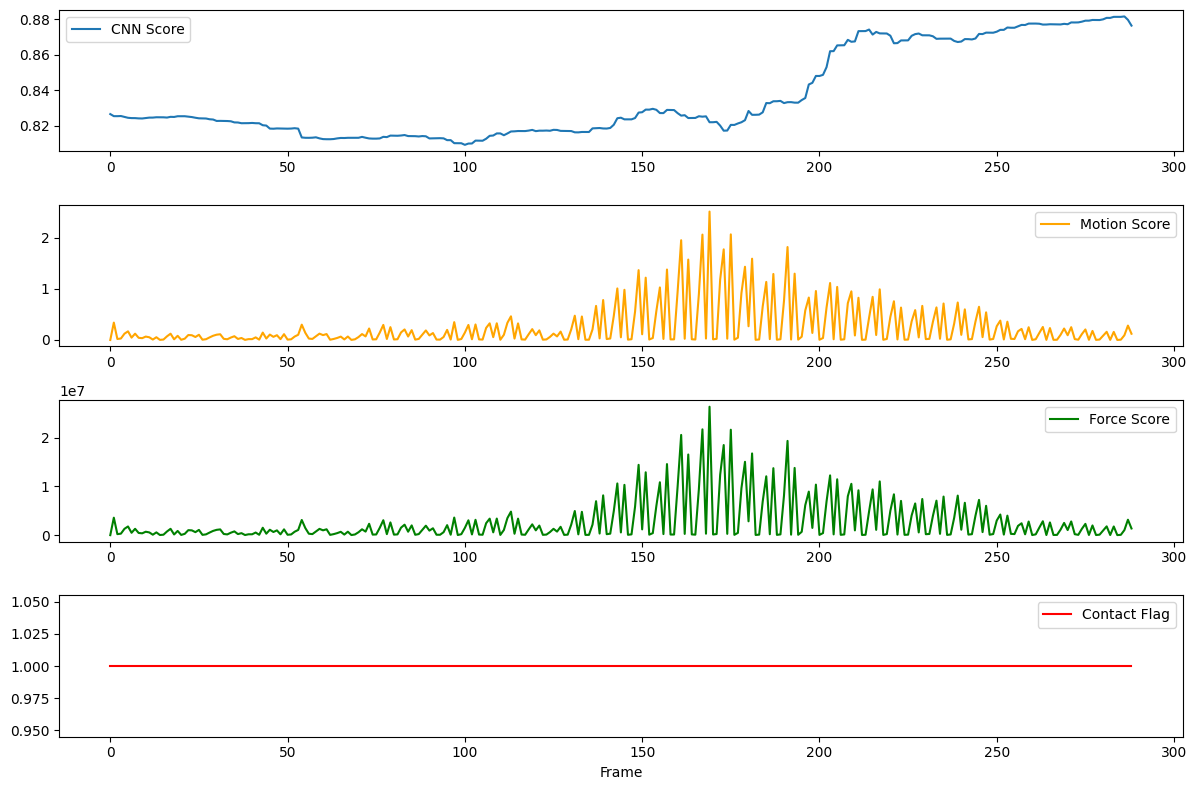

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    cnn_score = []
    motion_score = []
    force_score = []
    contact_flag = []

    # --- Parameters ---
    prev_gray = None
    force_scale = 1e5
    contact_threshold = 50       # intensity threshold
    motion_threshold = 2.0       # motion threshold

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # -------------------------------
        # CNN score (placeholder: mean intensity)
        cnn_val = np.mean(gray) / 255.0 * 2.0  # normalized to ~0–2
        cnn_score.append(cnn_val)

        # -------------------------------
        # Motion score (optical flow magnitude)
        if prev_gray is not None:
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
            motion_val = np.mean(mag)
        else:
            motion_val = 0.0
        motion_score.append(motion_val)

        # -------------------------------
        # Force score (proxy: motion * intensity)
        force_val = motion_val * np.mean(gray) * force_scale
        force_score.append(force_val)

        # -------------------------------
        # Contact flag (motion OR intensity)
        if (motion_val > motion_threshold) or (np.mean(gray) > contact_threshold):
            contact_val = 1
        else:
            contact_val = 0
        contact_flag.append(contact_val)

        prev_gray = gray

    cap.release()

    # Convert to numpy arrays
    cnn_score = np.array(cnn_score)
    motion_score = np.array(motion_score)
    force_score = np.array(force_score)
    contact_flag = np.array(contact_flag)

    return cnn_score, motion_score, force_score, contact_flag, fps


# ============================================================
# Example usage
# ============================================================
video_path = "/content/unknown2.mp4"
cnn_score, motion_score, force_score, contact_flag, fps = process_video(video_path)

print("Frames:", len(cnn_score))
print("\nCNN Score array:\n", cnn_score)
print("\nMotion Score array:\n", motion_score)
print("\nForce Score array:\n", force_score)
print("\nContact Flag array:\n", contact_flag)

# ============================================================
# Optional: Plot signals for visualization
# ============================================================
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(cnn_score, label="CNN Score")
plt.legend()

plt.subplot(4,1,2)
plt.plot(motion_score, label="Motion Score", color="orange")
plt.legend()

plt.subplot(4,1,3)
plt.plot(force_score, label="Force Score", color="green")
plt.legend()

plt.subplot(4,1,4)
plt.plot(contact_flag, label="Contact Flag", color="red")
plt.legend()

plt.xlabel("Frame")
plt.tight_layout()
plt.show()
